# Decision program using machine learning methods

In [1]:
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install tqdm
#!pip install dhg

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
#import dhg
import torch.nn as nn
from copy import deepcopy

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/POS_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 115
Number of instances with original runtime (0.01, 0.1]: 797
Number of instances with original runtime (0.1, 1]: 1053
Number of instances with original runtime (1,10]: 434
Number of instances with original runtime (10,100]: 244
Number of instances with original runtime TO: 293


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 1
Number of instances with original runtime (0.01, 0.1]: 522
Number of instances with original runtime (0.1, 1]: 1937
Number of instances with original runtime (1,10]: 227
Number of instances with original runtime (10,100]: 208
Number of instances with original runtime TO: 41


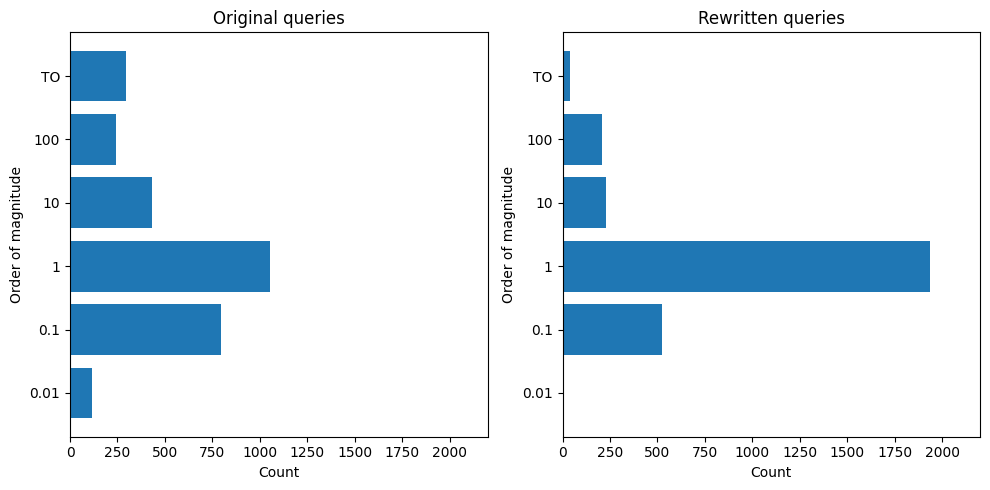

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_POS.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
0  STATS              001-014            orig                 orig   0.030513   
1  STATS        001-014-augA1            orig                 orig   0.030952   
2  STATS        001-014-augA2            orig                 orig   0.030812   
3  STATS        001-014-augF1            orig                 orig   0.029663   
4  STATS  001-014-augF1-augA1            orig                 orig   0.030595   

   rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  #relations  \
0   0.063829        1.989236        0.033316             1.958724           3   
1   0.043271        1.840104        0.012320             1.809152           3   
2   0.168679        1.987010        0.137867             1.956198           3   
3   0.156431        1.988726        0.126768             1.959062           3   
4   0.043383        1.898386        0.012788             1.867790           3   

   ...  min(branching factors)  max(branching factors)  \
0  ...                       2                       2   
1  ...                       1                       1   
2  ...                       1                       1   
3  ...                       2                       2   
4  ...                       1                       1   

   mean(branching factors)  median(branching factors)  q25(branching factors)  \
0                      2.0                        2.0                     2.0   
1                      1.0                        1.0                     1.0   
2                      1.0                        1.0                     1.0   
3                      2.0                        2.0                     2.0   
4                      1.0                        1.0                     1.0   

   q75(branching factors)  balancedness factor  \
0                     2.0                  1.0   
1                     1.0                  NaN   
2                     1.0                  NaN   
3                     2.0                  1.0   
4                     1.0                  NaN   

                           container counts list  branching factors list  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 30 columns]

In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
c

#### Delete those examples, where both methods gave a timeout

In [8]:
df[df["orig/rewr(mean)"] == "-"]

bench              query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
2071  SNAP        wiki-path05               -                    -      100.0   
2072  SNAP  wiki-path05-augA1               -                    -      100.0   
2073  SNAP  wiki-path05-augA2               -                    -      100.0   
2074  SNAP  wiki-path05-augA3               -                    -      100.0   
2075  SNAP  wiki-path05-augA4               -                    -      100.0   
2076  SNAP  wiki-path05-augA5               -                    -      100.0   
2077  SNAP        wiki-path06               -                    -      100.0   
2078  SNAP  wiki-path06-augA1               -                    -      100.0   
2079  SNAP  wiki-path06-augA2               -                    -      100.0   
2080  SNAP  wiki-path06-augA3               -                    -      100.0   
2081  SNAP  wiki-path06-augA4               -                    -      100.0   
2082  SNAP  wiki-path06-augA5               -                    -      100.0   
2083  SNAP  wiki-path06-augA6               -                    -      100.0   
2084  SNAP        wiki-path07               -                    -      100.0   
2085  SNAP  wiki-path07-augA1               -                    -      100.0   
2086  SNAP  wiki-path07-augA2               -                    -      100.0   
2087  SNAP  wiki-path07-augA3               -                    -      100.0   
2088  SNAP  wiki-path07-augA4               -                    -      100.0   
2089  SNAP  wiki-path07-augA5               -                    -      100.0   
2090  SNAP  wiki-path07-augA6               -                    -      100.0   
2091  SNAP  wiki-path07-augA7               -                    -      100.0   
2092  SNAP        wiki-path08               -                    -      100.0   
2093  SNAP  wiki-path08-augA1               -                    -      100.0   
2094  SNAP  wiki-path08-augA2               -                    -      100.0   
2095  SNAP  wiki-path08-augA3               -                    -      100.0   
2096  SNAP  wiki-path08-augA4               -                    -      100.0   
2097  SNAP  wiki-path08-augA5               -                    -      100.0   
2098  SNAP  wiki-path08-augA6               -                    -      100.0   
2099  SNAP  wiki-path08-augA7               -                    -      100.0   
2100  SNAP  wiki-path08-augA8               -                    -      100.0   
2112  SNAP        wiki-tree03               -                    -      100.0   
2113  SNAP  wiki-tree03-augA1               -                    -      100.0   
2114  SNAP  wiki-tree03-augA2               -                    -      100.0   
2115  SNAP  wiki-tree03-augA3               -                    -      100.0   
2116  SNAP  wiki-tree03-augA4               -                    -      100.0   
2117  SNAP  wiki-tree03-augA5               -                    -      100.0   
2118  SNAP  wiki-tree03-augA6               -                    -      100.0   
2119  SNAP  wiki-tree03-augA7               -                    -      100.0   

      rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  \
2071      100.0           100.0             0.0                  0.0   
2072      100.0           100.0             0.0                  0.0   
2073      100.0           100.0             0.0                  0.0   
2074      100.0           100.0             0.0                  0.0   
2075      100.0           100.0             0.0                  0.0   
2076      100.0           100.0             0.0                  0.0   
2077      100.0           100.0             0.0                  0.0   
2078      100.0           100.0             0.0                  0.0   
2079      100.0           100.0             0.0                  0.0   
2080      100.0           100.0             0.0                  0.0   
2081      100.0           100.0             0.0      

For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [9]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2898, 30)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [10]:
X = df.iloc[:, 9:26]
X.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      2                      1   
2           3            7         5       2      2                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      2                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       1   
2                       1.0                    1.0                       1   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       1   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       1                      1.0                        1.0   
2                       1                      1.0                        1.0   
3                       2                      2.0                        2.0   
4                       1                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     1.0                     1.0  
2                     1.0                     1.0  
3                     2.0                     2.0  
4                     1.0                     1.0

#### Log-transformations

This basic features do not need log transformations.

In [11]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min   Max       Diff
#relations                 2.000000  11.0   9.000000
#conditions                2.000000  20.0  18.000000
#filters                   0.000000  16.0  16.000000
#joins                     1.000000  12.0  11.000000
depth                      1.000000   7.0   6.000000
min(container counts)      1.000000   1.0   0.000000
max(container counts)      2.000000   5.0   3.000000
mean(container counts)     1.047619   1.6   0.552381
q25(container counts)      1.000000   1.0   0.000000
median(container counts)   1.000000   1.0   0.000000
q75(container counts)      1.000000   1.5   0.500000
min(branching factors)     1.000000   6.0   5.000000
max(branching factors)     1.000000   6.0   5.000000
mean(branching factors)    1.000000   6.0   5.000000
median(branching factors)  1.000000   6.0   5.000000
q25(branching factors)     1.000000   6.0   5.000000
q75(branching factors)     1.000000   6.0   5.000000

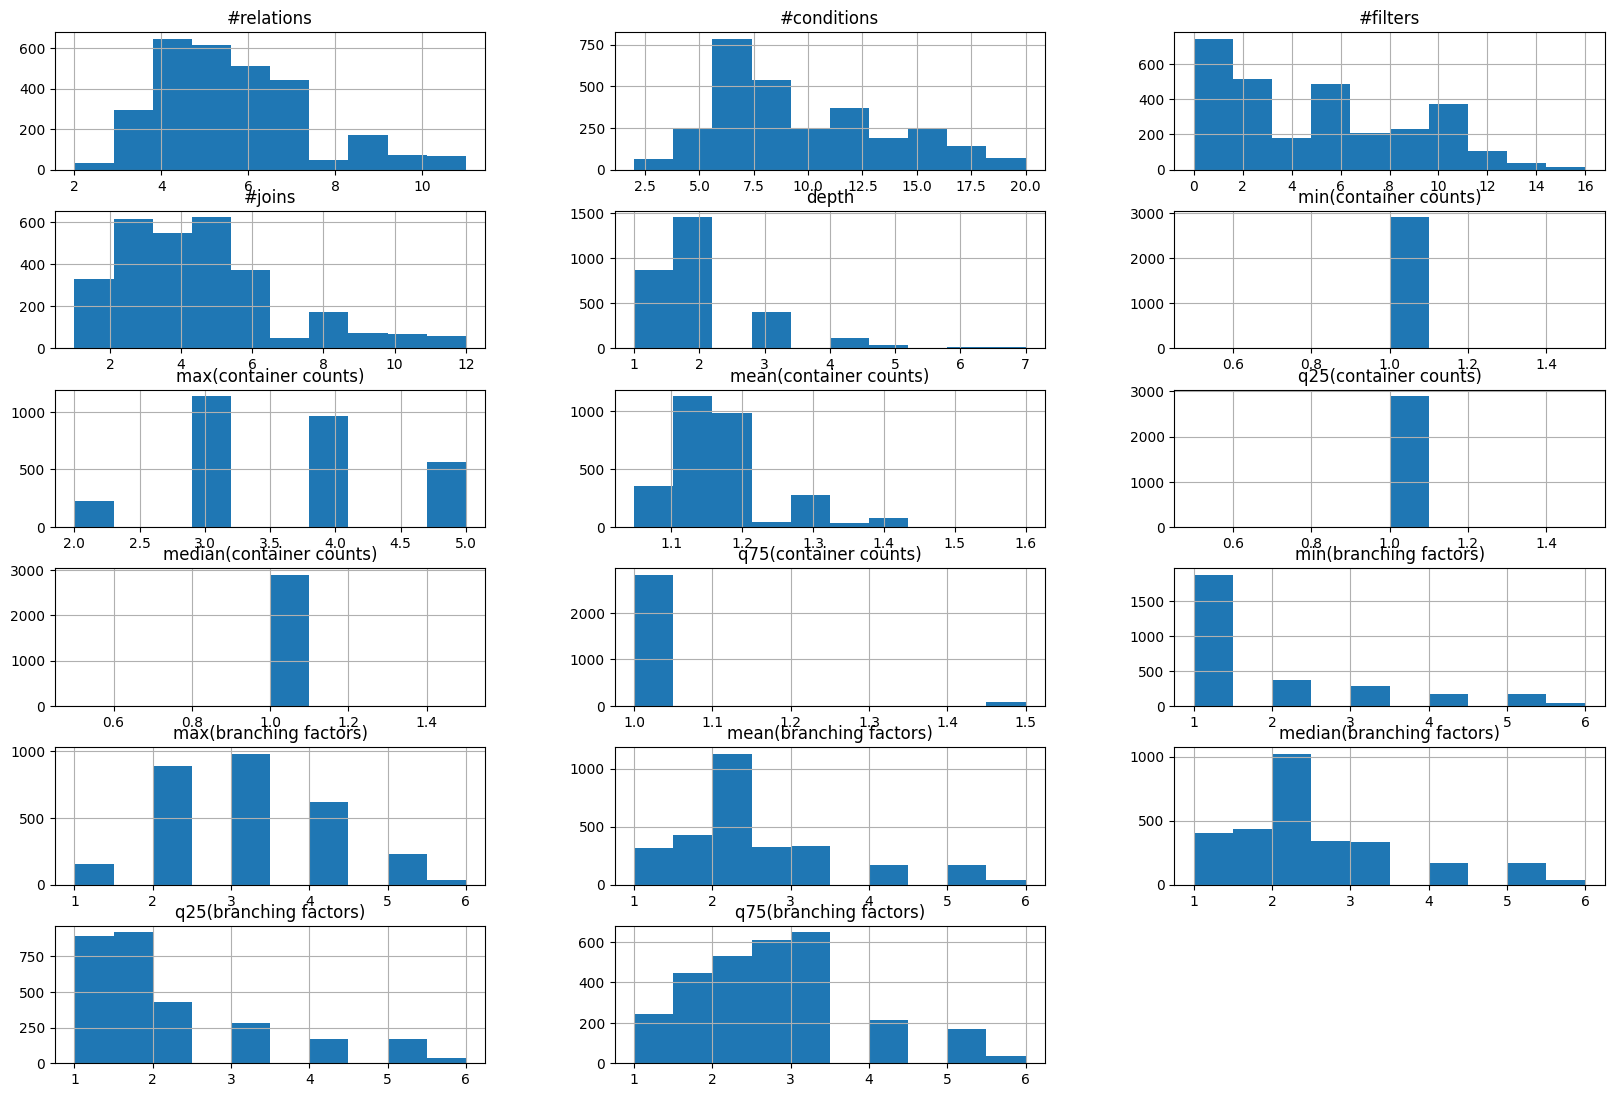

In [12]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

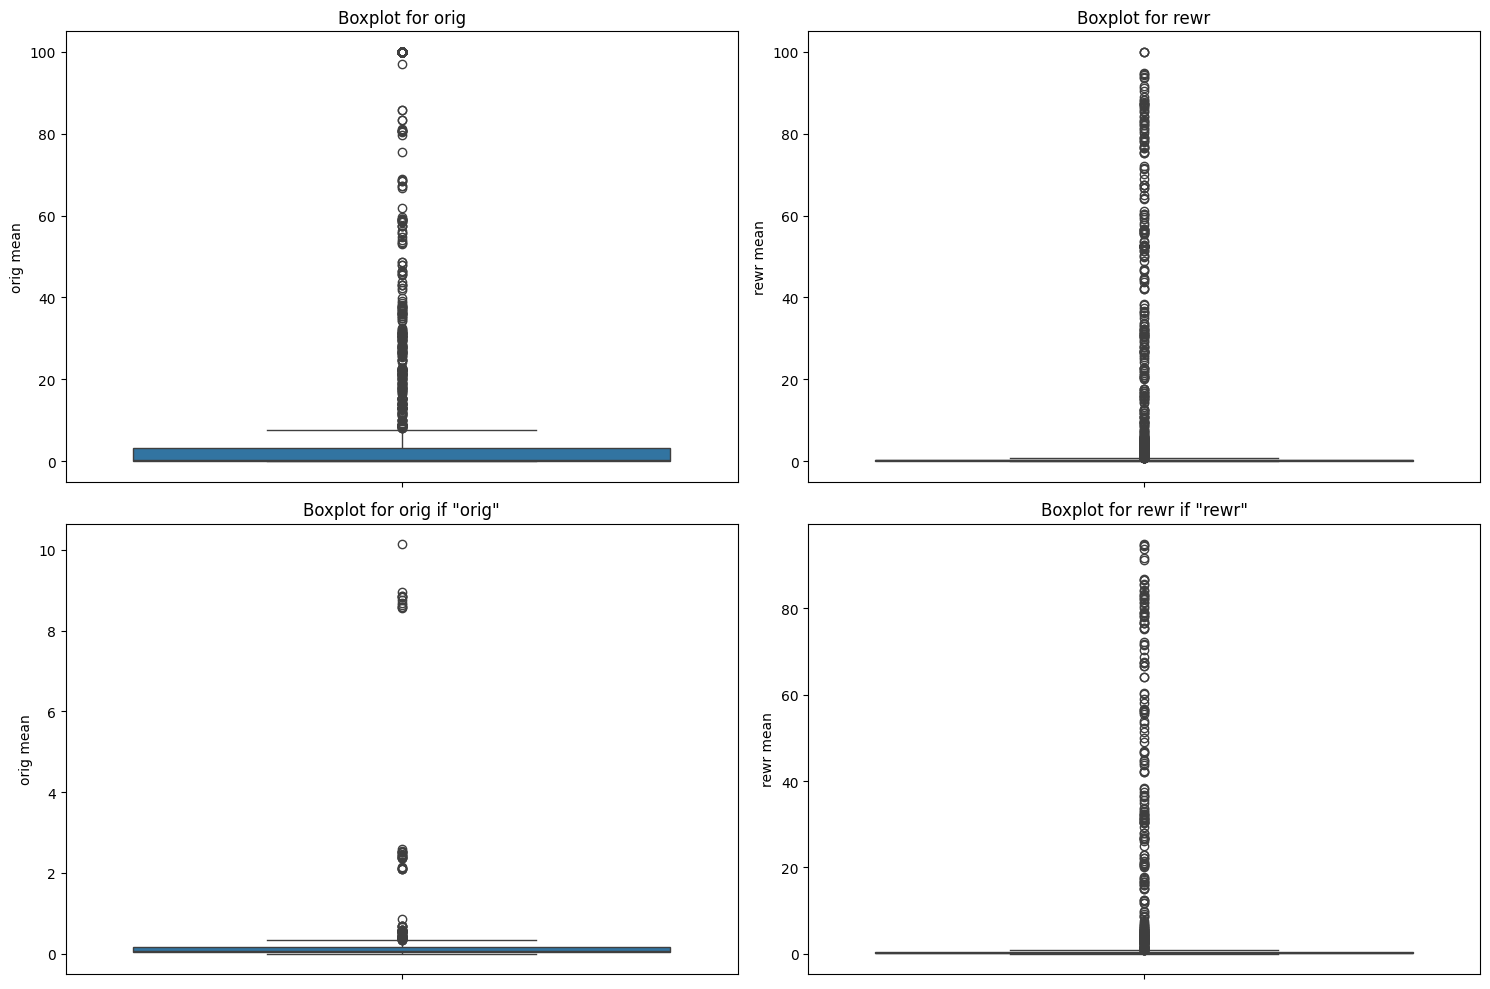

In [13]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

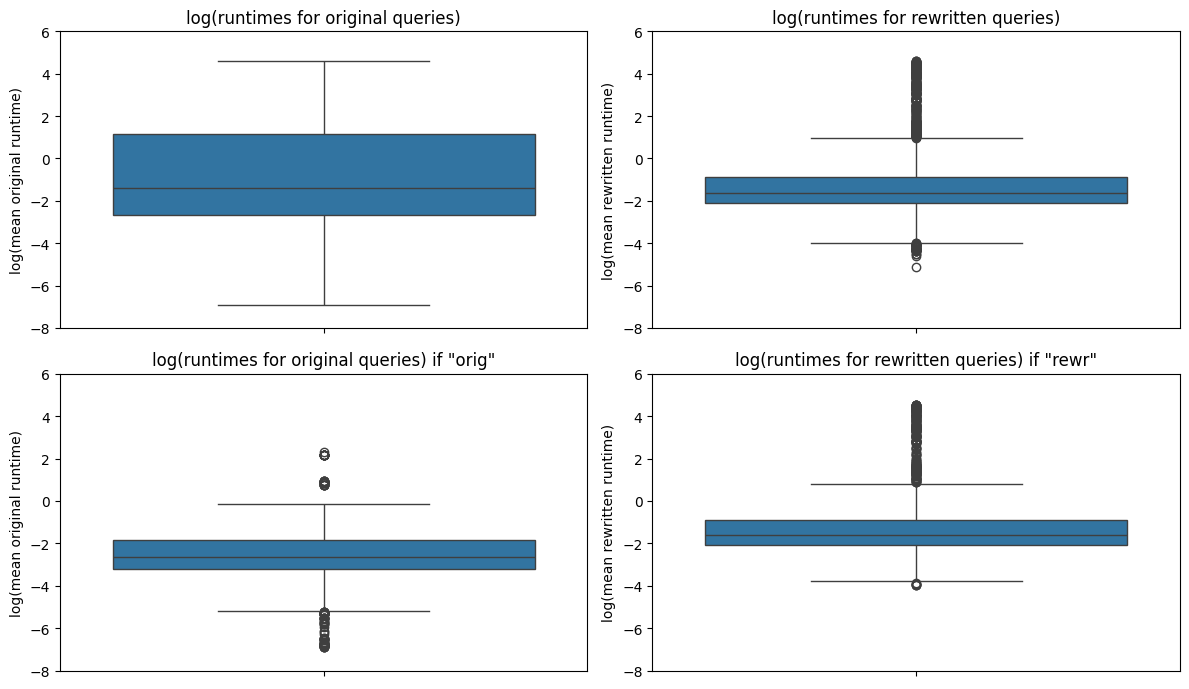

In [14]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

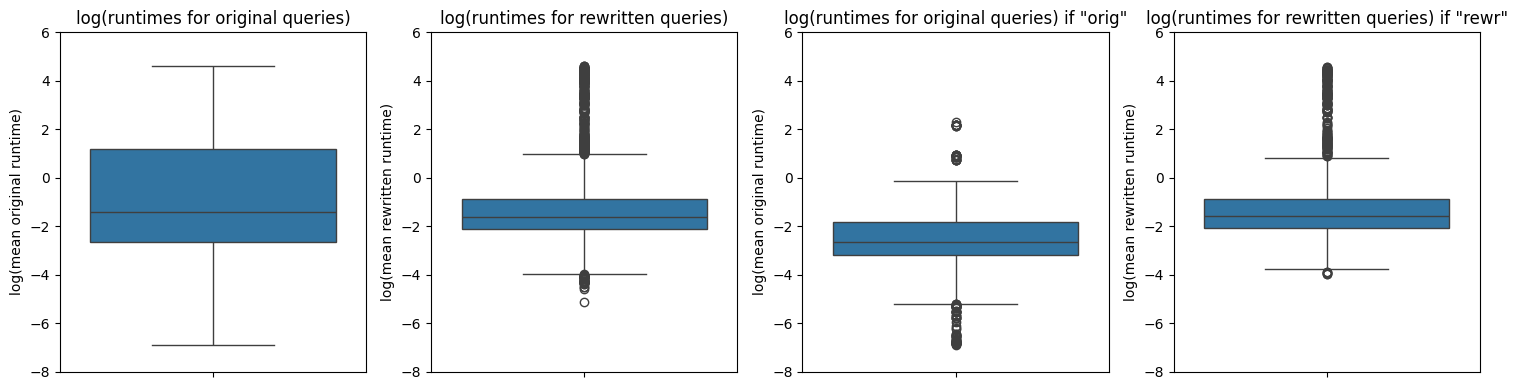

In [15]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

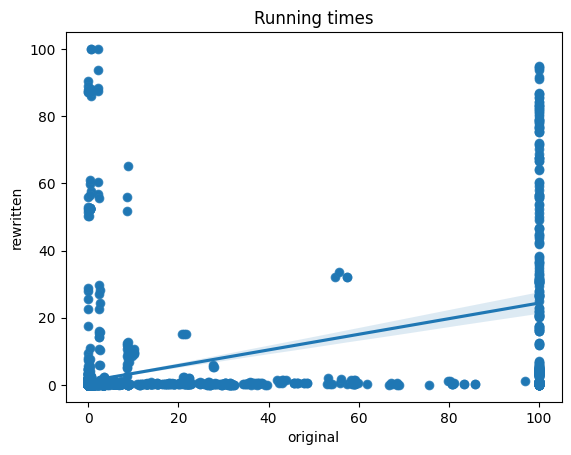

In [16]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

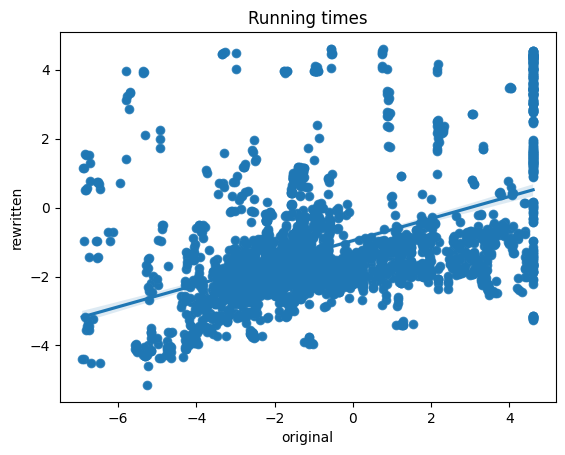

In [17]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [18]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [19]:
y1.value_counts()

orig/rewr(mean)
1    1480
0    1418
Name: count, dtype: int64

In [20]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1418
rewr     1480
equal       -
dtype: object

In [21]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
rewr    1480
orig    1418
Name: count, dtype: int64

#### Classification response with three cases

In [22]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [23]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [24]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [25]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [26]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [27]:
count_001

orig/rewr/equal 0.01
rewr     1435
orig     1322
equal     141
Name: count, dtype: int64

In [28]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

2 classes  3 classes (0.01)  3 classes (0.05)  3 classes (0.1)  \
orig       1418              1322              1007              706   
rewr       1480              1435              1336             1243   
equal         -               141               555              949   

       3 classes (0.5)  
orig               240  
rewr               989  
equal             1669

In [29]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [30]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [31]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.05, dtype: int64

In [32]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [33]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

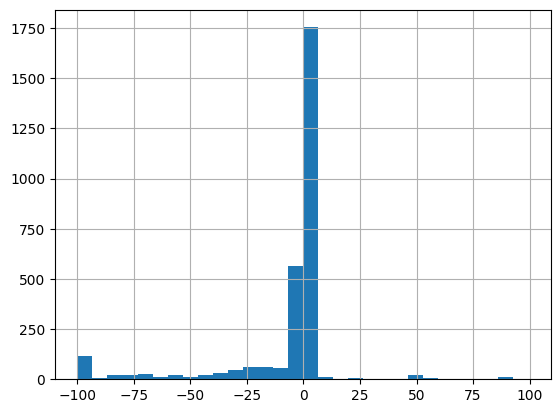

In [34]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

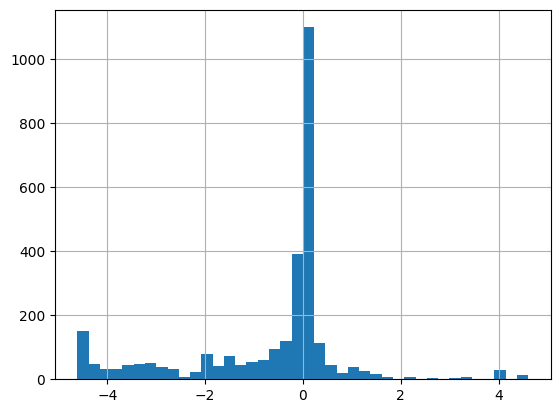

In [35]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

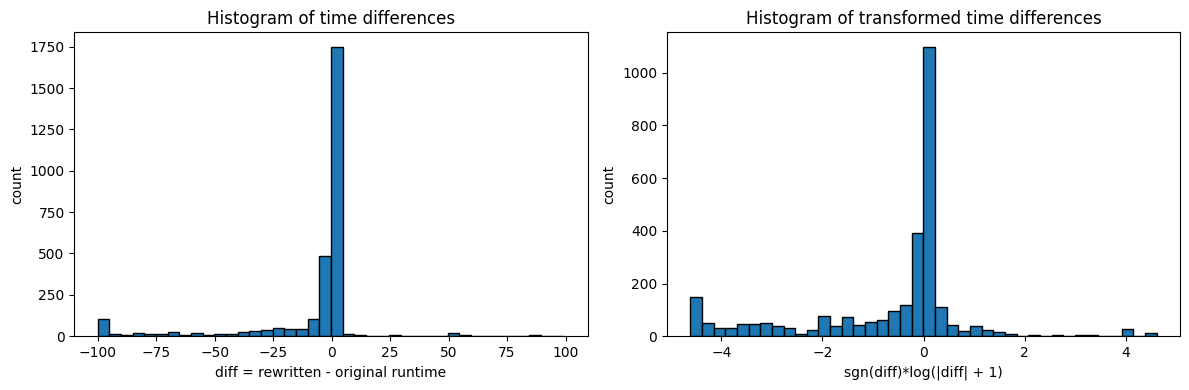

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [37]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [38]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

## ML models

In [39]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [40]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [41]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[109,  18],
       [ 36, 127]])

CV:

In [42]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [43]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1030,  244],
       [ 244, 1090]])

Adding the values to the result table:

In [44]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN  0.813793  0.779141  0.812883  0.817091

### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [45]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [46]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[ 23,   2,   0],
       [  6, 142,  21],
       [  1,  17,  78]])

CV:

In [47]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [48]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[ 174,   44,    1],
       [  52, 1251,  186],
       [  10,  165,  725]])

Adding the values to the result table:

In [49]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.837931  0.837931  0.857579  0.824387  0.824387  0.813412

##### equal cut off: 0.1

Train-test split:

In [50]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [51]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[ 47,   7,   5],
       [ 18,  65,  14],
       [ 10,  15, 109]])

CV:

In [52]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [53]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[429, 124,  69],
       [154, 548, 155],
       [ 80, 112, 937]])

Adding the values to the result table:

In [54]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1  0.762069  0.762069  0.760049  0.733896  0.733896  0.719696

##### equal cut off: 0.05

Train-test split:

In [55]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [56]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[ 78,   7,   8],
       [ 21,  20,  15],
       [ 20,  12, 109]])

CV:

In [57]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [58]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[700,  80, 119],
       [183, 179, 138],
       [146,  90, 973]])

Adding the values to the result table:

In [59]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1   0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05  0.713793  0.713793  0.656301  0.710123  0.710123  0.647147

##### equal cut off: 0.01

Train-test split:

In [60]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [61]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[101,   1,  17],
       [ 12,   0,   7],
       [ 33,   1, 118]])

CV:

In [62]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [63]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[ 961,   13,  212],
       [  69,    8,   52],
       [ 242,    8, 1043]])

Adding the values to the result table:

In [64]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1   0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05  0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01  0.755172  0.755172  0.541685  0.771472  0.771472  0.559651

### k-Nearest Neighbors with time difference

Train-test split:

In [65]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [66]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [67]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [68]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [69]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE      MAE        R2
5-NN  0.649719  0.477766  0.763458  0.766804  0.51984  0.723023

### Decision tree with two classes

Train-test split:

In [70]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [71]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[118,   9],
       [ 43, 120]])

CV:

In [72]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [73]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1096,  178],
       [ 271, 1063]])

Adding the values to the result table:

In [74]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852

### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [75]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [76]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 22,   3,   0],
       [  4, 152,  13],
       [  0,  17,  79]])

CV:

In [77]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [78]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[ 165,   54,    0],
       [  31, 1324,  134],
       [   7,  177,  716]])

Adding the values to the result table:

In [79]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1           0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05          0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01          0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5  0.872414  0.872414  0.867442  0.845475  0.845475  0.812723

##### equal cut off: 0.1

Train-test split:

In [80]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [81]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[ 42,  12,   5],
       [ 13,  75,   9],
       [  3,  23, 108]])

CV:

In [82]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [83]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[428, 141,  53],
       [151, 583, 123],
       [ 57, 137, 935]])

Adding the values to the result table:

In [84]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1           0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05          0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01          0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5  0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1  0.775862  0.775862  0.763677  0.746166  0.746166  0.732183

##### equal cut off: 0.05

Train-test split:

In [85]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [86]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[ 82,   5,   6],
       [ 20,  22,  14],
       [ 18,  11, 112]])

CV:

In [87]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [88]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[732,  70,  97],
       [189, 184, 127],
       [145,  85, 979]])

Adding the values to the result table:

In [89]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999

##### equal cut off: 0.01

Train-test split:

In [90]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [91]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[108,   2,   9],
       [ 12,   0,   7],
       [ 36,   3, 113]])

CV:

In [92]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [93]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1014,   13,  159],
       [  64,   12,   53],
       [ 252,   22, 1019]])

Adding the values to the result table:

In [94]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696

### Decision tree with time difference

Train-test split:

In [95]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [96]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [97]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [98]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [99]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804  0.519840  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362  0.760080

### Random forest with two classes

Train-test split:

In [100]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [101]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[118,   9],
       [ 41, 122]])

CV:

In [102]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [103]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1077,  197],
       [ 249, 1085]])

Adding the values to the result table:

In [104]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343

### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [105]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [106]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 22,   3,   0],
       [  4, 148,  17],
       [  0,  15,  81]])

CV:

In [107]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [108]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[ 164,   54,    1],
       [  27, 1312,  150],
       [   5,  156,  739]])

Adding the values to the result table:

In [109]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033

##### equal cut off: 0.1

Train-test split:

In [110]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [111]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[ 42,  12,   5],
       [ 12,  75,  10],
       [  2,  23, 109]])

CV:

In [112]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [113]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[409, 155,  58],
       [123, 601, 133],
       [ 45, 131, 953]])

Adding the values to the result table:

In [114]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317

##### equal cut off: 0.05

Train-test split:

In [115]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [116]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[ 79,   7,   7],
       [ 18,  24,  14],
       [ 15,  12, 114]])

CV:

In [117]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [118]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[ 704,   84,  111],
       [ 172,  193,  135],
       [ 122,   81, 1006]])

Adding the values to the result table:

In [119]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062

##### equal cut off: 0.01

Train-test split:

In [120]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [121]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[107,   2,  10],
       [ 10,   1,   8],
       [ 32,   3, 117]])

CV:

In [122]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [123]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[ 994,   17,  175],
       [  58,   15,   56],
       [ 217,   18, 1058]])

Adding the values to the result table:

In [124]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881

### Random forest with time difference

Train-test split:

In [125]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [126]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [127]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [128]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [129]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804  0.519840  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362  0.760080
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032

### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [130]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [131]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 77,  50],
       [ 46, 117]])

CV:

In [132]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [133]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[773, 501],
       [353, 981]])

Adding the values to the result table:

In [134]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382

### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [135]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [136]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 22,   1,   2],
       [  5, 156,   8],
       [  0,  65,  31]])

CV:

In [137]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [138]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 182,   23,   14],
       [  52, 1376,   61],
       [   4,  602,  294]])

Adding the values to the result table:

In [139]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942

##### equal cut off: 0.1

Train-test split:

In [140]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [141]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 25,   7,  27],
       [  5,  59,  33],
       [  1,  20, 113]])

CV:

In [142]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [143]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[231, 102, 289],
       [ 31, 467, 359],
       [ 18, 180, 931]])

Adding the values to the result table:

In [144]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310

##### equal cut off: 0.05

Train-test split:

In [145]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [146]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 40,   8,  45],
       [  8,  23,  25],
       [ 14,  13, 114]])

CV:

In [147]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [148]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 324,   98,  477],
       [  72,  182,  246],
       [  81,  124, 1004]])

Adding the values to the result table:

In [149]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280

##### equal cut off: 0.01

Train-test split:

In [150]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [151]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 72,   0,  47],
       [ 10,   0,   9],
       [ 39,   0, 113]])

CV:

In [152]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [153]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[713,   0, 473],
       [ 77,   0,  52],
       [323,   0, 970]])

Adding the values to the result table:

In [154]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458

### SVM with time difference, linear kernel

Train-test split:

In [155]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [156]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [157]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [158]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [159]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804  0.519840  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362  0.760080
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849  2.043520  0.874135  0.261861

### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [160]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [161]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 86,  41],
       [ 59, 104]])

CV:

In [162]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [163]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[827, 447],
       [424, 910]])

Adding the values to the result table:

In [164]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159

### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [165]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [166]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 11,  13,   1],
       [  1, 161,   7],
       [  0,  62,  34]])

CV:

In [167]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [168]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  88,  128,    3],
       [  19, 1420,   50],
       [   4,  539,  357]])

Adding the values to the result table:

In [169]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051

##### equal cut off: 0.1

Train-test split:

In [170]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [171]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[30,  9, 20],
       [ 6, 74, 17],
       [ 2, 57, 75]])

CV:

In [172]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [173]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[276, 129, 217],
       [ 54, 611, 192],
       [ 35, 423, 671]])

Adding the values to the result table:

In [174]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671

##### equal cut off: 0.05

Train-test split:

In [175]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [176]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 47,   0,  46],
       [  9,   5,  42],
       [ 12,   5, 124]])

CV:

In [177]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [178]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 439,    6,  454],
       [  82,   45,  373],
       [  82,   12, 1115]])

Adding the values to the result table:

In [179]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190

##### equal cut off: 0.01

Train-test split:

In [180]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [181]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 65,   0,  54],
       [  8,   0,  11],
       [ 21,   0, 131]])

CV:

In [182]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [183]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[ 634,    0,  552],
       [  45,    0,   84],
       [ 171,    0, 1122]])

Adding the values to the result table:

In [184]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313  0.467440

### SVM with time difference, polynomial kernel

Train-test split:

In [185]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [186]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [187]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [188]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [189]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804  0.519840  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362  0.760080
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849  2.043520  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997

### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [190]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [191]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 73,  54],
       [ 22, 141]])

CV:

In [192]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [193]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[ 696,  578],
       [ 174, 1160]])

Adding the values to the result table:

In [194]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565

### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [195]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [196]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 12,  12,   1],
       [  2, 164,   3],
       [  0,  67,  29]])

CV:

In [197]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [198]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 117,   99,    3],
       [  20, 1456,   13],
       [   4,  616,  280]])

Adding the values to the result table:

In [199]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313  0.467440
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732

##### equal cut off: 0.1

Train-test split:

In [200]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [201]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[22, 11, 26],
       [ 3, 66, 28],
       [ 1, 46, 87]])

CV:

In [202]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [203]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[210, 111, 301],
       [ 19, 554, 284],
       [  8, 314, 807]])

Adding the values to the result table:

In [204]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313  0.467440
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285

##### equal cut off: 0.05

Train-test split:

In [205]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [206]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 52,   6,  35],
       [ 15,  19,  22],
       [ 13,   9, 119]])

CV:

In [207]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [208]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 481,   45,  373],
       [ 120,  159,  221],
       [ 111,   76, 1022]])

Adding the values to the result table:

In [209]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313  0.467440
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799  0.637270  0.637270  0.566122

##### equal cut off: 0.01

Train-test split:

In [210]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [211]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 66,   0,  53],
       [ 10,   0,   9],
       [ 14,   0, 138]])

CV:

In [212]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [213]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[ 635,    0,  551],
       [  39,    0,   90],
       [ 129,    0, 1164]])

Adding the values to the result table:

In [214]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635  0.726610  0.726610  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497  0.849310  0.849310  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617  0.580310
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988  0.518280
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113  0.500190
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313  0.467440
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799  0.637270  0.637270  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548

### SVM with time difference, rbf kernel

Train-test split:

In [215]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [216]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [217]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [218]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [219]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804  0.519840  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362  0.760080
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849  2.043520  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414  0.344560

### Deep MLP with two classes

In [220]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 2

In [221]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [222]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [223]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [224]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.7570600261290868
Validation loss: 0.6580146551132202
New best model found at epoch 1 with validation loss 0.6580146551132202
Starting Epoch 2
0.6507228910923004
Validation loss: 0.6902912259101868
Starting Epoch 3
0.6441494499643644
Validation loss: 0.6656160354614258
Starting Epoch 4
0.6208341767390569
Validation loss: 0.7112773060798645
Starting Epoch 5
0.6238284806410471
Validation loss: 0.6480717658996582
New best model found at epoch 5 with validation loss 0.6480717658996582
Starting Epoch 6
0.6194011022647222
Validation loss: 0.6265375018119812
New best model found at epoch 6 with validation loss 0.6265375018119812
Starting Epoch 7
0.6102166796724001
Validation loss: 0.6006649136543274
New best model found at epoch 7 with validation loss 0.6006649136543274
Starting Epoch 8
0.6101690952976545
Validation loss: 0.622556209564209
Starting Epoch 9
0.6009627630313238
Validation loss: 0.6205907464027405
Starting Epoch 10
0.5888252109289169
Validation loss: 0.619944036

In [225]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [226]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 92,  35],
       [ 37, 126]])

In [227]:
table_2_classes.loc["MLP: 17-5-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 2

In [228]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [229]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [230]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [231]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9735578546921412
Validation loss: 0.7211493849754333
New best model found at epoch 1 with validation loss 0.7211493849754333
Starting Epoch 2
0.6724042346080145
Validation loss: 0.6877762675285339
New best model found at epoch 2 with validation loss 0.6877762675285339
Starting Epoch 3
0.6530349850654602
Validation loss: 0.6668950915336609
New best model found at epoch 3 with validation loss 0.6668950915336609
Starting Epoch 4
0.6428628712892532
Validation loss: 0.6644082069396973
New best model found at epoch 4 with validation loss 0.6644082069396973
Starting Epoch 5
0.6324724604686102
Validation loss: 0.6247215270996094
New best model found at epoch 5 with validation loss 0.6247215270996094
Starting Epoch 6
0.6226613819599152
Validation loss: 0.6738910675048828
Starting Epoch 7
0.6221183687448502
Validation loss: 0.7797463536262512
Starting Epoch 8
0.6229792833328247
Validation loss: 0.6045405864715576
New best model found at epoch 8 with validation loss 0.604540586

In [232]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [233]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 83,  44],
       [ 31, 132]])

In [234]:
table_2_classes.loc["MLP: 17-10-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -
MLP: 17-10-2   0.741379  0.809816         -         -

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 2

In [235]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [236]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [237]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [238]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.8475982372959455
Validation loss: 0.6843573451042175
New best model found at epoch 1 with validation loss 0.6843573451042175
Starting Epoch 2
0.6576090256373087
Validation loss: 0.6560007929801941
New best model found at epoch 2 with validation loss 0.6560007929801941
Starting Epoch 3
0.639500247935454
Validation loss: 0.6528328061103821
New best model found at epoch 3 with validation loss 0.6528328061103821
Starting Epoch 4
0.6368312537670135
Validation loss: 0.6449055075645447
New best model found at epoch 4 with validation loss 0.6449055075645447
Starting Epoch 5
0.6348375255862871
Validation loss: 0.645810067653656
Starting Epoch 6
0.6265537093083063
Validation loss: 0.6225420236587524
New best model found at epoch 6 with validation loss 0.6225420236587524
Starting Epoch 7
0.6195871656139692
Validation loss: 0.6215259432792664
New best model found at epoch 7 with validation loss 0.6215259432792664
Starting Epoch 8
0.6144279539585114
Validation loss: 0.61420041322

In [239]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [240]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 85,  42],
       [ 30, 133]])

In [241]:
table_2_classes.loc["MLP: 17-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -
MLP: 17-10-2   0.741379  0.809816         -         -
MLP: 17-20-2   0.751724  0.815951         -         -

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 2

In [242]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [243]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [244]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [245]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0556680286924045
Validation loss: 0.6863694190979004
New best model found at epoch 1 with validation loss 0.6863694190979004
Starting Epoch 2
0.6578767249981562
Validation loss: 0.6785145998001099
New best model found at epoch 2 with validation loss 0.6785145998001099
Starting Epoch 3
0.6520675470431646
Validation loss: 0.6519311666488647
New best model found at epoch 3 with validation loss 0.6519311666488647
Starting Epoch 4
0.6425263906518618
Validation loss: 0.6667971611022949
Starting Epoch 5
0.6315830598274866
Validation loss: 0.6622371673583984
Starting Epoch 6
0.6320887530843416
Validation loss: 0.67081218957901
Starting Epoch 7
0.6249035224318504
Validation loss: 0.6408891081809998
New best model found at epoch 7 with validation loss 0.6408891081809998
Starting Epoch 8
0.6184256176153818
Validation loss: 0.8415875434875488
Starting Epoch 9
0.6292313213149706
Validation loss: 0.6190339922904968
New best model found at epoch 9 with validation loss 0.61903399229

In [246]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [247]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 91,  36],
       [ 38, 125]])

In [248]:
table_2_classes.loc["MLP: 17-25-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -
MLP: 17-10-2   0.741379  0.809816         -         -
MLP: 17-20-2   0.751724  0.815951         -         -
MLP: 17-25-2   0.744828  0.766871         -         -

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 2

In [249]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [250]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [251]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [252]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.336161012450854
Validation loss: 0.7130804061889648
New best model found at epoch 1 with validation loss 0.7130804061889648
Starting Epoch 2
0.6966731548309326
Validation loss: 0.7172102928161621
Starting Epoch 3
0.6812415247162183
Validation loss: 0.6707803010940552
New best model found at epoch 3 with validation loss 0.6707803010940552
Starting Epoch 4
0.6704075013597807
Validation loss: 0.7090267539024353
Starting Epoch 5
0.6757022639115652
Validation loss: 0.7969210147857666
Starting Epoch 6
0.6563828215003014
Validation loss: 0.6923873424530029
Starting Epoch 7
0.6488278806209564
Validation loss: 0.8505544066429138
Starting Epoch 8
0.6463758672277132
Validation loss: 0.8414066433906555
Starting Epoch 9
0.6435646613438925
Validation loss: 0.6412335634231567
New best model found at epoch 9 with validation loss 0.6412335634231567
Starting Epoch 10
0.6346682036916415
Validation loss: 0.6373399496078491
New best model found at epoch 10 with validation loss 0.63733994

In [253]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [254]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 92,  35],
       [ 37, 126]])

In [255]:
table_2_classes.loc["MLP: 17-40-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -
MLP: 17-10-2   0.741379  0.809816         -         -
MLP: 17-20-2   0.751724  0.815951         -         -
MLP: 17-25-2   0.744828  0.766871         -         -
MLP: 17-40-2   0.751724  0.773006         -         -

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 2

In [256]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [257]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [258]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [259]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3075323129693668
Validation loss: 0.691443920135498
New best model found at epoch 1 with validation loss 0.691443920135498
Starting Epoch 2
0.6789101039369901
Validation loss: 0.7166293859481812
Starting Epoch 3
0.6729422857364019
Validation loss: 0.6760109066963196
New best model found at epoch 3 with validation loss 0.6760109066963196
Starting Epoch 4
0.663769950469335
Validation loss: 0.6566837430000305
New best model found at epoch 4 with validation loss 0.6566837430000305
Starting Epoch 5
0.6525266369183859
Validation loss: 0.6932989954948425
Starting Epoch 6
0.6386527717113495
Validation loss: 0.6964563727378845
Starting Epoch 7
0.6355514600872993
Validation loss: 0.6246197819709778
New best model found at epoch 7 with validation loss 0.6246197819709778
Starting Epoch 8
0.6251779049634933
Validation loss: 0.6591511964797974
Starting Epoch 9
0.615184523165226
Validation loss: 0.6066787242889404
New best model found at epoch 9 with validation loss 0.6066787242889

In [260]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [261]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 85,  42],
       [ 27, 136]])

In [262]:
table_2_classes.loc["MLP: 17-60-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN           0.813793  0.779141  0.812883  0.817091
Decision tree  0.820690  0.736196  0.827837  0.796852
Random forest  0.827586  0.748466  0.828988  0.813343
SVM linear     0.668966  0.717791  0.672546  0.735382
SVM poly       0.655172  0.638037  0.666028  0.682159
SVM rbf        0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2    0.751724  0.773006         -         -
MLP: 17-10-2   0.741379  0.809816         -         -
MLP: 17-20-2   0.751724  0.815951         -         -
MLP: 17-25-2   0.744828  0.766871         -         -
MLP: 17-40-2   0.751724  0.773006         -         -
MLP: 17-60-2   0.762069  0.834356         -         -

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 2

In [263]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [264]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [265]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [266]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.743897999326388
Validation loss: 0.6571929454803467
New best model found at epoch 1 with validation loss 0.6571929454803467
Starting Epoch 2
0.6470255355040232
Validation loss: 0.7087661027908325
Starting Epoch 3
0.6335716744263967
Validation loss: 0.7077376842498779
Starting Epoch 4
0.629515695075194
Validation loss: 0.6274847388267517
New best model found at epoch 4 with validation loss 0.6274847388267517
Starting Epoch 5
0.6148907169699669
Validation loss: 0.6413742303848267
Starting Epoch 6
0.6127521942059199
Validation loss: 0.7138375639915466
Starting Epoch 7
0.6122897639870644
Validation loss: 0.5974109768867493
New best model found at epoch 7 with validation loss 0.5974109768867493
Starting Epoch 8
0.5936402703324953
Validation loss: 0.680081307888031
Starting Epoch 9
0.5939024860660235
Validation loss: 0.6073405742645264
Starting Epoch 10
0.5860101704796156
Validation loss: 0.6705531477928162
Starting Epoch 11
0.5909594520926476
Validation loss: 0.5650796890

In [267]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [268]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 78,  49],
       [ 23, 140]])

In [269]:
table_2_classes.loc["MLP: 17-10-5-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN            0.813793  0.779141  0.812883  0.817091
Decision tree   0.820690  0.736196  0.827837  0.796852
Random forest   0.827586  0.748466  0.828988  0.813343
SVM linear      0.668966  0.717791  0.672546  0.735382
SVM poly        0.655172  0.638037  0.666028  0.682159
SVM rbf         0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2     0.751724  0.773006         -         -
MLP: 17-10-2    0.741379  0.809816         -         -
MLP: 17-20-2    0.751724  0.815951         -         -
MLP: 17-25-2    0.744828  0.766871         -         -
MLP: 17-40-2    0.751724  0.773006         -         -
MLP: 17-60-2    0.762069  0.834356         -         -
MLP: 17-10-5-2  0.751724  0.858896         -         -

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 2

In [270]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [271]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [272]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [273]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.8205508266886076
Validation loss: 0.6727946996688843
New best model found at epoch 1 with validation loss 0.6727946996688843
Starting Epoch 2
0.663657342394193
Validation loss: 0.6704715490341187
New best model found at epoch 2 with validation loss 0.6704715490341187
Starting Epoch 3
0.6512537201245626
Validation loss: 0.6557556390762329
New best model found at epoch 3 with validation loss 0.6557556390762329
Starting Epoch 4
0.6371039102474848
Validation loss: 0.7092287540435791
Starting Epoch 5
0.6414812728762627
Validation loss: 0.692738950252533
Starting Epoch 6
0.6258102605740229
Validation loss: 0.6524792313575745
New best model found at epoch 6 with validation loss 0.6524792313575745
Starting Epoch 7
0.6172616879145304
Validation loss: 0.7017450332641602
Starting Epoch 8
0.6112414846817652
Validation loss: 0.6898153424263
Starting Epoch 9
0.6037510012586912
Validation loss: 0.6195494532585144
New best model found at epoch 9 with validation loss 0.61954945325851

In [274]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [275]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 87,  40],
       [ 32, 131]])

In [276]:
table_2_classes.loc["MLP: 17-20-10-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 2

In [277]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [278]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [279]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [280]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0363949512441952
Validation loss: 0.6902210116386414
New best model found at epoch 1 with validation loss 0.6902210116386414
Starting Epoch 2
0.6853705048561096
Validation loss: 0.6985698342323303
Starting Epoch 3
0.6943079059322675
Validation loss: 0.6939907670021057
Starting Epoch 4
0.6898985803127289
Validation loss: 0.6916150450706482
Starting Epoch 5
0.6865640605489413
Validation loss: 0.6870046257972717
New best model found at epoch 5 with validation loss 0.6870046257972717
Starting Epoch 6
0.6831455181042353
Validation loss: 0.6870960593223572
Starting Epoch 7
0.6773640140891075
Validation loss: 0.6834840178489685
New best model found at epoch 7 with validation loss 0.6834840178489685
Starting Epoch 8
0.6694261655211449
Validation loss: 0.6895885467529297
Starting Epoch 9
0.6647147958477339
Validation loss: 0.673978865146637
New best model found at epoch 9 with validation loss 0.673978865146637
Starting Epoch 10
0.6624571233987808
Validation loss: 0.6676121950

In [281]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [282]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 76,  51],
       [ 23, 140]])

In [283]:
table_2_classes.loc["MLP: 17-40-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -
MLP: 17-40-20-2  0.744828  0.858896         -         -

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 2

In [284]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [285]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [286]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [287]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9475796967744827
Validation loss: 0.6767827272415161
New best model found at epoch 1 with validation loss 0.6767827272415161
Starting Epoch 2
0.6668683439493179
Validation loss: 0.6790375709533691
Starting Epoch 3
0.6611760730544726
Validation loss: 0.6677004098892212
New best model found at epoch 3 with validation loss 0.6677004098892212
Starting Epoch 4
0.6558755313356718
Validation loss: 0.6921567320823669
Starting Epoch 5
0.6516029487053553
Validation loss: 0.6614924073219299
New best model found at epoch 5 with validation loss 0.6614924073219299
Starting Epoch 6
0.6455575252572695
Validation loss: 0.6805076003074646
Starting Epoch 7
0.645228736102581
Validation loss: 0.6547800302505493
New best model found at epoch 7 with validation loss 0.6547800302505493
Starting Epoch 8
0.6371929322679838
Validation loss: 0.6732662916183472
Starting Epoch 9
0.6433219537138939
Validation loss: 0.683150589466095
Starting Epoch 10
0.6418458248178164
Validation loss: 0.6489501595

In [288]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [289]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[126,   1],
       [127,  36]])

In [290]:
table_2_classes.loc["MLP: 17-40-10-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -
MLP: 17-40-20-2  0.744828  0.858896         -         -
MLP: 17-40-10-2  0.558621  0.220859         -         -

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 2

In [291]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [292]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [293]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [294]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.339566983282566
Validation loss: 0.6997198462486267
New best model found at epoch 1 with validation loss 0.6997198462486267
Starting Epoch 2
0.6542788222432137
Validation loss: 0.6699777245521545
New best model found at epoch 2 with validation loss 0.6699777245521545
Starting Epoch 3
0.6399813642104467
Validation loss: 0.6719075441360474
Starting Epoch 4
0.6206213881572088
Validation loss: 0.6274045705795288
New best model found at epoch 4 with validation loss 0.6274045705795288
Starting Epoch 5
0.6090781937042872
Validation loss: 0.6430274844169617
Starting Epoch 6
0.6059917161862055
Validation loss: 0.6042144894599915
New best model found at epoch 6 with validation loss 0.6042144894599915
Starting Epoch 7
0.6086519981424013
Validation loss: 0.6308255195617676
Starting Epoch 8
0.5934923415382704
Validation loss: 0.6389985680580139
Starting Epoch 9
0.5851025953888893
Validation loss: 0.6198417544364929
Starting Epoch 10
0.5733167429765066
Validation loss: 0.606966972

In [295]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [296]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[102,  25],
       [ 44, 119]])

In [297]:
table_2_classes.loc["MLP: 17-60-40-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -
MLP: 17-40-20-2  0.744828  0.858896         -         -
MLP: 17-40-10-2  0.558621  0.220859         -         -
MLP: 17-60-40-2  0.762069  0.730061         -         -

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 2

In [298]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [299]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [300]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [301]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3980331694086392
Validation loss: 0.6838915944099426
New best model found at epoch 1 with validation loss 0.6838915944099426
Starting Epoch 2
0.6795762528975805
Validation loss: 0.6827506422996521
New best model found at epoch 2 with validation loss 0.6827506422996521
Starting Epoch 3
0.6701976284384727
Validation loss: 0.6820617318153381
New best model found at epoch 3 with validation loss 0.6820617318153381
Starting Epoch 4
0.6539396295944849
Validation loss: 0.6668872833251953
New best model found at epoch 4 with validation loss 0.6668872833251953
Starting Epoch 5
0.646218736966451
Validation loss: 0.6312843561172485
New best model found at epoch 5 with validation loss 0.6312843561172485
Starting Epoch 6
0.6345814764499664
Validation loss: 0.8230308294296265
Starting Epoch 7
0.633500911295414
Validation loss: 0.6440450549125671
Starting Epoch 8
0.6242169712980589
Validation loss: 0.6453962326049805
Starting Epoch 9
0.6207077304522196
Validation loss: 0.69460570812

In [302]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [303]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 82,  45],
       [ 20, 143]])

In [304]:
table_2_classes.loc["MLP: 17-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -
MLP: 17-40-20-2  0.744828  0.858896         -         -
MLP: 17-40-10-2  0.558621  0.220859         -         -
MLP: 17-60-40-2  0.762069  0.730061         -         -
MLP: 17-60-20-2  0.775862  0.877301         -         -

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 2

In [305]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [306]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [307]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [308]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.8148091559608777
Validation loss: 0.6741442680358887
New best model found at epoch 1 with validation loss 0.6741442680358887
Starting Epoch 2
0.6352453529834747
Validation loss: 0.7075835466384888
Starting Epoch 3
0.6100547860066096
Validation loss: 0.6625422835350037
New best model found at epoch 3 with validation loss 0.6625422835350037
Starting Epoch 4
0.6221804916858673
Validation loss: 0.6261807084083557
New best model found at epoch 4 with validation loss 0.6261807084083557
Starting Epoch 5
0.59583430737257
Validation loss: 0.5807461738586426
New best model found at epoch 5 with validation loss 0.5807461738586426
Starting Epoch 6
0.5905794848998388
Validation loss: 0.58356773853302
Starting Epoch 7
0.5853630329171816
Validation loss: 0.6222396492958069
Starting Epoch 8
0.5956688423951467
Validation loss: 0.5770554542541504
New best model found at epoch 8 with validation loss 0.5770554542541504
Starting Epoch 9
0.5606407076120377
Validation loss: 0.6837564110755

In [309]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [310]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 94,  33],
       [ 36, 127]])

In [311]:
table_2_classes.loc["MLP: 17-80-50-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN             0.813793  0.779141  0.812883  0.817091
Decision tree    0.820690  0.736196  0.827837  0.796852
Random forest    0.827586  0.748466  0.828988  0.813343
SVM linear       0.668966  0.717791  0.672546  0.735382
SVM poly         0.655172  0.638037  0.666028  0.682159
SVM rbf          0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2      0.751724  0.773006         -         -
MLP: 17-10-2     0.741379  0.809816         -         -
MLP: 17-20-2     0.751724  0.815951         -         -
MLP: 17-25-2     0.744828  0.766871         -         -
MLP: 17-40-2     0.751724  0.773006         -         -
MLP: 17-60-2     0.762069  0.834356         -         -
MLP: 17-10-5-2   0.751724  0.858896         -         -
MLP: 17-20-10-2  0.751724  0.803681         -         -
MLP: 17-40-20-2  0.744828  0.858896         -         -
MLP: 17-40-10-2  0.558621  0.220859         -         -
MLP: 17-60-40-2  0.762069  0.730061         -         -
MLP: 17-60-20-2  0.775862  0.877301         -         -
MLP: 17-80-50-2  0.762069  0.779141         -         -

best performing model until now: 4 layers, 17-60-20-2

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [312]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [313]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [314]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [315]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [316]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [317]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [318]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2145876213908195
Validation loss: 0.6764968633651733
New best model found at epoch 1 with validation loss 0.6764968633651733
Starting Epoch 2
0.6666620721419653
Validation loss: 0.8357985019683838
Starting Epoch 3
0.6689836730559667
Validation loss: 0.6369270086288452
New best model found at epoch 3 with validation loss 0.6369270086288452
Starting Epoch 4
0.6379042491316795
Validation loss: 0.6982985138893127
Starting Epoch 5
0.6275153110424677
Validation loss: 0.6448585391044617
Starting Epoch 6
0.6392954786618551
Validation loss: 0.65608811378479
Starting Epoch 7
0.6178564901153246
Validation loss: 0.6152687072753906
New best model found at epoch 7 with validation loss 0.6152687072753906
Starting Epoch 8
0.6102776750922203
Validation loss: 0.624128520488739
Starting Epoch 9
0.6099772776166598
Validation loss: 0.6523798704147339
Starting Epoch 10
0.6127799401680628
Validation loss: 0.6218637824058533
Starting Epoch 11
0.6070692663391432
Validation loss: 0.6265836358

In [319]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [320]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 81,  46],
       [ 49, 114]])

In [321]:
table_2_classes.loc["MLP, small-median: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [322]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [323]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [324]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [325]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [326]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [327]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [328]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2286088739832242
Validation loss: 0.6755220890045166
New best model found at epoch 1 with validation loss 0.6755220890045166
Starting Epoch 2
0.6675782899061838
Validation loss: 0.7024933099746704
Starting Epoch 3
0.6627221256494522
Validation loss: 0.6452809572219849
New best model found at epoch 3 with validation loss 0.6452809572219849
Starting Epoch 4
0.6433551932374636
Validation loss: 0.7289122343063354
Starting Epoch 5
0.634568378329277
Validation loss: 0.6785769462585449
Starting Epoch 6
0.6486872111757597
Validation loss: 0.6291933059692383
New best model found at epoch 6 with validation loss 0.6291933059692383
Starting Epoch 7
0.6264243498444557
Validation loss: 0.6371949315071106
Starting Epoch 8
0.6227354233463606
Validation loss: 0.6367403268814087
Starting Epoch 9
0.621141274770101
Validation loss: 0.6372999548912048
Starting Epoch 10
0.6235247254371643
Validation loss: 0.6729053258895874
Starting Epoch 11
0.6207962979873022
Validation loss: 0.640031874

In [329]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [330]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 78,  49],
       [ 41, 122]])

In [331]:
table_2_classes.loc["MLP, small-mean: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [332]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [333]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [334]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [335]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [336]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [337]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [338]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2393887415528297
Validation loss: 0.6743191480636597
New best model found at epoch 1 with validation loss 0.6743191480636597
Starting Epoch 2
0.6691494782765707
Validation loss: 0.6905573010444641
Starting Epoch 3
0.6612789283196131
Validation loss: 0.651765763759613
New best model found at epoch 3 with validation loss 0.651765763759613
Starting Epoch 4
0.6433872083822886
Validation loss: 0.6477198600769043
New best model found at epoch 4 with validation loss 0.6477198600769043
Starting Epoch 5
0.6317987938721975
Validation loss: 0.6316396594047546
New best model found at epoch 5 with validation loss 0.6316396594047546
Starting Epoch 6
0.6390209098656973
Validation loss: 0.6267397999763489
New best model found at epoch 6 with validation loss 0.6267397999763489
Starting Epoch 7
0.620316651960214
Validation loss: 0.6209477186203003
New best model found at epoch 7 with validation loss 0.6209477186203003
Starting Epoch 8
0.6176997969547907
Validation loss: 0.689527988433

In [339]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [340]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 78,  49],
       [ 40, 123]])

In [341]:
table_2_classes.loc["MLP, small-min: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -
MLP, small-min: 7-60-20-2     0.693103  0.754601         -         -

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [342]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [343]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [344]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [345]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [346]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [347]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [348]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2328840320309002
Validation loss: 0.6530459523200989
New best model found at epoch 1 with validation loss 0.6530459523200989
Starting Epoch 2
0.6418331414461136
Validation loss: 0.7211763262748718
Starting Epoch 3
0.6367233991622925
Validation loss: 0.6082838177680969
New best model found at epoch 3 with validation loss 0.6082838177680969
Starting Epoch 4
0.6140784372886022
Validation loss: 0.8014379143714905
Starting Epoch 5
0.6063600331544876
Validation loss: 0.6108158230781555
Starting Epoch 6
0.609933336575826
Validation loss: 0.6074844598770142
New best model found at epoch 6 with validation loss 0.6074844598770142
Starting Epoch 7
0.5973070276280245
Validation loss: 0.5962501168251038
New best model found at epoch 7 with validation loss 0.5962501168251038
Starting Epoch 8
0.5837851737936338
Validation loss: 0.5760904550552368
New best model found at epoch 8 with validation loss 0.5760904550552368
Starting Epoch 9
0.5839634736378988
Validation loss: 0.5761478543

In [349]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [350]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 86,  41],
       [ 27, 136]])

In [351]:
table_2_classes.loc["MLP, small-max: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -
MLP, small-min: 7-60-20-2     0.693103  0.754601         -         -
MLP, small-max: 7-60-20-2     0.765517  0.834356         -         -

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [352]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [353]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [354]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [355]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [356]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [357]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [358]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2416343564788501
Validation loss: 0.6745879054069519
New best model found at epoch 1 with validation loss 0.6745879054069519
Starting Epoch 2
0.6685121084252993
Validation loss: 0.6956607103347778
Starting Epoch 3
0.6609068686763445
Validation loss: 0.6505699753761292
New best model found at epoch 3 with validation loss 0.6505699753761292
Starting Epoch 4
0.6429414475957552
Validation loss: 0.6484130620956421
New best model found at epoch 4 with validation loss 0.6484130620956421
Starting Epoch 5
0.6304665704568228
Validation loss: 0.637622058391571
New best model found at epoch 5 with validation loss 0.637622058391571
Starting Epoch 6
0.6367686316370964
Validation loss: 0.6277278065681458
New best model found at epoch 6 with validation loss 0.6277278065681458
Starting Epoch 7
0.6193153808514277
Validation loss: 0.624963641166687
New best model found at epoch 7 with validation loss 0.624963641166687
Starting Epoch 8
0.6183931032816569
Validation loss: 0.6958962678909

In [359]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [360]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 77,  50],
       [ 53, 110]])

In [361]:
table_2_classes.loc["MLP, small-q25: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -
MLP, small-min: 7-60-20-2     0.693103  0.754601         -         -
MLP, small-max: 7-60-20-2     0.765517  0.834356         -         -
MLP, small-q25: 7-60-20-2     0.644828  0.674847         -         -

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [362]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [363]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [364]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [365]:
custom_dataset = CustomDataset(X_train_small, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [366]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [367]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [368]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2543877561887105
Validation loss: 0.6728981137275696
New best model found at epoch 1 with validation loss 0.6728981137275696
Starting Epoch 2
0.6674685801068941
Validation loss: 0.6931589245796204
Starting Epoch 3
0.6607524553934733
Validation loss: 0.6458766460418701
New best model found at epoch 3 with validation loss 0.6458766460418701
Starting Epoch 4
0.6434072429935137
Validation loss: 0.7312458157539368
Starting Epoch 5
0.6343518743912379
Validation loss: 0.6413204073905945
New best model found at epoch 5 with validation loss 0.6413204073905945
Starting Epoch 6
0.6421295255422592
Validation loss: 0.6249348521232605
New best model found at epoch 6 with validation loss 0.6249348521232605
Starting Epoch 7
0.6174000402291616
Validation loss: 0.620985209941864
New best model found at epoch 7 with validation loss 0.620985209941864
Starting Epoch 8
0.6129645481705666
Validation loss: 0.6854637265205383
Starting Epoch 9
0.6134445940454801
Validation loss: 0.64722239971

In [369]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [370]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 92,  35],
       [ 63, 100]])

In [371]:
table_2_classes.loc["MLP, small-q75: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -
MLP, small-min: 7-60-20-2     0.693103  0.754601         -         -
MLP, small-max: 7-60-20-2     0.765517  0.834356         -         -
MLP, small-q25: 7-60-20-2     0.644828  0.674847         -         -
MLP, small-q75: 7-60-20-2     0.662069  0.613497         -         -

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [372]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [373]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [374]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [375]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [376]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [377]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.8962250600258509
Validation loss: 0.6574404239654541
New best model found at epoch 1 with validation loss 0.6574404239654541
Starting Epoch 2
0.6445625424385071
Validation loss: 0.6478321552276611
New best model found at epoch 2 with validation loss 0.6478321552276611
Starting Epoch 3
0.6409244239330292
Validation loss: 0.6787843108177185
Starting Epoch 4
0.6366019075115522
Validation loss: 0.6457198262214661
New best model found at epoch 4 with validation loss 0.6457198262214661
Starting Epoch 5
0.6294676040609678
Validation loss: 0.6648626327514648
Starting Epoch 6
0.6179532557725906
Validation loss: 0.6509621739387512
Starting Epoch 7
0.6165880635380745
Validation loss: 0.6494986414909363
Starting Epoch 8
0.6188914974530538
Validation loss: 0.6559736728668213
Starting Epoch 9
0.6147676010926565
Validation loss: 0.642600953578949
New best model found at epoch 9 with validation loss 0.642600953578949
Starting Epoch 10
0.6096772700548172
Validation loss: 0.6480237841

In [378]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [379]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall = recall_score(val_targets, predicted_labels)
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[101,  26],
       [ 40, 123]])

In [380]:
table_2_classes.loc["MLP, custom: 7-60-20-2"] = [accuracy, recall, "-", "-"]
table_2_classes

acc       rec       acc       rec
5-NN                          0.813793  0.779141  0.812883  0.817091
Decision tree                 0.820690  0.736196  0.827837  0.796852
Random forest                 0.827586  0.748466  0.828988  0.813343
SVM linear                    0.668966  0.717791  0.672546  0.735382
SVM poly                      0.655172  0.638037  0.666028  0.682159
SVM rbf                       0.737931  0.865031  0.711656  0.869565
MLP: 17-5-2                   0.751724  0.773006         -         -
MLP: 17-10-2                  0.741379  0.809816         -         -
MLP: 17-20-2                  0.751724  0.815951         -         -
MLP: 17-25-2                  0.744828  0.766871         -         -
MLP: 17-40-2                  0.751724  0.773006         -         -
MLP: 17-60-2                  0.762069  0.834356         -         -
MLP: 17-10-5-2                0.751724  0.858896         -         -
MLP: 17-20-10-2               0.751724  0.803681         -         -
MLP: 17-40-20-2               0.744828  0.858896         -         -
MLP: 17-40-10-2               0.558621  0.220859         -         -
MLP: 17-60-40-2               0.762069  0.730061         -         -
MLP: 17-60-20-2               0.775862  0.877301         -         -
MLP: 17-80-50-2               0.762069  0.779141         -         -
MLP, small-median: 7-60-20-2  0.672414  0.699387         -         -
MLP, small-mean: 7-60-20-2    0.689655  0.748466         -         -
MLP, small-min: 7-60-20-2     0.693103  0.754601         -         -
MLP, small-max: 7-60-20-2     0.765517  0.834356         -         -
MLP, small-q25: 7-60-20-2     0.644828  0.674847         -         -
MLP, small-q75: 7-60-20-2     0.662069  0.613497         -         -
MLP, custom: 7-60-20-2        0.772414  0.754601         -         -

### Deep MLP with three classes

In [381]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [382]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [383]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [384]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [385]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [386]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0278866266210873
Validation loss: 0.8894749879837036
New best model found at epoch 1 with validation loss 0.8894749879837036
Starting Epoch 2
0.8534610619147619
Validation loss: 0.9323678016662598
Starting Epoch 3
0.8477017084757487
Validation loss: 0.8414188027381897
New best model found at epoch 3 with validation loss 0.8414188027381897
Starting Epoch 4
0.8370149433612823
Validation loss: 0.8363887071609497
New best model found at epoch 4 with validation loss 0.8363887071609497
Starting Epoch 5
0.8213112180431684
Validation loss: 0.8542806506156921
Starting Epoch 6
0.8266276568174362
Validation loss: 0.8301668763160706
New best model found at epoch 6 with validation loss 0.8301668763160706
Starting Epoch 7
0.8190936769048373
Validation loss: 0.8313708305358887
Starting Epoch 8
0.8163969616095225
Validation loss: 0.8263546228408813
New best model found at epoch 8 with validation loss 0.8263546228408813
Starting Epoch 9
0.8086312934756279
Validation loss: 0.826211512

In [387]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [388]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,   0,  25],
       [  0, 136,  33],
       [  0,  54,  42]])

In [389]:
table_3_classes.loc["MLP 0.5: 17-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -

##### 3-layer MLP: Version 1, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [390]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [391]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [392]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [393]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1794571975866954
Validation loss: 1.0534005165100098
New best model found at epoch 1 with validation loss 1.0534005165100098
Starting Epoch 2
1.0728958696126938
Validation loss: 1.051239013671875
New best model found at epoch 2 with validation loss 1.051239013671875
Starting Epoch 3
1.0730086813370387
Validation loss: 1.051680564880371
Starting Epoch 4
1.0733925849199295
Validation loss: 1.0524051189422607
Starting Epoch 5
1.0729512969652812
Validation loss: 1.0518403053283691
Starting Epoch 6
1.0723723272482555
Validation loss: 1.0513359308242798
Starting Epoch 7
1.0669831385215123
Validation loss: 1.0179824829101562
New best model found at epoch 7 with validation loss 1.0179824829101562
Starting Epoch 8
1.0304068624973297
Validation loss: 0.9984460473060608
New best model found at epoch 8 with validation loss 0.9984460473060608
Starting Epoch 9
1.0211200937628746
Validation loss: 0.9934521913528442
New best model found at epoch 9 with validation loss 0.993452191352

In [394]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [395]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 0, 50,  9],
       [ 0, 93,  4],
       [ 0, 94, 40]])

In [396]:
table_3_classes.loc["MLP 0.1: 17-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -

##### 3-layer MLP: Version 1, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [397]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [398]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [399]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [400]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1999594420194626
Validation loss: 1.045983076095581
New best model found at epoch 1 with validation loss 1.045983076095581
Starting Epoch 2
1.0476736674706142
Validation loss: 1.0362404584884644
New best model found at epoch 2 with validation loss 1.0362404584884644
Starting Epoch 3
1.0421070257822673
Validation loss: 1.0349323749542236
New best model found at epoch 3 with validation loss 1.0349323749542236
Starting Epoch 4
1.0466628794868786
Validation loss: 1.0354807376861572
Starting Epoch 5
1.0449298123518627
Validation loss: 1.0348533391952515
New best model found at epoch 5 with validation loss 1.0348533391952515
Starting Epoch 6
1.0431642433007557
Validation loss: 1.0344338417053223
New best model found at epoch 6 with validation loss 1.0344338417053223
Starting Epoch 7
1.0388151928782463
Validation loss: 1.034948706626892
Starting Epoch 8
1.038673793276151
Validation loss: 1.0352048873901367
Starting Epoch 9
1.0412382036447525
Validation loss: 1.0354456901550

In [401]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [402]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,   0,  93],
       [  0,   0,  56],
       [  0,   0, 141]])

In [403]:
table_3_classes.loc["MLP 0.05: 17-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -

##### 3-layer MLP: Version 1, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [404]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [405]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [406]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [407]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0793683677911758
Validation loss: 0.8945667147636414
New best model found at epoch 1 with validation loss 0.8945667147636414
Starting Epoch 2
0.8670028547445933
Validation loss: 0.8694062232971191
New best model found at epoch 2 with validation loss 0.8694062232971191
Starting Epoch 3
0.8286171903212866
Validation loss: 0.8661402463912964
New best model found at epoch 3 with validation loss 0.8661402463912964
Starting Epoch 4
0.8323310414950053
Validation loss: 0.8940364718437195
Starting Epoch 5
0.8397489314277967
Validation loss: 0.8914318084716797
Starting Epoch 6
0.8180205126603445
Validation loss: 0.8613888025283813
New best model found at epoch 6 with validation loss 0.8613888025283813
Starting Epoch 7
0.823154387374719
Validation loss: 0.8632768988609314
Starting Epoch 8
0.816485861937205
Validation loss: 0.861478328704834
Starting Epoch 9
0.8177631472547849
Validation loss: 0.8689134120941162
Starting Epoch 10
0.807718592385451
Validation loss: 0.869233667850

In [408]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [409]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 64,   0,  55],
       [ 10,   0,   9],
       [ 25,   0, 127]])

In [410]:
table_3_classes.loc["MLP 0.01: 17-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -

##### 3-layer MLP: Version 2, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [411]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [412]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [413]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [414]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9052142004172007
Validation loss: 0.8161072134971619
New best model found at epoch 1 with validation loss 0.8161072134971619
Starting Epoch 2
0.7934693967302641
Validation loss: 0.8366134762763977
Starting Epoch 3
0.7752212857206663
Validation loss: 0.7810249328613281
New best model found at epoch 3 with validation loss 0.7810249328613281
Starting Epoch 4
0.7547344813744227
Validation loss: 0.757207453250885
New best model found at epoch 4 with validation loss 0.757207453250885
Starting Epoch 5
0.742959958811601
Validation loss: 0.7677538394927979
Starting Epoch 6
0.7304729297757149
Validation loss: 0.7409881949424744
New best model found at epoch 6 with validation loss 0.7409881949424744
Starting Epoch 7
0.7113787780205408
Validation loss: 0.7189183831214905
New best model found at epoch 7 with validation loss 0.7189183831214905
Starting Epoch 8
0.7051646411418915
Validation loss: 0.7085337042808533
New best model found at epoch 8 with validation loss 0.708533704280

In [415]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [416]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 19,   5,   1],
       [  7, 149,  13],
       [  0,  57,  39]])

In [417]:
table_3_classes.loc["MLP 0.5: 17-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -

##### 3-layer MLP: Version 2, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [418]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [419]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [420]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [421]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0896646231412888
Validation loss: 1.053225040435791
New best model found at epoch 1 with validation loss 1.053225040435791
Starting Epoch 2
1.0730475038290024
Validation loss: 1.0519524812698364
New best model found at epoch 2 with validation loss 1.0519524812698364
Starting Epoch 3
1.0745368152856827
Validation loss: 1.0538671016693115
Starting Epoch 4
1.0746424545844395
Validation loss: 1.053709864616394
Starting Epoch 5
1.0753225485483806
Validation loss: 1.054037094116211
Starting Epoch 6
1.0744134684403737
Validation loss: 1.0539411306381226
Starting Epoch 7
1.0740804970264435
Validation loss: 1.0526202917099
Starting Epoch 8
1.072227065761884
Validation loss: 1.0517992973327637
New best model found at epoch 8 with validation loss 1.0517992973327637
Starting Epoch 9
1.0746467262506485
Validation loss: 1.0523014068603516
Starting Epoch 10
1.0728709697723389
Validation loss: 1.0521711111068726
Starting Epoch 11
1.0708727439244587
Validation loss: 1.051579713821411

In [422]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [423]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,   0,  59],
       [  0,   0,  97],
       [  0,   0, 134]])

In [424]:
table_3_classes.loc["MLP 0.1: 17-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -

##### 3-layer MLP: Version 2, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [425]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [426]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [427]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [428]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.055433340370655
Validation loss: 1.0117506980895996
New best model found at epoch 1 with validation loss 1.0117506980895996
Starting Epoch 2
1.018402690688769
Validation loss: 1.0145833492279053
Starting Epoch 3
0.9998263989885648
Validation loss: 1.0118858814239502
Starting Epoch 4
0.9957812055945396
Validation loss: 0.9947178363800049
New best model found at epoch 4 with validation loss 0.9947178363800049
Starting Epoch 5
0.9917680124441782
Validation loss: 1.0300730466842651
Starting Epoch 6
0.9954989701509476
Validation loss: 1.0047760009765625
Starting Epoch 7
0.993404912451903
Validation loss: 1.0315790176391602
Starting Epoch 8
0.9863572890559832
Validation loss: 0.9920015335083008
New best model found at epoch 8 with validation loss 0.9920015335083008
Starting Epoch 9
0.9923928553859392
Validation loss: 0.9896630644798279
New best model found at epoch 9 with validation loss 0.9896630644798279
Starting Epoch 10
0.9904378429055214
Validation loss: 0.99122285842

In [429]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [430]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,  11,  82],
       [  0,  25,  31],
       [  0,   7, 134]])

In [431]:
table_3_classes.loc["MLP 0.05: 17-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -

##### 3-layer MLP: Version 2, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [432]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [433]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [434]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [435]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.8764403387904167
Validation loss: 0.871405839920044
New best model found at epoch 1 with validation loss 0.871405839920044
Starting Epoch 2
0.846112810075283
Validation loss: 0.895362913608551
Starting Epoch 3
0.8482201620936394
Validation loss: 0.8827386498451233
Starting Epoch 4
0.8376636455456415
Validation loss: 0.9248477220535278
Starting Epoch 5
0.8377727443973223
Validation loss: 0.9185038805007935
Starting Epoch 6
0.8407550901174545
Validation loss: 0.8853520750999451
Starting Epoch 7
0.8418353100617727
Validation loss: 0.8721116185188293
Starting Epoch 8
0.8359209994475046
Validation loss: 0.8698383569717407
New best model found at epoch 8 with validation loss 0.8698383569717407
Starting Epoch 9
0.8387641956408819
Validation loss: 0.8722139596939087
Starting Epoch 10
0.8381520733237267
Validation loss: 0.8753901720046997
Starting Epoch 11
0.8376837074756622
Validation loss: 0.8677680492401123
New best model found at epoch 11 with validation loss 0.8677680492

In [436]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [437]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 62,   0,  57],
       [ 10,   0,   9],
       [ 24,   0, 128]])

In [438]:
table_3_classes.loc["MLP 0.01: 17-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -

##### 3-layer MLP: Version 3, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [439]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [440]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [441]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [442]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.113236556450526
Validation loss: 0.8438711762428284
New best model found at epoch 1 with validation loss 0.8438711762428284
Starting Epoch 2
0.8004874984423319
Validation loss: 0.8331376910209656
New best model found at epoch 2 with validation loss 0.8331376910209656
Starting Epoch 3
0.7912415886918703
Validation loss: 0.7860759496688843
New best model found at epoch 3 with validation loss 0.7860759496688843
Starting Epoch 4
0.7568125203251839
Validation loss: 0.7915889620780945
Starting Epoch 5
0.7335329030950865
Validation loss: 0.7402244806289673
New best model found at epoch 5 with validation loss 0.7402244806289673
Starting Epoch 6
0.7185528998573621
Validation loss: 0.7509312033653259
Starting Epoch 7
0.6998783101638159
Validation loss: 0.943349301815033
Starting Epoch 8
0.6877631694078445
Validation loss: 0.7032483220100403
New best model found at epoch 8 with validation loss 0.7032483220100403
Starting Epoch 9
0.6924462392926216
Validation loss: 0.72007071971

In [443]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [444]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 19,   5,   1],
       [  6, 152,  11],
       [  0,  53,  43]])

In [445]:
table_3_classes.loc["MLP 0.5: 17-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -

##### 3-layer MLP: Version 3, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [446]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [447]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [448]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [449]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3554693063100178
Validation loss: 1.0015724897384644
New best model found at epoch 1 with validation loss 1.0015724897384644
Starting Epoch 2
0.9861523285508156
Validation loss: 0.9743496775627136
New best model found at epoch 2 with validation loss 0.9743496775627136
Starting Epoch 3
0.9595391526818275
Validation loss: 0.9224411249160767
New best model found at epoch 3 with validation loss 0.9224411249160767
Starting Epoch 4
0.9384467850128809
Validation loss: 0.9177340865135193
New best model found at epoch 4 with validation loss 0.9177340865135193
Starting Epoch 5
0.9223064581553141
Validation loss: 0.8823863863945007
New best model found at epoch 5 with validation loss 0.8823863863945007
Starting Epoch 6
0.9062062526742617
Validation loss: 0.8900934457778931
Starting Epoch 7
0.9025625512003899
Validation loss: 0.9552658796310425
Starting Epoch 8
0.8795996159315109
Validation loss: 0.9299395084381104
Starting Epoch 9
0.880674754579862
Validation loss: 0.8384041786

In [450]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [451]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 29,  19,  11],
       [  7,  62,  28],
       [  1,  27, 106]])

In [452]:
table_3_classes.loc["MLP 0.1: 17-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -

##### 3-layer MLP: Version 3, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [453]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [454]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [455]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [456]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2252417703469594
Validation loss: 0.9631210565567017
New best model found at epoch 1 with validation loss 0.9631210565567017
Starting Epoch 2
0.9568732132514318
Validation loss: 0.9570366144180298
New best model found at epoch 2 with validation loss 0.9570366144180298
Starting Epoch 3
0.9386308739582697
Validation loss: 0.9726077318191528
Starting Epoch 4
0.9236168091495832
Validation loss: 0.9694288372993469
Starting Epoch 5
0.9084337055683136
Validation loss: 0.8849970102310181
New best model found at epoch 5 with validation loss 0.8849970102310181
Starting Epoch 6
0.8928662712375323
Validation loss: 0.8887103796005249
Starting Epoch 7
0.8919491916894913
Validation loss: 0.8891396522521973
Starting Epoch 8
0.8737723305821419
Validation loss: 0.9325761198997498
Starting Epoch 9
0.8625171557068825
Validation loss: 0.8469513654708862
New best model found at epoch 9 with validation loss 0.8469513654708862
Starting Epoch 10
0.8602139502763748
Validation loss: 0.85814619

In [457]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [458]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 50,  10,  33],
       [ 13,  24,  19],
       [ 11,   7, 123]])

In [459]:
table_3_classes.loc["MLP 0.05: 17-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -

##### 3-layer MLP: Version 3, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [460]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [461]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [462]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [463]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1250972921649616
Validation loss: 0.8401683568954468
New best model found at epoch 1 with validation loss 0.8401683568954468
Starting Epoch 2
0.795132947464784
Validation loss: 0.8465648889541626
Starting Epoch 3
0.7823574518163999
Validation loss: 0.8306213021278381
New best model found at epoch 3 with validation loss 0.8306213021278381
Starting Epoch 4
0.7831976438562075
Validation loss: 0.8086811900138855
New best model found at epoch 4 with validation loss 0.8086811900138855
Starting Epoch 5
0.7653416246175766
Validation loss: 0.8163245916366577
Starting Epoch 6
0.764011894663175
Validation loss: 0.7753576040267944
New best model found at epoch 6 with validation loss 0.7753576040267944
Starting Epoch 7
0.7595350941022238
Validation loss: 0.7937033772468567
Starting Epoch 8
0.7446966568628947
Validation loss: 0.795558750629425
Starting Epoch 9
0.7331372300783793
Validation loss: 0.7534767985343933
New best model found at epoch 9 with validation loss 0.753476798534

In [464]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [465]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 85,   0,  34],
       [ 13,   0,   6],
       [ 26,   0, 126]])

In [466]:
table_3_classes.loc["MLP 0.01: 17-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -

##### 3-layer MLP: Version 4, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [467]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [468]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [469]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [470]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4195364192128181
Validation loss: 0.9999392628669739
New best model found at epoch 1 with validation loss 0.9999392628669739
Starting Epoch 2
0.8214688375592232
Validation loss: 0.8113715052604675
New best model found at epoch 2 with validation loss 0.8113715052604675
Starting Epoch 3
0.7834295431772867
Validation loss: 0.881645679473877
Starting Epoch 4
0.7513138974706332
Validation loss: 0.7437117099761963
New best model found at epoch 4 with validation loss 0.7437117099761963
Starting Epoch 5
0.7310172989964485
Validation loss: 0.7222762703895569
New best model found at epoch 5 with validation loss 0.7222762703895569
Starting Epoch 6
0.7049781282742819
Validation loss: 0.7533979415893555
Starting Epoch 7
0.6843753755092621
Validation loss: 0.6914272904396057
New best model found at epoch 7 with validation loss 0.6914272904396057
Starting Epoch 8
0.6807522450884184
Validation loss: 0.8240053653717041
Starting Epoch 9
0.6615057475864887
Validation loss: 0.7163867950

In [471]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [472]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 22,   2,   1],
       [  3, 160,   6],
       [  0,  48,  48]])

In [473]:
table_3_classes.loc["MLP 0.5: 17-25-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -

##### 3-layer MLP: Version 4, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [474]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [475]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [476]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [477]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2468341911832492
Validation loss: 1.0209180116653442
New best model found at epoch 1 with validation loss 1.0209180116653442
Starting Epoch 2
1.0137563521663349
Validation loss: 1.0126844644546509
New best model found at epoch 2 with validation loss 1.0126844644546509
Starting Epoch 3
1.000765601793925
Validation loss: 0.9844558238983154
New best model found at epoch 3 with validation loss 0.9844558238983154
Starting Epoch 4
0.9879296347498894
Validation loss: 0.9728890061378479
New best model found at epoch 4 with validation loss 0.9728890061378479
Starting Epoch 5
0.9798098504543304
Validation loss: 0.9780192375183105
Starting Epoch 6
0.9610921144485474
Validation loss: 0.9316762089729309
New best model found at epoch 6 with validation loss 0.9316762089729309
Starting Epoch 7
0.9374331906437874
Validation loss: 0.9230848550796509
New best model found at epoch 7 with validation loss 0.9230848550796509
Starting Epoch 8
0.9237967779239019
Validation loss: 0.8911741971

In [478]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [479]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 37,  10,  12],
       [  8,  56,  33],
       [  6,  24, 104]])

In [480]:
table_3_classes.loc["MLP 0.1: 17-25-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -

##### 3-layer MLP: Version 4, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [481]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [482]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [483]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [484]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2559865315755208
Validation loss: 1.0287107229232788
New best model found at epoch 1 with validation loss 1.0287107229232788
Starting Epoch 2
0.9822879210114479
Validation loss: 0.9797840118408203
New best model found at epoch 2 with validation loss 0.9797840118408203
Starting Epoch 3
0.9685969899098078
Validation loss: 0.9589597582817078
New best model found at epoch 3 with validation loss 0.9589597582817078
Starting Epoch 4
0.9553111170729002
Validation loss: 0.9493464231491089
New best model found at epoch 4 with validation loss 0.9493464231491089
Starting Epoch 5
0.9545810843507448
Validation loss: 0.9503957033157349
Starting Epoch 6
0.9389843170841535
Validation loss: 0.949992299079895
Starting Epoch 7
0.9296940813461939
Validation loss: 0.9441709518432617
New best model found at epoch 7 with validation loss 0.9441709518432617
Starting Epoch 8
0.9285005778074265
Validation loss: 0.941273033618927
New best model found at epoch 8 with validation loss 0.94127303361

In [485]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [486]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 60,  11,  22],
       [ 15,  18,  23],
       [ 20,   4, 117]])

In [487]:
table_3_classes.loc["MLP 0.05: 17-25-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -

##### 3-layer MLP: Version 4, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [488]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [489]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [490]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [491]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0791444058219593
Validation loss: 0.9589614272117615
New best model found at epoch 1 with validation loss 0.9589614272117615
Starting Epoch 2
0.8323307981093725
Validation loss: 0.878623902797699
New best model found at epoch 2 with validation loss 0.878623902797699
Starting Epoch 3
0.8258595814307531
Validation loss: 0.8613823056221008
New best model found at epoch 3 with validation loss 0.8613823056221008
Starting Epoch 4
0.8152240390578905
Validation loss: 0.8562949299812317
New best model found at epoch 4 with validation loss 0.8562949299812317
Starting Epoch 5
0.8148162166277567
Validation loss: 0.8685542941093445
Starting Epoch 6
0.7994577835003535
Validation loss: 0.832166850566864
New best model found at epoch 6 with validation loss 0.832166850566864
Starting Epoch 7
0.7944099605083466
Validation loss: 0.8212035298347473
New best model found at epoch 7 with validation loss 0.8212035298347473
Starting Epoch 8
0.8001150836547216
Validation loss: 0.8422846794128

In [492]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [493]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 63,   0,  56],
       [  9,   0,  10],
       [ 19,   0, 133]])

In [494]:
table_3_classes.loc["MLP 0.01: 17-25-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -

##### 3-layer MLP: Version 5, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [495]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [496]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [497]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [498]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.749039925634861
Validation loss: 0.9855241179466248
New best model found at epoch 1 with validation loss 0.9855241179466248
Starting Epoch 2
0.8159480839967728
Validation loss: 0.85889732837677
New best model found at epoch 2 with validation loss 0.85889732837677
Starting Epoch 3
0.7613283221920332
Validation loss: 0.8213386535644531
New best model found at epoch 3 with validation loss 0.8213386535644531
Starting Epoch 4
0.7263737122217814
Validation loss: 0.721964418888092
New best model found at epoch 4 with validation loss 0.721964418888092
Starting Epoch 5
0.7167589093248049
Validation loss: 0.7662575840950012
Starting Epoch 6
0.7042786031961441
Validation loss: 0.7095841765403748
New best model found at epoch 6 with validation loss 0.7095841765403748
Starting Epoch 7
0.6797343343496323
Validation loss: 0.714893639087677
Starting Epoch 8
0.6741650799910227
Validation loss: 0.7256777286529541
Starting Epoch 9
0.6715418820579847
Validation loss: 0.6732758283615112


In [499]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [500]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  5, 147,  17],
       [  0,  42,  54]])

In [501]:
table_3_classes.loc["MLP 0.5: 17-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -

##### 3-layer MLP: Version 5, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [502]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [503]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [504]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [505]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.6364628672599792
Validation loss: 1.0570244789123535
New best model found at epoch 1 with validation loss 1.0570244789123535
Starting Epoch 2
1.0239341457684834
Validation loss: 0.9886496663093567
New best model found at epoch 2 with validation loss 0.9886496663093567
Starting Epoch 3
0.9658980940779051
Validation loss: 0.9182395339012146
New best model found at epoch 3 with validation loss 0.9182395339012146
Starting Epoch 4
0.9325210973620415
Validation loss: 0.9574286937713623
Starting Epoch 5
0.9250233247876167
Validation loss: 0.9075263738632202
New best model found at epoch 5 with validation loss 0.9075263738632202
Starting Epoch 6
0.9056999857227007
Validation loss: 0.9723368883132935
Starting Epoch 7
0.8814156924684843
Validation loss: 0.8851028084754944
New best model found at epoch 7 with validation loss 0.8851028084754944
Starting Epoch 8
0.8704924806952477
Validation loss: 0.8393202424049377
New best model found at epoch 8 with validation loss 0.839320242

In [506]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [507]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 28,  14,  17],
       [  3,  69,  25],
       [  1,  27, 106]])

In [508]:
table_3_classes.loc["MLP 0.1: 17-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -

##### 3-layer MLP: Version 5, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [509]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [510]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [511]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [512]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4560386414329212
Validation loss: 1.0832427740097046
New best model found at epoch 1 with validation loss 1.0832427740097046
Starting Epoch 2
0.9935693393150965
Validation loss: 1.0221127271652222
New best model found at epoch 2 with validation loss 1.0221127271652222
Starting Epoch 3
0.964231180648009
Validation loss: 0.9537896513938904
New best model found at epoch 3 with validation loss 0.9537896513938904
Starting Epoch 4
0.9498810892303785
Validation loss: 0.9658223390579224
Starting Epoch 5
0.9390216370423635
Validation loss: 0.9896836876869202
Starting Epoch 6
0.9275900820891062
Validation loss: 0.9480982422828674
New best model found at epoch 6 with validation loss 0.9480982422828674
Starting Epoch 7
0.9064739967385927
Validation loss: 0.9930569529533386
Starting Epoch 8
0.9071833019455274
Validation loss: 0.922523021697998
New best model found at epoch 8 with validation loss 0.922523021697998
Starting Epoch 9
0.9003403534491857
Validation loss: 0.887274384498

In [513]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [514]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 51,  12,  30],
       [ 12,  23,  21],
       [ 14,   8, 119]])

In [515]:
table_3_classes.loc["MLP 0.05: 17-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -

##### 3-layer MLP: Version 5, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [516]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [517]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [518]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [519]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5536279007792473
Validation loss: 0.9876054525375366
New best model found at epoch 1 with validation loss 0.9876054525375366
Starting Epoch 2
0.8288183733820915
Validation loss: 0.8849698901176453
New best model found at epoch 2 with validation loss 0.8849698901176453
Starting Epoch 3
0.8057643348972002
Validation loss: 0.8449692726135254
New best model found at epoch 3 with validation loss 0.8449692726135254
Starting Epoch 4
0.8049622774124146
Validation loss: 0.8526918888092041
Starting Epoch 5
0.7885594815015793
Validation loss: 0.8285819888114929
New best model found at epoch 5 with validation loss 0.8285819888114929
Starting Epoch 6
0.7817384550968806
Validation loss: 0.8173215985298157
New best model found at epoch 6 with validation loss 0.8173215985298157
Starting Epoch 7
0.7633776813745499
Validation loss: 0.8332820534706116
Starting Epoch 8
0.7618200207750002
Validation loss: 0.8155062198638916
New best model found at epoch 8 with validation loss 0.815506219

In [520]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [521]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 91,   0,  28],
       [ 17,   0,   2],
       [ 33,   0, 119]])

In [522]:
table_3_classes.loc["MLP 0.01: 17-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -

##### 3-layer MLP: Version 6, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [523]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [524]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [525]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [526]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3455319280425708
Validation loss: 0.8312138915061951
New best model found at epoch 1 with validation loss 0.8312138915061951
Starting Epoch 2
0.8015171388785044
Validation loss: 0.7620406150817871
New best model found at epoch 2 with validation loss 0.7620406150817871
Starting Epoch 3
0.7596770773331324
Validation loss: 0.7633275985717773
Starting Epoch 4
0.7337641194462776
Validation loss: 0.7059992551803589
New best model found at epoch 4 with validation loss 0.7059992551803589
Starting Epoch 5
0.7186799844106039
Validation loss: 0.9277403950691223
Starting Epoch 6
0.7094356988867124
Validation loss: 0.6899744868278503
New best model found at epoch 6 with validation loss 0.6899744868278503
Starting Epoch 7
0.6842444886763891
Validation loss: 0.688730776309967
New best model found at epoch 7 with validation loss 0.688730776309967
Starting Epoch 8
0.684612271686395
Validation loss: 0.7155966758728027
Starting Epoch 9
0.6761225735147794
Validation loss: 0.712284684181

In [527]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [528]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  6, 145,  18],
       [  0,  39,  57]])

In [529]:
table_3_classes.loc["MLP 0.5: 17-60-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -

##### 3-layer MLP: Version 6, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [530]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [531]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [532]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [533]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5245852569739025
Validation loss: 0.993714451789856
New best model found at epoch 1 with validation loss 0.993714451789856
Starting Epoch 2
0.9940012594064077
Validation loss: 0.9761574864387512
New best model found at epoch 2 with validation loss 0.9761574864387512
Starting Epoch 3
0.9602057288090388
Validation loss: 0.9534914493560791
New best model found at epoch 3 with validation loss 0.9534914493560791
Starting Epoch 4
0.9389041488369306
Validation loss: 0.9197555184364319
New best model found at epoch 4 with validation loss 0.9197555184364319
Starting Epoch 5
0.9268210008740425
Validation loss: 0.8939695954322815
New best model found at epoch 5 with validation loss 0.8939695954322815
Starting Epoch 6
0.9127493500709534
Validation loss: 0.8754828572273254
New best model found at epoch 6 with validation loss 0.8754828572273254
Starting Epoch 7
0.8965531488259634
Validation loss: 1.0058799982070923
Starting Epoch 8
0.896355335911115
Validation loss: 0.882718622684

In [534]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [535]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 38,  10,  11],
       [  9,  58,  30],
       [  8,  18, 108]])

In [536]:
table_3_classes.loc["MLP 0.1: 17-60-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -
MLP 0.1: 17-60-3    0.703448  0.703448  0.682659         -         -         -

##### 3-layer MLP: Version 6, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [537]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [538]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [539]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [540]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5642045835653942
Validation loss: 0.9861721992492676
New best model found at epoch 1 with validation loss 0.9861721992492676
Starting Epoch 2
0.9718472262223562
Validation loss: 1.0586668252944946
Starting Epoch 3
0.9557347918550173
Validation loss: 1.0143723487854004
Starting Epoch 4
0.9511754686633745
Validation loss: 0.9505033493041992
New best model found at epoch 4 with validation loss 0.9505033493041992
Starting Epoch 5
0.925748772919178
Validation loss: 0.9266193509101868
New best model found at epoch 5 with validation loss 0.9266193509101868
Starting Epoch 6
0.9166754136482874
Validation loss: 0.9068703651428223
New best model found at epoch 6 with validation loss 0.9068703651428223
Starting Epoch 7
0.9054630448420843
Validation loss: 0.9897781610488892
Starting Epoch 8
0.8950315887729327
Validation loss: 0.8937009572982788
New best model found at epoch 8 with validation loss 0.8937009572982788
Starting Epoch 9
0.9009074692924818
Validation loss: 0.8989435434

In [541]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [542]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 61,   8,  24],
       [ 17,  19,  20],
       [ 19,   5, 117]])

In [543]:
table_3_classes.loc["MLP 0.05: 17-60-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -
MLP 0.1: 17-60-3    0.703448  0.703448  0.682659         -         -         -
MLP 0.05: 17-60-3   0.679310  0.679310  0.608329         -         -         -

##### 3-layer MLP: Version 6, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [544]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [545]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [546]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [547]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4601176033417385
Validation loss: 0.8727231025695801
New best model found at epoch 1 with validation loss 0.8727231025695801
Starting Epoch 2
0.816957876086235
Validation loss: 0.9063390493392944
Starting Epoch 3
0.8026082714398702
Validation loss: 0.8435683250427246
New best model found at epoch 3 with validation loss 0.8435683250427246
Starting Epoch 4
0.800538162390391
Validation loss: 0.8180235028266907
New best model found at epoch 4 with validation loss 0.8180235028266907
Starting Epoch 5
0.7834609101215998
Validation loss: 0.822598934173584
Starting Epoch 6
0.777500661710898
Validation loss: 0.8326743841171265
Starting Epoch 7
0.7745571484168371
Validation loss: 0.8341981172561646
Starting Epoch 8
0.7578671226898829
Validation loss: 0.7815033197402954
New best model found at epoch 8 with validation loss 0.7815033197402954
Starting Epoch 9
0.7558642501632372
Validation loss: 0.7760865688323975
New best model found at epoch 9 with validation loss 0.7760865688323

In [548]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [549]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 84,   0,  35],
       [ 12,   0,   7],
       [ 26,   0, 126]])

In [550]:
table_3_classes.loc["MLP 0.01: 17-60-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -
MLP 0.1: 17-60-3    0.703448  0.703448  0.682659         -         -         -
MLP 0.05: 17-60-3   0.679310  0.679310  0.608329         -         -         -
MLP 0.01: 17-60-3   0.724138  0.724138  0.511610         -         -         -

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [551]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [552]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [553]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [554]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9467194676399231
Validation loss: 0.8395020961761475
New best model found at epoch 1 with validation loss 0.8395020961761475
Starting Epoch 2
0.8406191368897756
Validation loss: 0.8190118074417114
New best model found at epoch 2 with validation loss 0.8190118074417114
Starting Epoch 3
0.8104983692367872
Validation loss: 0.8502728939056396
Starting Epoch 4
0.8046325718363126
Validation loss: 0.8210293054580688
Starting Epoch 5
0.7961102003852526
Validation loss: 0.8194765448570251
Starting Epoch 6
0.7920330589016279
Validation loss: 0.8513250350952148
Starting Epoch 7
0.7749302511413892
Validation loss: 0.8914191722869873
Starting Epoch 8
0.7766244411468506
Validation loss: 0.7744174003601074
New best model found at epoch 8 with validation loss 0.7744174003601074
Starting Epoch 9
0.7658480033278465
Validation loss: 0.8173719048500061
Starting Epoch 10
0.7591946969429652
Validation loss: 0.7755706906318665
Starting Epoch 11
0.743137905995051
Validation loss: 0.73791491

In [555]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [556]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 21,   3,   1],
       [  5, 152,  12],
       [  0,  63,  33]])

In [557]:
table_3_classes.loc["MLP 0.5: 17-10-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -
MLP 0.1: 17-60-3    0.703448  0.703448  0.682659         -         -         -
MLP 0.05: 17-60-3   0.679310  0.679310  0.608329         -         -         -
MLP 0.01: 17-60-3   0.724138  0.724138  0.511610         -         -         -
MLP 0.5: 17-10-5-3  0.710345  0.710345  0.694386         -         -         -

##### 4-layer MLP: Version 1, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [558]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [559]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [560]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [561]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1089384704828262
Validation loss: 1.0506373643875122
New best model found at epoch 1 with validation loss 1.0506373643875122
Starting Epoch 2
1.062500114242236
Validation loss: 1.0583922863006592
Starting Epoch 3
1.0413789972662926
Validation loss: 1.0687817335128784
Starting Epoch 4
1.0313309306899707
Validation loss: 1.0179952383041382
New best model found at epoch 4 with validation loss 1.0179952383041382
Starting Epoch 5
1.0254668866594632
Validation loss: 1.0249767303466797
Starting Epoch 6
1.0099455167849858
Validation loss: 1.0348089933395386
Starting Epoch 7
1.0013079295555751
Validation loss: 1.0207544565200806
Starting Epoch 8
0.99454165995121
Validation loss: 0.9832525849342346
New best model found at epoch 8 with validation loss 0.9832525849342346
Starting Epoch 9
0.9907683754960696
Validation loss: 0.9795233607292175
New best model found at epoch 9 with validation loss 0.9795233607292175
Starting Epoch 10
0.9949290156364441
Validation loss: 0.98039275407

In [562]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [563]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,   8,  51],
       [  0,  46,  51],
       [  0,  19, 115]])

In [564]:
table_3_classes.loc["MLP 0.1: 17-10-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.837931  0.837931  0.857579  0.824387  0.824387  0.813412
5-NN 0.1            0.762069  0.762069  0.760049  0.733896  0.733896  0.719696
5-NN 0.05           0.713793  0.713793  0.656301  0.710123  0.710123  0.647147
5-NN 0.01           0.755172  0.755172  0.541685  0.771472  0.771472  0.559651
Decision tree 0.5   0.872414  0.872414  0.867442  0.845475  0.845475  0.812723
Decision tree 0.1   0.775862  0.775862  0.763677  0.746166  0.746166  0.732183
Decision tree 0.05  0.744828  0.744828  0.689635   0.72661   0.72661  0.663999
Decision tree 0.01  0.762069  0.762069  0.550328  0.784126  0.784126  0.578696
Random forest 0.5   0.865517  0.865517  0.866497   0.84931   0.84931  0.817033
Random forest 0.1   0.779310  0.779310  0.766164  0.752684  0.752684  0.734317
Random forest 0.05  0.748276  0.748276  0.695515  0.729678  0.729678  0.667062
Random forest 0.01  0.775862  0.775862  0.573843  0.792561  0.792561  0.590881
SVM linear 0.5      0.720690  0.720690  0.708665  0.710123  0.710123  0.693942
SVM linear 0.1      0.679310  0.679310  0.625087  0.624617  0.624617   0.58031
SVM linear 0.05     0.610345  0.610345  0.549777  0.578988  0.578988   0.51828
SVM linear 0.01     0.637931  0.637931  0.449488  0.645322  0.645322  0.450458
SVM poly 0.5        0.710345  0.710345  0.582276  0.715107  0.715107  0.584051
SVM poly 0.1        0.617241  0.617241  0.610354  0.597393  0.597393  0.583671
SVM poly 0.05       0.606897  0.606897  0.491365  0.613113  0.613113   0.50019
SVM poly 0.01       0.675862  0.675862  0.469354  0.673313  0.673313   0.46744
SVM rbf 0.5         0.706897  0.706897  0.584166  0.710506  0.710506  0.607732
SVM rbf 0.1         0.603448  0.603448  0.567516  0.602377  0.602377  0.566285
SVM rbf 0.05        0.655172  0.655172  0.580799   0.63727   0.63727  0.566122
SVM rbf 0.01        0.703448  0.703448  0.487506  0.689801  0.689801  0.478548
MLP 0.5: 17-5-3     0.613793  0.613793  0.414078         -         -         -
MLP 0.1: 17-5-3     0.458621  0.458621  0.419090         -         -         -
MLP 0.05: 17-5-3    0.486207  0.486207  0.333333         -         -         -
MLP 0.01: 17-5-3    0.658621  0.658621  0.457780         -         -         -
MLP 0.5: 17-10-3    0.713793  0.713793  0.682636         -         -         -
MLP 0.1: 17-10-3    0.462069  0.462069  0.333333         -         -         -
MLP 0.05: 17-10-3   0.548276  0.548276  0.465594         -         -         -
MLP 0.01: 17-10-3   0.655172  0.655172  0.454371         -         -         -
MLP 0.5: 17-20-3    0.737931  0.737931  0.702442         -         -         -
MLP 0.1: 17-20-3    0.679310  0.679310  0.640582         -         -         -
MLP 0.05: 17-20-3   0.679310  0.679310  0.612849         -         -         -
MLP 0.01: 17-20-3   0.727586  0.727586  0.514411         -         -         -
MLP 0.5: 17-25-3    0.793103  0.793103  0.775582         -         -         -
MLP 0.1: 17-25-3    0.679310  0.679310  0.660186         -         -         -
MLP 0.05: 17-25-3   0.672414  0.672414  0.598792         -         -         -
MLP 0.01: 17-25-3   0.675862  0.675862  0.468137         -         -         -
MLP 0.5: 17-40-3    0.772414  0.772414  0.784107         -         -         -
MLP 0.1: 17-40-3    0.700000  0.700000  0.658987         -         -         -
MLP 0.05: 17-40-3   0.665517  0.665517  0.601024         -         -         -
MLP 0.01: 17-40-3   0.724138  0.724138  0.515867         -         -         -
MLP 0.5: 17-60-3    0.775862  0.775862  0.790579         -         -         -
MLP 0.1: 17-60-3    0.703448  0.703448  0.682659         -         -         -
MLP 0.05: 17-60-3   0.679310  0.679310  0.608329         -         -         -
MLP 0.01: 17-60-3   0.724138  0.724138  0.511610         -         -         -
MLP 0.5: 17-10-5-3  0.710345  0.710345  0.694386         -         -         -
MLP 0.1: 17-10-5-3  0.555172  0.555172  0.444145         -         -       

##### 4-layer MLP: Version 1, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [565]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [566]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [567]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [568]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.057447463274002
Validation loss: 1.0308020114898682
New best model found at epoch 1 with validation loss 1.0308020114898682
Starting Epoch 2
1.0255638832847278
Validation loss: 1.0248773097991943
New best model found at epoch 2 with validation loss 1.0248773097991943
Starting Epoch 3
1.0131819024682045
Validation loss: 1.0377649068832397
Starting Epoch 4
1.0053332696358364
Validation loss: 1.0170369148254395
New best model found at epoch 4 with validation loss 1.0170369148254395
Starting Epoch 5
1.0039765362938244
Validation loss: 1.011160135269165
New best model found at epoch 5 with validation loss 1.011160135269165
Starting Epoch 6
0.9945423106352488
Validation loss: 1.0020123720169067
New best model found at epoch 6 with validation loss 1.0020123720169067
Starting Epoch 7
0.9885042657454809
Validation loss: 1.0182852745056152
Starting Epoch 8
0.9861734136939049
Validation loss: 0.9963139891624451
New best model found at epoch 8 with validation loss 0.996313989162

In [569]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [570]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 39,   5,  49],
       [ 19,  20,  17],
       [ 23,  13, 105]])

In [571]:
table_3_classes.loc["MLP 0.05: 17-10-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5             0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1             0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05            0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01            0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5    0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1    0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05   0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01   0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5    0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1    0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05   0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01   0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5       0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1       0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05      0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01      0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5         0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1         0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05        0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01        0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5          0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1          0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05         0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01         0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3      0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3      0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3     0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3     0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3     0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3     0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3    0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3    0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3     0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3     0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3    0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3    0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3     0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3     0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3    0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3    0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3     0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3     0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3    0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3    0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3     0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3     0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3    0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3    0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3   0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3   0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3  0.565517  0.565517  0.507060         -         -   

                      rec-mac  
5-NN 0.5             0.813412  
5-NN 0.1             0.719696  
5-NN 0.05            0.647147  
5-NN 0.01            0.559651  
Decision tree 0.5    0.812723  
Decision tree 0.1    0.732183  
Decis

##### 4-layer MLP: Version 1, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [572]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [573]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [574]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [575]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.8812017192443212
Validation loss: 0.8870977163314819
New best model found at epoch 1 with validation loss 0.8870977163314819
Starting Epoch 2
0.840343231956164
Validation loss: 0.8844314217567444
New best model found at epoch 2 with validation loss 0.8844314217567444
Starting Epoch 3
0.8290444041291872
Validation loss: 0.8981993794441223
Starting Epoch 4
0.8345664938290914
Validation loss: 0.8982431292533875
Starting Epoch 5
0.82989219079415
Validation loss: 0.8863294720649719
Starting Epoch 6
0.8281785324215889
Validation loss: 0.8816075921058655
New best model found at epoch 6 with validation loss 0.8816075921058655
Starting Epoch 7
0.8293627922733625
Validation loss: 0.9053736329078674
Starting Epoch 8
0.8288590908050537
Validation loss: 0.8717301487922668
New best model found at epoch 8 with validation loss 0.8717301487922668
Starting Epoch 9
0.8197750076651573
Validation loss: 0.8759655952453613
Starting Epoch 10
0.824795221288999
Validation loss: 0.890529751777

In [576]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [577]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 61,   0,  58],
       [ 10,   0,   9],
       [ 21,   0, 131]])

In [578]:
table_3_classes.loc["MLP 0.01: 17-10-5-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5             0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1             0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05            0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01            0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5    0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1    0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05   0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01   0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5    0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1    0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05   0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01   0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5       0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1       0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05      0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01      0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5         0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1         0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05        0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01        0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5          0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1          0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05         0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01         0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3      0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3      0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3     0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3     0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3     0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3     0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3    0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3    0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3     0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3     0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3    0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3    0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3     0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3     0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3    0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3    0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3     0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3     0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3    0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3    0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3     0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3     0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3    0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3    0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3   0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3   0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3  0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3  0.662069  0.662069  0.458149         -         -   

                      rec-mac  
5-NN 0.5             0.813412  
5-NN 0.1             0.719696  
5-NN 0.05            0.647147  
5-NN 0.01            0.55965

##### 4-layer MLP: Version 2, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [579]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [580]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [581]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [582]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9726572732130686
Validation loss: 0.9050789475440979
New best model found at epoch 1 with validation loss 0.9050789475440979
Starting Epoch 2
0.8773898233970007
Validation loss: 0.8491697311401367
New best model found at epoch 2 with validation loss 0.8491697311401367
Starting Epoch 3
0.8368593280514082
Validation loss: 0.827867329120636
New best model found at epoch 3 with validation loss 0.827867329120636
Starting Epoch 4
0.8265527337789536
Validation loss: 0.8269689083099365
New best model found at epoch 4 with validation loss 0.8269689083099365
Starting Epoch 5
0.8055644035339355
Validation loss: 0.7930569052696228
New best model found at epoch 5 with validation loss 0.7930569052696228
Starting Epoch 6
0.790958491464456
Validation loss: 0.7915283441543579
New best model found at epoch 6 with validation loss 0.7915283441543579
Starting Epoch 7
0.776757630209128
Validation loss: 0.7812603712081909
New best model found at epoch 7 with validation loss 0.7812603712081

In [583]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [584]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,  24,   1],
       [  0, 167,   2],
       [  0,  63,  33]])

In [585]:
table_3_classes.loc["MLP 0.5: 17-20-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5             0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1             0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05            0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01            0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5    0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1    0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05   0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01   0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5    0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1    0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05   0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01   0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5       0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1       0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05      0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01      0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5         0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1         0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05        0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01        0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5          0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1          0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05         0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01         0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3      0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3      0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3     0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3     0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3     0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3     0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3    0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3    0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3     0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3     0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3    0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3    0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3     0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3     0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3    0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3    0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3     0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3     0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3    0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3    0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3     0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3     0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3    0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3    0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3   0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3   0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3  0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3  0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3  0.689655  0.689655  0.443972         -         -   

                      rec-mac  
5-NN 0.5             0.813412  
5-NN 0.1           

##### 4-layer MLP: Version 2, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [586]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [587]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [588]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [589]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2368470231691997
Validation loss: 1.0198289155960083
New best model found at epoch 1 with validation loss 1.0198289155960083
Starting Epoch 2
0.9987550328175226
Validation loss: 0.9815943241119385
New best model found at epoch 2 with validation loss 0.9815943241119385
Starting Epoch 3
0.981655478477478
Validation loss: 0.9636960029602051
New best model found at epoch 3 with validation loss 0.9636960029602051
Starting Epoch 4
0.9485250239570936
Validation loss: 1.0913527011871338
Starting Epoch 5
0.9456407154599825
Validation loss: 0.912619411945343
New best model found at epoch 5 with validation loss 0.912619411945343
Starting Epoch 6
0.9129248410463333
Validation loss: 0.8820371031761169
New best model found at epoch 6 with validation loss 0.8820371031761169
Starting Epoch 7
0.8936256319284439
Validation loss: 0.9157057404518127
Starting Epoch 8
0.8854470501343409
Validation loss: 0.9252705574035645
Starting Epoch 9
0.8955859144528707
Validation loss: 0.900155544281

In [590]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [591]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 34,  10,  15],
       [ 19,  55,  23],
       [  5,  12, 117]])

In [592]:
table_3_classes.loc["MLP 0.1: 17-20-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5             0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1             0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05            0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01            0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5    0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1    0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05   0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01   0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5    0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1    0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05   0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01   0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5       0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1       0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05      0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01      0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5         0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1         0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05        0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01        0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5          0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1          0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05         0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01         0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3      0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3      0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3     0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3     0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3     0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3     0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3    0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3    0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3     0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3     0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3    0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3    0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3     0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3     0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3    0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3    0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3     0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3     0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3    0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3    0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3     0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3     0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3    0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3    0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3   0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3   0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3  0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3  0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3  0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3  0.710345  0.710345  0.672139         -         -   

          

##### 4-layer MLP: Version 2, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [593]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [594]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [595]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [596]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1077865635355313
Validation loss: 1.0006980895996094
New best model found at epoch 1 with validation loss 1.0006980895996094
Starting Epoch 2
0.9891939883430799
Validation loss: 0.9896347522735596
New best model found at epoch 2 with validation loss 0.9896347522735596
Starting Epoch 3
0.9696614965796471
Validation loss: 1.0090733766555786
Starting Epoch 4
0.9561849484841028
Validation loss: 0.9608107209205627
New best model found at epoch 4 with validation loss 0.9608107209205627
Starting Epoch 5
0.9420594349503517
Validation loss: 0.9574137926101685
New best model found at epoch 5 with validation loss 0.9574137926101685
Starting Epoch 6
0.9352090060710907
Validation loss: 1.0742831230163574
Starting Epoch 7
0.9349988872806231
Validation loss: 0.9953345060348511
Starting Epoch 8
0.9211646765470505
Validation loss: 0.9414750933647156
New best model found at epoch 8 with validation loss 0.9414750933647156
Starting Epoch 9
0.9170282855629921
Validation loss: 0.934986412

In [597]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [598]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 57,   8,  28],
       [ 11,  28,  17],
       [ 14,   9, 118]])

In [599]:
table_3_classes.loc["MLP 0.05: 17-20-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 2, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [600]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [601]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [602]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [603]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9205072820186615
Validation loss: 0.8678985834121704
New best model found at epoch 1 with validation loss 0.8678985834121704
Starting Epoch 2
0.8114798118670782
Validation loss: 0.8623408079147339
New best model found at epoch 2 with validation loss 0.8623408079147339
Starting Epoch 3
0.8014847959081332
Validation loss: 0.850349485874176
New best model found at epoch 3 with validation loss 0.850349485874176
Starting Epoch 4
0.7916049758593241
Validation loss: 0.8469215631484985
New best model found at epoch 4 with validation loss 0.8469215631484985
Starting Epoch 5
0.7934516097108523
Validation loss: 0.8288761377334595
New best model found at epoch 5 with validation loss 0.8288761377334595
Starting Epoch 6
0.7852001364032427
Validation loss: 0.8198577761650085
New best model found at epoch 6 with validation loss 0.8198577761650085
Starting Epoch 7
0.7869330321749052
Validation loss: 0.8590934872627258
Starting Epoch 8
0.7719752589861552
Validation loss: 0.89882189035

In [604]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [605]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 80,   0,  39],
       [ 11,   0,   8],
       [ 20,   0, 132]])

In [606]:
table_3_classes.loc["MLP 0.01: 17-20-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 3, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [607]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [608]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [609]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [610]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1046230296293895
Validation loss: 0.8741113543510437
New best model found at epoch 1 with validation loss 0.8741113543510437
Starting Epoch 2
0.8376868690053622
Validation loss: 0.8268082141876221
New best model found at epoch 2 with validation loss 0.8268082141876221
Starting Epoch 3
0.7947856759031614
Validation loss: 0.8325076103210449
Starting Epoch 4
0.7800505186120669
Validation loss: 0.8296950459480286
Starting Epoch 5
0.7593416894475619
Validation loss: 0.8522524237632751
Starting Epoch 6
0.732924665013949
Validation loss: 0.7851807475090027
New best model found at epoch 6 with validation loss 0.7851807475090027
Starting Epoch 7
0.7066540867090225
Validation loss: 0.7215004563331604
New best model found at epoch 7 with validation loss 0.7215004563331604
Starting Epoch 8
0.6930884495377541
Validation loss: 0.7859138250350952
Starting Epoch 9
0.6908256908257803
Validation loss: 0.7518635988235474
Starting Epoch 10
0.686955913901329
Validation loss: 0.6782934069

In [611]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [612]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  4, 161,   4],
       [  0,  51,  45]])

In [613]:
table_3_classes.loc["MLP 0.5: 17-40-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 3, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [614]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [615]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [616]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [617]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2348411281903584
Validation loss: 1.0558885335922241
New best model found at epoch 1 with validation loss 1.0558885335922241
Starting Epoch 2
1.0741381297508876
Validation loss: 1.0536547899246216
New best model found at epoch 2 with validation loss 1.0536547899246216
Starting Epoch 3
1.0708095679680507
Validation loss: 1.051110029220581
New best model found at epoch 3 with validation loss 1.051110029220581
Starting Epoch 4
1.0704371531804402
Validation loss: 1.0511529445648193
Starting Epoch 5
1.0718560616175334
Validation loss: 1.051108717918396
New best model found at epoch 5 with validation loss 1.051108717918396
Starting Epoch 6
1.0728382815917332
Validation loss: 1.051384687423706
Starting Epoch 7
1.0729638785123825
Validation loss: 1.0513992309570312
Starting Epoch 8
1.070721983909607
Validation loss: 1.0513206720352173
Starting Epoch 9
1.076163684328397
Validation loss: 1.0525822639465332
Starting Epoch 10
1.0744502147038777
Validation loss: 1.052885890007019

In [618]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [619]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[  0,   0,  59],
       [  0,   0,  97],
       [  0,   0, 134]])

In [620]:
table_3_classes.loc["MLP 0.1: 17-40-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 3, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [621]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [622]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [623]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [624]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4647711912790935
Validation loss: 1.0208818912506104
New best model found at epoch 1 with validation loss 1.0208818912506104
Starting Epoch 2
1.0164099285999935
Validation loss: 1.0181673765182495
New best model found at epoch 2 with validation loss 1.0181673765182495
Starting Epoch 3
0.9991964971025785
Validation loss: 1.0016016960144043
New best model found at epoch 3 with validation loss 1.0016016960144043
Starting Epoch 4
0.988641748825709
Validation loss: 0.9967817664146423
New best model found at epoch 4 with validation loss 0.9967817664146423
Starting Epoch 5
0.9808518315354983
Validation loss: 0.9786282181739807
New best model found at epoch 5 with validation loss 0.9786282181739807
Starting Epoch 6
0.9839800943930944
Validation loss: 1.02633535861969
Starting Epoch 7
0.970767505466938
Validation loss: 0.9737624526023865
New best model found at epoch 7 with validation loss 0.9737624526023865
Starting Epoch 8
0.9493841379880905
Validation loss: 0.9542348980903

In [625]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [626]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 48,   6,  39],
       [ 11,  16,  29],
       [ 23,   3, 115]])

In [627]:
table_3_classes.loc["MLP 0.05: 17-40-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 3, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [628]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [629]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [630]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [631]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.212527538339297
Validation loss: 0.8692755103111267
New best model found at epoch 1 with validation loss 0.8692755103111267
Starting Epoch 2
0.8100515753030777
Validation loss: 0.8457067012786865
New best model found at epoch 2 with validation loss 0.8457067012786865
Starting Epoch 3
0.774067111313343
Validation loss: 0.8453413248062134
New best model found at epoch 3 with validation loss 0.8453413248062134
Starting Epoch 4
0.7656498402357101
Validation loss: 0.8901953101158142
Starting Epoch 5
0.7666066636641821
Validation loss: 0.7991461157798767
New best model found at epoch 5 with validation loss 0.7991461157798767
Starting Epoch 6
0.7731901978453001
Validation loss: 0.8765104413032532
Starting Epoch 7
0.7585732912023863
Validation loss: 0.7929890751838684
New best model found at epoch 7 with validation loss 0.7929890751838684
Starting Epoch 8
0.7329206292827924
Validation loss: 0.7774848937988281
New best model found at epoch 8 with validation loss 0.77748489379

In [632]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [633]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 81,   0,  38],
       [ 10,   0,   9],
       [ 23,   2, 127]])

In [634]:
table_3_classes.loc["MLP 0.01: 17-40-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
Decision tree 0.1     0.775862  0.775862  0.763677  0.746166  0.746166   
Decision tree 0.05    0.744828  0.744828  0.689635   0.72661   0.72661   
Decision tree 0.01    0.762069  0.762069  0.550328  0.784126  0.784126   
Random forest 0.5     0.865517  0.865517  0.866497   0.84931   0.84931   
Random forest 0.1     0.779310  0.779310  0.766164  0.752684  0.752684   
Random forest 0.05    0.748276  0.748276  0.695515  0.729678  0.729678   
Random forest 0.01    0.775862  0.775862  0.573843  0.792561  0.792561   
SVM linear 0.5        0.720690  0.720690  0.708665  0.710123  0.710123   
SVM linear 0.1        0.679310  0.679310  0.625087  0.624617  0.624617   
SVM linear 0.05       0.610345  0.610345  0.549777  0.578988  0.578988   
SVM linear 0.01       0.637931  0.637931  0.449488  0.645322  0.645322   
SVM poly 0.5          0.710345  0.710345  0.582276  0.715107  0.715107   
SVM poly 0.1          0.617241  0.617241  0.610354  0.597393  0.597393   
SVM poly 0.05         0.606897  0.606897  0.491365  0.613113  0.613113   
SVM poly 0.01         0.675862  0.675862  0.469354  0.673313  0.673313   
SVM rbf 0.5           0.706897  0.706897  0.584166  0.710506  0.710506   
SVM rbf 0.1           0.603448  0.603448  0.567516  0.602377  0.602377   
SVM rbf 0.05          0.655172  0.655172  0.580799   0.63727   0.63727   
SVM rbf 0.01          0.703448  0.703448  0.487506  0.689801  0.689801   
MLP 0.5: 17-5-3       0.613793  0.613793  0.414078         -         -   
MLP 0.1: 17-5-3       0.458621  0.458621  0.419090         -         -   
MLP 0.05: 17-5-3      0.486207  0.486207  0.333333         -         -   
MLP 0.01: 17-5-3      0.658621  0.658621  0.457780         -         -   
MLP 0.5: 17-10-3      0.713793  0.713793  0.682636         -         -   
MLP 0.1: 17-10-3      0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-10-3     0.548276  0.548276  0.465594         -         -   
MLP 0.01: 17-10-3     0.655172  0.655172  0.454371         -         -   
MLP 0.5: 17-20-3      0.737931  0.737931  0.702442         -         -   
MLP 0.1: 17-20-3      0.679310  0.679310  0.640582         -         -   
MLP 0.05: 17-20-3     0.679310  0.679310  0.612849         -         -   
MLP 0.01: 17-20-3     0.727586  0.727586  0.514411         -         -   
MLP 0.5: 17-25-3      0.793103  0.793103  0.775582         -         -   
MLP 0.1: 17-25-3      0.679310  0.679310  0.660186         -         -   
MLP 0.05: 17-25-3     0.672414  0.672414  0.598792         -         -   
MLP 0.01: 17-25-3     0.675862  0.675862  0.468137         -         -   
MLP 0.5: 17-40-3      0.772414  0.772414  0.784107         -         -   
MLP 0.1: 17-40-3      0.700000  0.700000  0.658987         -         -   
MLP 0.05: 17-40-3     0.665517  0.665517  0.601024         -         -   
MLP 0.01: 17-40-3     0.724138  0.724138  0.515867         -         -   
MLP 0.5: 17-60-3      0.775862  0.775862  0.790579         -         -   
MLP 0.1: 17-60-3      0.703448  0.703448  0.682659         -         -   
MLP 0.05: 17-60-3     0.679310  0.679310  0.608329         -         -   
MLP 0.01: 17-60-3     0.724138  0.724138  0.511610         -         -   
MLP 0.5: 17-10-5-3    0.710345  0.710345  0.694386         -         -   
MLP 0.1: 17-10-5-3    0.555172  0.555172  0.444145         -         -   
MLP 0.05: 17-10-5-3   0.565517  0.565517  0.507060         -         -   
MLP 0.01: 17-10-5-3   0.662069  0.662069  0.458149         -         -   
MLP 0.5: 17-20-10-3   0.689655  0.689655  0.443972         -         -   
MLP 0.1: 17-20-10-3   0.710345 

##### 4-layer MLP: Version 4, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [635]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [636]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [637]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [638]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.0735971828301747
Validation loss: 0.8403307199478149
New best model found at epoch 1 with validation loss 0.8403307199478149
Starting Epoch 2
0.7937180722753207
Validation loss: 0.7642097473144531
New best model found at epoch 2 with validation loss 0.7642097473144531
Starting Epoch 3
0.7606758003433546
Validation loss: 0.7872521281242371
Starting Epoch 4
0.7209232126673063
Validation loss: 0.7363080978393555
New best model found at epoch 4 with validation loss 0.7363080978393555
Starting Epoch 5
0.7034326791763306
Validation loss: 0.7647202014923096
Starting Epoch 6
0.6912432635823885
Validation loss: 0.7087719440460205
New best model found at epoch 6 with validation loss 0.7087719440460205
Starting Epoch 7
0.6545257108906904
Validation loss: 0.755565881729126
Starting Epoch 8
0.6592000598708788
Validation loss: 0.7131249904632568
Starting Epoch 9
0.6483927468458811
Validation loss: 0.7047798037528992
New best model found at epoch 9 with validation loss 0.7047798037

In [639]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [640]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 20,   4,   1],
       [  3, 156,  10],
       [  0,  45,  51]])

In [641]:
table_3_classes.loc["MLP 0.5: 17-40-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.5: 17-40-20-3   0.789655  0.789655  0.780471         -         -   
MLP 0.1: 17-40-20-3   0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-40-20-3  0.617241  0.617241  0.539149         -         -   
MLP 0.01: 17-40-20-3  0.717241  0.717241  0.505400         -         -   
MLP 0.5: 17-40-10-3   0.782759  0.782759  0.751442         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.5: 17-40-20-3          -  
MLP 0.1: 17-40-20-3          -  
MLP 0.05: 17-40-20-3         -  
MLP 0.01: 17-40-20-3         -  
MLP 0.5: 17-40-10-3          -  

[61 rows x 6 columns]

##### 4-layer MLP: Version 4, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [642]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [643]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [644]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [645]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1966137488683064
Validation loss: 1.0432143211364746
New best model found at epoch 1 with validation loss 1.0432143211364746
Starting Epoch 2
1.032382773856322
Validation loss: 1.0315895080566406
New best model found at epoch 2 with validation loss 1.0315895080566406
Starting Epoch 3
1.0224799041946728
Validation loss: 1.0201895236968994
New best model found at epoch 3 with validation loss 1.0201895236968994
Starting Epoch 4
1.0076964323719342
Validation loss: 0.9834116697311401
New best model found at epoch 4 with validation loss 0.9834116697311401
Starting Epoch 5
0.9943379660447439
Validation loss: 0.9778790473937988
New best model found at epoch 5 with validation loss 0.9778790473937988
Starting Epoch 6
0.9824809581041336
Validation loss: 0.9412049651145935
New best model found at epoch 6 with validation loss 0.9412049651145935
Starting Epoch 7
0.9664213607708613
Validation loss: 0.924872875213623
New best model found at epoch 7 with validation loss 0.92487287521

In [646]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [647]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 33,  15,  11],
       [  9,  59,  29],
       [  1,  26, 107]])

In [648]:
table_3_classes.loc["MLP 0.1: 17-40-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.1: 17-40-20-3   0.462069  0.462069  0.333333         -         -   
MLP 0.05: 17-40-20-3  0.617241  0.617241  0.539149         -         -   
MLP 0.01: 17-40-20-3  0.717241  0.717241  0.505400         -         -   
MLP 0.5: 17-40-10-3   0.782759  0.782759  0.751442         -         -   
MLP 0.1: 17-40-10-3   0.686207  0.686207  0.655359         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.1: 17-40-20-3          -  
MLP 0.05: 17-40-20-3         -  
MLP 0.01: 17-40-20-3         -  
MLP 0.5: 17-40-10-3          -  
MLP 0.1: 17-40-10-3          -  

[62 rows x 6 columns]

##### 4-layer MLP: Version 4, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [649]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [650]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [651]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [652]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2300578554471333
Validation loss: 1.046378493309021
New best model found at epoch 1 with validation loss 1.046378493309021
Starting Epoch 2
1.038740649819374
Validation loss: 1.037396788597107
New best model found at epoch 2 with validation loss 1.037396788597107
Starting Epoch 3
1.035742126405239
Validation loss: 1.0356743335723877
New best model found at epoch 3 with validation loss 1.0356743335723877
Starting Epoch 4
1.0252399469415348
Validation loss: 1.0339514017105103
New best model found at epoch 4 with validation loss 1.0339514017105103
Starting Epoch 5
1.0253729745745659
Validation loss: 1.0253664255142212
New best model found at epoch 5 with validation loss 1.0253664255142212
Starting Epoch 6
1.0182915379603703
Validation loss: 1.0178558826446533
New best model found at epoch 6 with validation loss 1.0178558826446533
Starting Epoch 7
1.009683554371198
Validation loss: 1.014045000076294
New best model found at epoch 7 with validation loss 1.014045000076294
S

In [653]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [654]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 57,   9,  27],
       [ 16,  13,  27],
       [ 19,   4, 118]])

In [655]:
table_3_classes.loc["MLP 0.05: 17-40-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.05: 17-40-20-3  0.617241  0.617241  0.539149         -         -   
MLP 0.01: 17-40-20-3  0.717241  0.717241  0.505400         -         -   
MLP 0.5: 17-40-10-3   0.782759  0.782759  0.751442         -         -   
MLP 0.1: 17-40-10-3   0.686207  0.686207  0.655359         -         -   
MLP 0.05: 17-40-10-3  0.648276  0.648276  0.560642         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.05: 17-40-20-3         -  
MLP 0.01: 17-40-20-3         -  
MLP 0.5: 17-40-10-3          -  
MLP 0.1: 17-40-10-3          -  
MLP 0.05: 17-40-10-3         -  

[63 rows x 6 columns]

##### 4-layer MLP: Version 4, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [656]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [657]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [658]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [659]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9734928285082182
Validation loss: 0.9007565975189209
New best model found at epoch 1 with validation loss 0.9007565975189209
Starting Epoch 2
0.844060388704141
Validation loss: 0.8852786421775818
New best model found at epoch 2 with validation loss 0.8852786421775818
Starting Epoch 3
0.8428696915507317
Validation loss: 0.9019052386283875
Starting Epoch 4
0.8389298841357231
Validation loss: 0.887789785861969
Starting Epoch 5
0.8417879169185957
Validation loss: 0.8750457763671875
New best model found at epoch 5 with validation loss 0.8750457763671875
Starting Epoch 6
0.8474693124492964
Validation loss: 0.8792529106140137
Starting Epoch 7
0.841707336405913
Validation loss: 0.8731184601783752
New best model found at epoch 7 with validation loss 0.8731184601783752
Starting Epoch 8
0.8491418013970057
Validation loss: 0.87078458070755
New best model found at epoch 8 with validation loss 0.87078458070755
Starting Epoch 9
0.8436958665649096
Validation loss: 0.8664838075637817

In [660]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [661]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 80,   0,  39],
       [ 11,   0,   8],
       [ 24,   0, 128]])

In [662]:
table_3_classes.loc["MLP 0.01: 17-40-10-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.01: 17-40-20-3  0.717241  0.717241  0.505400         -         -   
MLP 0.5: 17-40-10-3   0.782759  0.782759  0.751442         -         -   
MLP 0.1: 17-40-10-3   0.686207  0.686207  0.655359         -         -   
MLP 0.05: 17-40-10-3  0.648276  0.648276  0.560642         -         -   
MLP 0.01: 17-40-10-3  0.717241  0.717241  0.504791         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.01: 17-40-20-3         -  
MLP 0.5: 17-40-10-3          -  
MLP 0.1: 17-40-10-3          -  
MLP 0.05: 17-40-10-3         -  
MLP 0.01: 17-40-10-3         -  

[64 rows x 6 columns]

##### 4-layer MLP: Version 5, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [663]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [664]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [665]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [666]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3302319397528966
Validation loss: 0.7844988703727722
New best model found at epoch 1 with validation loss 0.7844988703727722
Starting Epoch 2
0.7733949447671572
Validation loss: 0.7634737491607666
New best model found at epoch 2 with validation loss 0.7634737491607666
Starting Epoch 3
0.7271250461538633
Validation loss: 0.7422032952308655
New best model found at epoch 3 with validation loss 0.7422032952308655
Starting Epoch 4
0.7077657903234164
Validation loss: 0.8855435252189636
Starting Epoch 5
0.6973315303524336
Validation loss: 0.7586731910705566
Starting Epoch 6
0.6755334089199702
Validation loss: 0.731522262096405
New best model found at epoch 6 with validation loss 0.731522262096405
Starting Epoch 7
0.6393876845637957
Validation loss: 0.7948040962219238
Starting Epoch 8
0.6455908392866453
Validation loss: 0.738982081413269
Starting Epoch 9
0.6319662084182104
Validation loss: 0.680755078792572
New best model found at epoch 9 with validation loss 0.6807550787925

In [667]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [668]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 21,   4,   0],
       [  1, 155,  13],
       [  0,  43,  53]])

In [669]:
table_3_classes.loc["MLP 0.5: 17-60-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.5: 17-40-10-3   0.782759  0.782759  0.751442         -         -   
MLP 0.1: 17-40-10-3   0.686207  0.686207  0.655359         -         -   
MLP 0.05: 17-40-10-3  0.648276  0.648276  0.560642         -         -   
MLP 0.01: 17-40-10-3  0.717241  0.717241  0.504791         -         -   
MLP 0.5: 17-60-40-3   0.789655  0.789655  0.769748         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.5: 17-40-10-3          -  
MLP 0.1: 17-40-10-3          -  
MLP 0.05: 17-40-10-3         -  
MLP 0.01: 17-40-10-3         -  
MLP 0.5: 17-60-40-3          -  

[65 rows x 6 columns]

##### 4-layer MLP: Version 5, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [670]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [671]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [672]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [673]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.6491487125555675
Validation loss: 1.0705446004867554
New best model found at epoch 1 with validation loss 1.0705446004867554
Starting Epoch 2
0.9886643886566162
Validation loss: 1.0303398370742798
New best model found at epoch 2 with validation loss 1.0303398370742798
Starting Epoch 3
0.9722399686773618
Validation loss: 1.1136596202850342
Starting Epoch 4
0.94880544145902
Validation loss: 0.9483315348625183
New best model found at epoch 4 with validation loss 0.9483315348625183
Starting Epoch 5
0.9264606634775797
Validation loss: 0.8719440698623657
New best model found at epoch 5 with validation loss 0.8719440698623657
Starting Epoch 6
0.889050617814064
Validation loss: 0.8890336751937866
Starting Epoch 7
0.8775708203514417
Validation loss: 1.2465825080871582
Starting Epoch 8
0.8822430521249771
Validation loss: 1.0452206134796143
Starting Epoch 9
0.878774531185627
Validation loss: 0.9577338099479675
Starting Epoch 10
0.8465566113591194
Validation loss: 0.849249243736

In [674]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [675]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 34,   9,  16],
       [  9,  61,  27],
       [  3,  11, 120]])

In [676]:
table_3_classes.loc["MLP 0.1: 17-60-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.1: 17-40-10-3   0.686207  0.686207  0.655359         -         -   
MLP 0.05: 17-40-10-3  0.648276  0.648276  0.560642         -         -   
MLP 0.01: 17-40-10-3  0.717241  0.717241  0.504791         -         -   
MLP 0.5: 17-60-40-3   0.789655  0.789655  0.769748         -         -   
MLP 0.1: 17-60-40-3   0.741379  0.741379  0.700220         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.1: 17-40-10-3          -  
MLP 0.05: 17-40-10-3         -  
MLP 0.01: 17-40-10-3         -  
MLP 0.5: 17-60-40-3          -  
MLP 0.1: 17-60-40-3          -  

[66 rows x 6 columns]

##### 4-layer MLP: Version 5, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [677]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [678]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [679]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [680]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
2.3386600092053413
Validation loss: 1.0486748218536377
New best model found at epoch 1 with validation loss 1.0486748218536377
Starting Epoch 2
0.9736692731579145
Validation loss: 1.0256162881851196
New best model found at epoch 2 with validation loss 1.0256162881851196
Starting Epoch 3
0.9588521594802538
Validation loss: 0.9939016699790955
New best model found at epoch 3 with validation loss 0.9939016699790955
Starting Epoch 4
0.9264560167988142
Validation loss: 0.9251554012298584
New best model found at epoch 4 with validation loss 0.9251554012298584
Starting Epoch 5
0.9190514807899793
Validation loss: 0.9253519773483276
Starting Epoch 6
0.9023057048519453
Validation loss: 1.0130219459533691
Starting Epoch 7
0.8874220425883929
Validation loss: 1.0064526796340942
Starting Epoch 8
0.8784655208388964
Validation loss: 1.270419955253601
Starting Epoch 9
0.8952286044756571
Validation loss: 0.860743522644043
New best model found at epoch 9 with validation loss 0.86074352264

In [681]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [682]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 70,   5,  18],
       [ 19,  21,  16],
       [ 20,   6, 115]])

In [683]:
table_3_classes.loc["MLP 0.05: 17-60-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.05: 17-40-10-3  0.648276  0.648276  0.560642         -         -   
MLP 0.01: 17-40-10-3  0.717241  0.717241  0.504791         -         -   
MLP 0.5: 17-60-40-3   0.789655  0.789655  0.769748         -         -   
MLP 0.1: 17-60-40-3   0.741379  0.741379  0.700220         -         -   
MLP 0.05: 17-60-40-3  0.710345  0.710345  0.647764         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.05: 17-40-10-3         -  
MLP 0.01: 17-40-10-3         -  
MLP 0.5: 17-60-40-3          -  
MLP 0.1: 17-60-40-3          -  
MLP 0.05: 17-60-40-3         -  

[67 rows x 6 columns]

##### 4-layer MLP: Version 5, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [684]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [685]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [686]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [687]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
2.323837677637736
Validation loss: 0.8968338370323181
New best model found at epoch 1 with validation loss 0.8968338370323181
Starting Epoch 2
0.7967892463008562
Validation loss: 0.923911452293396
Starting Epoch 3
0.7977739547689756
Validation loss: 0.8548728823661804
New best model found at epoch 3 with validation loss 0.8548728823661804
Starting Epoch 4
0.7625272249182066
Validation loss: 0.8025118112564087
New best model found at epoch 4 with validation loss 0.8025118112564087
Starting Epoch 5
0.7686076958974203
Validation loss: 0.819284200668335
Starting Epoch 6
0.7437565500537554
Validation loss: 0.8318641781806946
Starting Epoch 7
0.7339224368333817
Validation loss: 0.8739666938781738
Starting Epoch 8
0.7472087740898132
Validation loss: 0.9849855899810791
Starting Epoch 9
0.7567146296302477
Validation loss: 0.7644007205963135
New best model found at epoch 9 with validation loss 0.7644007205963135
Starting Epoch 10
0.7232389971613884
Validation loss: 0.76775842905

In [688]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [689]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 79,   1,  39],
       [ 11,   0,   8],
       [ 25,   0, 127]])

In [690]:
table_3_classes.loc["MLP 0.01: 17-60-40-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.01: 17-40-10-3  0.717241  0.717241  0.504791         -         -   
MLP 0.5: 17-60-40-3   0.789655  0.789655  0.769748         -         -   
MLP 0.1: 17-60-40-3   0.741379  0.741379  0.700220         -         -   
MLP 0.05: 17-60-40-3  0.710345  0.710345  0.647764         -         -   
MLP 0.01: 17-60-40-3  0.710345  0.710345  0.499797         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.01: 17-40-10-3         -  
MLP 0.5: 17-60-40-3          -  
MLP 0.1: 17-60-40-3          -  
MLP 0.05: 17-60-40-3         -  
MLP 0.01: 17-60-40-3         -  

[68 rows x 6 columns]

##### 4-layers MLP: Version 6, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [691]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [692]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [693]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [694]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1887710690498352
Validation loss: 0.849297046661377
New best model found at epoch 1 with validation loss 0.849297046661377
Starting Epoch 2
0.8021681755781174
Validation loss: 0.924369752407074
Starting Epoch 3
0.7672004227836927
Validation loss: 0.7687060832977295
New best model found at epoch 3 with validation loss 0.7687060832977295
Starting Epoch 4
0.7286956012248993
Validation loss: 0.7671746611595154
New best model found at epoch 4 with validation loss 0.7671746611595154
Starting Epoch 5
0.7085765302181244
Validation loss: 0.92363440990448
Starting Epoch 6
0.6993495772282282
Validation loss: 0.7413634061813354
New best model found at epoch 6 with validation loss 0.7413634061813354
Starting Epoch 7
0.6683427517612776
Validation loss: 0.6888828277587891
New best model found at epoch 7 with validation loss 0.6888828277587891
Starting Epoch 8
0.6395129213730494
Validation loss: 0.7023330926895142
Starting Epoch 9
0.6402185534437498
Validation loss: 0.67105960845947

In [695]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [696]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 22,   2,   1],
       [  3, 155,  11],
       [  0,  42,  54]])

In [697]:
table_3_classes.loc["MLP 0.5: 17-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.5: 17-60-40-3   0.789655  0.789655  0.769748         -         -   
MLP 0.1: 17-60-40-3   0.741379  0.741379  0.700220         -         -   
MLP 0.05: 17-60-40-3  0.710345  0.710345  0.647764         -         -   
MLP 0.01: 17-60-40-3  0.710345  0.710345  0.499797         -         -   
MLP 0.5: 17-60-20-3   0.796552  0.796552  0.786553         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.5: 17-60-40-3          -  
MLP 0.1: 17-60-40-3          -  
MLP 0.05: 17-60-40-3         -  
MLP 0.01: 17-60-40-3         -  
MLP 0.5: 17-60-20-3          -  

[69 rows x 6 columns]

##### 4-layers MLP: Version 6, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [698]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [699]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [700]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [701]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3060444096724193
Validation loss: 1.0443952083587646
New best model found at epoch 1 with validation loss 1.0443952083587646
Starting Epoch 2
0.9837771529952685
Validation loss: 1.0617027282714844
Starting Epoch 3
0.9528706272443136
Validation loss: 0.9421059489250183
New best model found at epoch 3 with validation loss 0.9421059489250183
Starting Epoch 4
0.9286450470487276
Validation loss: 0.9619733095169067
Starting Epoch 5
0.9250948801636696
Validation loss: 0.9947041273117065
Starting Epoch 6
0.8991139158606529
Validation loss: 0.9384045600891113
New best model found at epoch 6 with validation loss 0.9384045600891113
Starting Epoch 7
0.8982475499312083
Validation loss: 0.9349035024642944
New best model found at epoch 7 with validation loss 0.9349035024642944
Starting Epoch 8
0.8872977371017138
Validation loss: 0.8696205615997314
New best model found at epoch 8 with validation loss 0.8696205615997314
Starting Epoch 9
0.8787077590823174
Validation loss: 0.972885131

In [702]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [703]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 30,  13,  16],
       [  4,  66,  27],
       [  1,  15, 118]])

In [704]:
table_3_classes.loc["MLP 0.1: 17-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.1: 17-60-40-3   0.741379  0.741379  0.700220         -         -   
MLP 0.05: 17-60-40-3  0.710345  0.710345  0.647764         -         -   
MLP 0.01: 17-60-40-3  0.710345  0.710345  0.499797         -         -   
MLP 0.5: 17-60-20-3   0.796552  0.796552  0.786553         -         -   
MLP 0.1: 17-60-20-3   0.737931  0.737931  0.689828         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.1: 17-60-40-3          -  
MLP 0.05: 17-60-40-3         -  
MLP 0.01: 17-60-40-3         -  
MLP 0.5: 17-60-20-3          -  
MLP 0.1: 17-60-20-3          -  

[70 rows x 6 columns]

##### 4-layers MLP: Version 6, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [705]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [706]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [707]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [708]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.3241450066367786
Validation loss: 1.0671441555023193
New best model found at epoch 1 with validation loss 1.0671441555023193
Starting Epoch 2
0.9739666928847631
Validation loss: 0.9457628130912781
New best model found at epoch 2 with validation loss 0.9457628130912781
Starting Epoch 3
0.93589369704326
Validation loss: 1.056706190109253
Starting Epoch 4
0.925884522497654
Validation loss: 1.5807758569717407
Starting Epoch 5
0.9318351919452349
Validation loss: 1.0691040754318237
Starting Epoch 6
0.8844260548551878
Validation loss: 0.8979890942573547
New best model found at epoch 6 with validation loss 0.8979890942573547
Starting Epoch 7
0.8878814776738485
Validation loss: 0.8675053119659424
New best model found at epoch 7 with validation loss 0.8675053119659424
Starting Epoch 8
0.873380127052466
Validation loss: 0.8648288249969482
New best model found at epoch 8 with validation loss 0.8648288249969482
Starting Epoch 9
0.8814570332566897
Validation loss: 1.03933501243591

In [709]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [710]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 68,   4,  21],
       [ 18,  23,  15],
       [ 16,   5, 120]])

In [711]:
table_3_classes.loc["MLP 0.05: 17-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.05: 17-60-40-3  0.710345  0.710345  0.647764         -         -   
MLP 0.01: 17-60-40-3  0.710345  0.710345  0.499797         -         -   
MLP 0.5: 17-60-20-3   0.796552  0.796552  0.786553         -         -   
MLP 0.1: 17-60-20-3   0.737931  0.737931  0.689828         -         -   
MLP 0.05: 17-60-20-3  0.727586  0.727586  0.664320         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.05: 17-60-40-3         -  
MLP 0.01: 17-60-40-3         -  
MLP 0.5: 17-60-20-3          -  
MLP 0.1: 17-60-20-3          -  
MLP 0.05: 17-60-20-3         -  

[71 rows x 6 columns]

##### 4-layers MLP: Version 6, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [712]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [713]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [714]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [715]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1620847235123317
Validation loss: 0.9572451710700989
New best model found at epoch 1 with validation loss 0.9572451710700989
Starting Epoch 2
0.8025901367266973
Validation loss: 0.8353520631790161
New best model found at epoch 2 with validation loss 0.8353520631790161
Starting Epoch 3
0.7820232411225637
Validation loss: 0.9621632695198059
Starting Epoch 4
0.7815296029051145
Validation loss: 0.8142618536949158
New best model found at epoch 4 with validation loss 0.8142618536949158
Starting Epoch 5
0.76465705037117
Validation loss: 0.8827604055404663
Starting Epoch 6
0.7579589560627937
Validation loss: 0.7956812977790833
New best model found at epoch 6 with validation loss 0.7956812977790833
Starting Epoch 7
0.7611757963895798
Validation loss: 0.8397440910339355
Starting Epoch 8
0.757360465824604
Validation loss: 0.7914538979530334
New best model found at epoch 8 with validation loss 0.7914538979530334
Starting Epoch 9
0.7464951972166697
Validation loss: 0.872194588184

In [716]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [717]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 65,   0,  54],
       [  9,   0,  10],
       [ 18,   0, 134]])

In [718]:
table_3_classes.loc["MLP 0.01: 17-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.01: 17-60-40-3  0.710345  0.710345  0.499797         -         -   
MLP 0.5: 17-60-20-3   0.796552  0.796552  0.786553         -         -   
MLP 0.1: 17-60-20-3   0.737931  0.737931  0.689828         -         -   
MLP 0.05: 17-60-20-3  0.727586  0.727586  0.664320         -         -   
MLP 0.01: 17-60-20-3  0.686207  0.686207  0.475932         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.01: 17-60-40-3         -  
MLP 0.5: 17-60-20-3          -  
MLP 0.1: 17-60-20-3          -  
MLP 0.05: 17-60-20-3         -  
MLP 0.01: 17-60-20-3         -  

[72 rows x 6 columns]

##### 4-layer MLP: Version 7, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [719]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [720]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [721]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [722]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.8312097142140071
Validation loss: 0.9070005416870117
New best model found at epoch 1 with validation loss 0.9070005416870117
Starting Epoch 2
0.7815332263708115
Validation loss: 0.7367860078811646
New best model found at epoch 2 with validation loss 0.7367860078811646
Starting Epoch 3
0.7373848507801691
Validation loss: 0.875335156917572
Starting Epoch 4
0.7250963871677717
Validation loss: 0.8559092283248901
Starting Epoch 5
0.6940460354089737
Validation loss: 0.7265660762786865
New best model found at epoch 5 with validation loss 0.7265660762786865
Starting Epoch 6
0.6731990029414495
Validation loss: 0.7128079533576965
New best model found at epoch 6 with validation loss 0.7128079533576965
Starting Epoch 7
0.6558209285140038
Validation loss: 0.6754480600357056
New best model found at epoch 7 with validation loss 0.6754480600357056
Starting Epoch 8
0.6477821543812752
Validation loss: 0.72637939453125
Starting Epoch 9
0.6403739998737971
Validation loss: 0.723079860210

In [723]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [724]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 22,   2,   1],
       [  3, 156,  10],
       [  0,  45,  51]])

In [725]:
table_3_classes.loc["MLP 0.5: 17-80-50-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.5: 17-60-20-3   0.796552  0.796552  0.786553         -         -   
MLP 0.1: 17-60-20-3   0.737931  0.737931  0.689828         -         -   
MLP 0.05: 17-60-20-3  0.727586  0.727586  0.664320         -         -   
MLP 0.01: 17-60-20-3  0.686207  0.686207  0.475932         -         -   
MLP 0.5: 17-80-50-3   0.789655  0.789655  0.778109         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.5: 17-60-20-3          -  
MLP 0.1: 17-60-20-3          -  
MLP 0.05: 17-60-20-3         -  
MLP 0.01: 17-60-20-3         -  
MLP 0.5: 17-80-50-3          -  

[73 rows x 6 columns]

##### 4-layer MLP: Version 7, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [726]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [727]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [728]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [729]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.8111762702465057
Validation loss: 0.9787051677703857
New best model found at epoch 1 with validation loss 0.9787051677703857
Starting Epoch 2
0.9597290058930715
Validation loss: 0.9092860817909241
New best model found at epoch 2 with validation loss 0.9092860817909241
Starting Epoch 3
0.9230533316731453
Validation loss: 0.9663590788841248
Starting Epoch 4
0.9088661819696426
Validation loss: 0.8888420462608337
New best model found at epoch 4 with validation loss 0.8888420462608337
Starting Epoch 5
0.8697391971945763
Validation loss: 1.0018703937530518
Starting Epoch 6
0.8709055284659067
Validation loss: 0.8524172306060791
New best model found at epoch 6 with validation loss 0.8524172306060791
Starting Epoch 7
0.8621533612410227
Validation loss: 1.0289969444274902
Starting Epoch 8
0.8617619822422663
Validation loss: 0.8371215462684631
New best model found at epoch 8 with validation loss 0.8371215462684631
Starting Epoch 9
0.8348406031727791
Validation loss: 0.813748121

In [730]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [731]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 35,  12,  12],
       [  8,  71,  18],
       [  3,  14, 117]])

In [732]:
table_3_classes.loc["MLP 0.1: 17-80-50-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.1: 17-60-20-3   0.737931  0.737931  0.689828         -         -   
MLP 0.05: 17-60-20-3  0.727586  0.727586  0.664320         -         -   
MLP 0.01: 17-60-20-3  0.686207  0.686207  0.475932         -         -   
MLP 0.5: 17-80-50-3   0.789655  0.789655  0.778109         -         -   
MLP 0.1: 17-80-50-3   0.768966  0.768966  0.732771         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.1: 17-60-20-3          -  
MLP 0.05: 17-60-20-3         -  
MLP 0.01: 17-60-20-3         -  
MLP 0.5: 17-80-50-3          -  
MLP 0.1: 17-80-50-3          -  

[74 rows x 6 columns]

##### 4-layer MLP: Version 7, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [733]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [734]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [735]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [736]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
2.2088618030150733
Validation loss: 0.9606037139892578
New best model found at epoch 1 with validation loss 0.9606037139892578
Starting Epoch 2
0.9467619905869166
Validation loss: 0.9470423460006714
New best model found at epoch 2 with validation loss 0.9470423460006714
Starting Epoch 3
0.922658696770668
Validation loss: 1.1397686004638672
Starting Epoch 4
0.9187364429235458
Validation loss: 0.9070184230804443
New best model found at epoch 4 with validation loss 0.9070184230804443
Starting Epoch 5
0.9020349904894829
Validation loss: 1.2415318489074707
Starting Epoch 6
0.9017678027351698
Validation loss: 0.9151692390441895
Starting Epoch 7
0.8885592420895895
Validation loss: 1.1249603033065796
Starting Epoch 8
0.8737130537629128
Validation loss: 0.9291467070579529
Starting Epoch 9
0.8730232665936152
Validation loss: 0.8805010914802551
New best model found at epoch 9 with validation loss 0.8805010914802551
Starting Epoch 10
0.8453160201509794
Validation loss: 1.024861454

In [737]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [738]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 60,   6,  27],
       [ 16,  21,  19],
       [  9,   2, 130]])

In [739]:
table_3_classes.loc["MLP 0.05: 17-80-50-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.05: 17-60-20-3  0.727586  0.727586  0.664320         -         -   
MLP 0.01: 17-60-20-3  0.686207  0.686207  0.475932         -         -   
MLP 0.5: 17-80-50-3   0.789655  0.789655  0.778109         -         -   
MLP 0.1: 17-80-50-3   0.768966  0.768966  0.732771         -         -   
MLP 0.05: 17-80-50-3  0.727586  0.727586  0.647382         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.05: 17-60-20-3         -  
MLP 0.01: 17-60-20-3         -  
MLP 0.5: 17-80-50-3          -  
MLP 0.1: 17-80-50-3          -  
MLP 0.05: 17-80-50-3         -  

[75 rows x 6 columns]

##### 4-layer MLP: Version 7, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [740]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [741]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [742]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [743]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
2.641539337734381
Validation loss: 0.8729737401008606
New best model found at epoch 1 with validation loss 0.8729737401008606
Starting Epoch 2
0.8666112174590429
Validation loss: 0.9389175772666931
Starting Epoch 3
0.8235595573981603
Validation loss: 0.8410633206367493
New best model found at epoch 3 with validation loss 0.8410633206367493
Starting Epoch 4
0.8038432002067566
Validation loss: 0.9119085669517517
Starting Epoch 5
0.8062976052363714
Validation loss: 0.8579508066177368
Starting Epoch 6
0.7711785485347112
Validation loss: 0.9702250361442566
Starting Epoch 7
0.760406660536925
Validation loss: 0.803763210773468
New best model found at epoch 7 with validation loss 0.803763210773468
Starting Epoch 8
0.7428762937585512
Validation loss: 0.8331292271614075
Starting Epoch 9
0.7453134854634603
Validation loss: 0.8919958472251892
Starting Epoch 10
0.7418233354886373
Validation loss: 0.9364243149757385
Starting Epoch 11
0.7388833363850912
Validation loss: 0.75377428531

In [744]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [745]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 83,   0,  36],
       [ 13,   0,   6],
       [ 27,   0, 125]])

In [746]:
table_3_classes.loc["MLP 0.01: 17-80-50-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.837931  0.837931  0.857579  0.824387  0.824387   
5-NN 0.1              0.762069  0.762069  0.760049  0.733896  0.733896   
5-NN 0.05             0.713793  0.713793  0.656301  0.710123  0.710123   
5-NN 0.01             0.755172  0.755172  0.541685  0.771472  0.771472   
Decision tree 0.5     0.872414  0.872414  0.867442  0.845475  0.845475   
...                        ...       ...       ...       ...       ...   
MLP 0.01: 17-60-20-3  0.686207  0.686207  0.475932         -         -   
MLP 0.5: 17-80-50-3   0.789655  0.789655  0.778109         -         -   
MLP 0.1: 17-80-50-3   0.768966  0.768966  0.732771         -         -   
MLP 0.05: 17-80-50-3  0.727586  0.727586  0.647382         -         -   
MLP 0.01: 17-80-50-3  0.717241  0.717241  0.506616         -         -   

                       rec-mac  
5-NN 0.5              0.813412  
5-NN 0.1              0.719696  
5-NN 0.05             0.647147  
5-NN 0.01             0.559651  
Decision tree 0.5     0.812723  
...                        ...  
MLP 0.01: 17-60-20-3         -  
MLP 0.5: 17-80-50-3          -  
MLP 0.1: 17-80-50-3          -  
MLP 0.05: 17-80-50-3         -  
MLP 0.01: 17-80-50-3         -  

[76 rows x 6 columns]

best performing model until now: 4 layers, 17-60-20-2

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [747]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [748]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [749]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [750]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [751]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [752]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [753]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1162347868084908
Validation loss: 0.8058344721794128
New best model found at epoch 1 with validation loss 0.8058344721794128
Starting Epoch 2
0.7684196978807449
Validation loss: 0.8044056296348572
New best model found at epoch 2 with validation loss 0.8044056296348572
Starting Epoch 3
0.75056242197752
Validation loss: 0.8298367857933044
Starting Epoch 4
0.7253597751259804
Validation loss: 0.7439989447593689
New best model found at epoch 4 with validation loss 0.7439989447593689
Starting Epoch 5
0.7051805009444555
Validation loss: 0.7532395720481873
Starting Epoch 6
0.6801429515083631
Validation loss: 0.696200430393219
New best model found at epoch 6 with validation loss 0.696200430393219
Starting Epoch 7
0.68147095789512
Validation loss: 0.7207929491996765
Starting Epoch 8
0.6717666561404864
Validation loss: 0.6960980892181396
New best model found at epoch 8 with validation loss 0.6960980892181396
Starting Epoch 9
0.6640139073133469
Validation loss: 0.848623394966125

In [754]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [755]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 22,   2,   1],
       [  5, 158,   6],
       [  0,  54,  42]])

In [756]:
table_3_classes.loc["MLP 0.5, small-median: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                          0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                          0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                         0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                         0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                 0.872414  0.872414  0.867442  0.845475   
...                                    ...       ...       ...       ...   
MLP 0.5: 17-80-50-3               0.789655  0.789655  0.778109         -   
MLP 0.1: 17-80-50-3               0.768966  0.768966  0.732771         -   
MLP 0.05: 17-80-50-3              0.727586  0.727586  0.647382         -   
MLP 0.01: 17-80-50-3              0.717241  0.717241  0.506616         -   
MLP 0.5, small-median: 7-60-20-3  0.765517  0.765517  0.750804         -   

                                   rec-mic   rec-mac  
5-NN 0.5                          0.824387  0.813412  
5-NN 0.1                          0.733896  0.719696  
5-NN 0.05                         0.710123  0.647147  
5-NN 0.01                         0.771472  0.559651  
Decision tree 0.5                 0.845475  0.812723  
...                                    ...       ...  
MLP 0.5: 17-80-50-3                      -         -  
MLP 0.1: 17-80-50-3                      -         -  
MLP 0.05: 17-80-50-3                     -         -  
MLP 0.01: 17-80-50-3                     -         -  
MLP 0.5, small-median: 7-60-20-3         -         -  

[77 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [757]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [758]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [759]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [760]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [761]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [762]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [763]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4266561046242714
Validation loss: 1.0116969347000122
New best model found at epoch 1 with validation loss 1.0116969347000122
Starting Epoch 2
0.9608916565775871
Validation loss: 0.9440949559211731
New best model found at epoch 2 with validation loss 0.9440949559211731
Starting Epoch 3
0.9293314988414446
Validation loss: 0.9877334833145142
Starting Epoch 4
0.9161991278330485
Validation loss: 0.885299801826477
New best model found at epoch 4 with validation loss 0.885299801826477
Starting Epoch 5
0.9113447591662407
Validation loss: 0.8986809849739075
Starting Epoch 6
0.8944949408372244
Validation loss: 0.8576318025588989
New best model found at epoch 6 with validation loss 0.8576318025588989
Starting Epoch 7
0.8811975742379824
Validation loss: 0.8949629068374634
Starting Epoch 8
0.8843565285205841
Validation loss: 0.9253736734390259
Starting Epoch 9
0.8860201487938563
Validation loss: 0.8910055160522461
Starting Epoch 10
0.8688922822475433
Validation loss: 0.8769583106

In [764]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [765]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 39,   8,  12],
       [  9,  56,  32],
       [  8,  23, 103]])

In [766]:
table_3_classes.loc["MLP 0.1, small-median: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                          0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                          0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                         0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                         0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                 0.872414  0.872414  0.867442  0.845475   
...                                    ...       ...       ...       ...   
MLP 0.1: 17-80-50-3               0.768966  0.768966  0.732771         -   
MLP 0.05: 17-80-50-3              0.727586  0.727586  0.647382         -   
MLP 0.01: 17-80-50-3              0.717241  0.717241  0.506616         -   
MLP 0.5, small-median: 7-60-20-3  0.765517  0.765517  0.750804         -   
MLP 0.1, small-median: 7-60-20-3  0.682759  0.682759  0.668998         -   

                                   rec-mic   rec-mac  
5-NN 0.5                          0.824387  0.813412  
5-NN 0.1                          0.733896  0.719696  
5-NN 0.05                         0.710123  0.647147  
5-NN 0.01                         0.771472  0.559651  
Decision tree 0.5                 0.845475  0.812723  
...                                    ...       ...  
MLP 0.1: 17-80-50-3                      -         -  
MLP 0.05: 17-80-50-3                     -         -  
MLP 0.01: 17-80-50-3                     -         -  
MLP 0.5, small-median: 7-60-20-3         -         -  
MLP 0.1, small-median: 7-60-20-3         -         -  

[78 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [767]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [768]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [769]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [770]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [771]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [772]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [773]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.6472144350409508
Validation loss: 1.0155383348464966
New best model found at epoch 1 with validation loss 1.0155383348464966
Starting Epoch 2
0.9567450160781542
Validation loss: 1.0476245880126953
Starting Epoch 3
0.929745318988959
Validation loss: 0.9204883575439453
New best model found at epoch 3 with validation loss 0.9204883575439453
Starting Epoch 4
0.9217165783047676
Validation loss: 1.0149480104446411
Starting Epoch 5
0.9117887988686562
Validation loss: 0.9046237468719482
New best model found at epoch 5 with validation loss 0.9046237468719482
Starting Epoch 6
0.9042011102040609
Validation loss: 0.8856033682823181
New best model found at epoch 6 with validation loss 0.8856033682823181
Starting Epoch 7
0.8850216468175253
Validation loss: 0.9118695259094238
Starting Epoch 8
0.8915618608395258
Validation loss: 0.8924928903579712
Starting Epoch 9
0.8922686725854874
Validation loss: 1.0044136047363281
Starting Epoch 10
0.887972429394722
Validation loss: 0.9338940978

In [774]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [775]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 59,   8,  26],
       [ 13,  21,  22],
       [ 24,   7, 110]])

In [776]:
table_3_classes.loc["MLP 0.05, small-median: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.05: 17-80-50-3               0.727586  0.727586  0.647382         -   
MLP 0.01: 17-80-50-3               0.717241  0.717241  0.506616         -   
MLP 0.5, small-median: 7-60-20-3   0.765517  0.765517  0.750804         -   
MLP 0.1, small-median: 7-60-20-3   0.682759  0.682759  0.668998         -   
MLP 0.05, small-median: 7-60-20-3  0.655172  0.655172  0.596517         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.05: 17-80-50-3                      -         -  
MLP 0.01: 17-80-50-3                      -         -  
MLP 0.5, small-median: 7-60-20-3          -         -  
MLP 0.1, small-median: 7-60-20-3          -         -  
MLP 0.05, small-median: 7-60-20-3         -         -  

[79 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [777]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [778]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [779]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [780]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [781]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [782]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [783]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.085115097463131
Validation loss: 0.9700363874435425
New best model found at epoch 1 with validation loss 0.9700363874435425
Starting Epoch 2
0.8077712630232176
Validation loss: 0.8409134149551392
New best model found at epoch 2 with validation loss 0.8409134149551392
Starting Epoch 3
0.775573268532753
Validation loss: 0.9183834791183472
Starting Epoch 4
0.7686621025204659
Validation loss: 0.8352145552635193
New best model found at epoch 4 with validation loss 0.8352145552635193
Starting Epoch 5
0.7688946053385735
Validation loss: 0.7967033386230469
New best model found at epoch 5 with validation loss 0.7967033386230469
Starting Epoch 6
0.7588896776239077
Validation loss: 0.7916280031204224
New best model found at epoch 6 with validation loss 0.7916280031204224
Starting Epoch 7
0.7543556615710258
Validation loss: 0.823311984539032
Starting Epoch 8
0.7581029062469801
Validation loss: 0.8193405270576477
Starting Epoch 9
0.7454984610279402
Validation loss: 0.840637803077

In [784]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [785]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 64,   0,  55],
       [ 13,   0,   6],
       [ 28,   0, 124]])

In [786]:
table_3_classes.loc["MLP 0.01, small-median: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.01: 17-80-50-3               0.717241  0.717241  0.506616         -   
MLP 0.5, small-median: 7-60-20-3   0.765517  0.765517  0.750804         -   
MLP 0.1, small-median: 7-60-20-3   0.682759  0.682759  0.668998         -   
MLP 0.05, small-median: 7-60-20-3  0.655172  0.655172  0.596517         -   
MLP 0.01, small-median: 7-60-20-3  0.648276  0.648276  0.451202         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.01: 17-80-50-3                      -         -  
MLP 0.5, small-median: 7-60-20-3          -         -  
MLP 0.1, small-median: 7-60-20-3          -         -  
MLP 0.05, small-median: 7-60-20-3         -         -  
MLP 0.01, small-median: 7-60-20-3         -         -  

[80 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [787]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [788]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [789]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [790]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [791]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [792]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [793]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1102662160992622
Validation loss: 0.7980661988258362
New best model found at epoch 1 with validation loss 0.7980661988258362
Starting Epoch 2
0.7569871991872787
Validation loss: 0.7812603116035461
New best model found at epoch 2 with validation loss 0.7812603116035461
Starting Epoch 3
0.7484180132548014
Validation loss: 0.8481144905090332
Starting Epoch 4
0.7230059703191122
Validation loss: 0.7422285676002502
New best model found at epoch 4 with validation loss 0.7422285676002502
Starting Epoch 5
0.7040330891807874
Validation loss: 0.6980706453323364
New best model found at epoch 5 with validation loss 0.6980706453323364
Starting Epoch 6
0.6811344251036644
Validation loss: 0.6700823307037354
New best model found at epoch 6 with validation loss 0.6700823307037354
Starting Epoch 7
0.6828449467817942
Validation loss: 0.6967503428459167
Starting Epoch 8
0.6683652053276697
Validation loss: 0.6598530411720276
New best model found at epoch 8 with validation loss 0.659853041

In [794]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [795]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 22,   2,   1],
       [  5, 156,   8],
       [  0,  52,  44]])

In [796]:
table_3_classes.loc["MLP 0.5, small-mean: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.5, small-median: 7-60-20-3   0.765517  0.765517  0.750804         -   
MLP 0.1, small-median: 7-60-20-3   0.682759  0.682759  0.668998         -   
MLP 0.05, small-median: 7-60-20-3  0.655172  0.655172  0.596517         -   
MLP 0.01, small-median: 7-60-20-3  0.648276  0.648276  0.451202         -   
MLP 0.5, small-mean: 7-60-20-3     0.765517  0.765517  0.753803         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.5, small-median: 7-60-20-3          -         -  
MLP 0.1, small-median: 7-60-20-3          -         -  
MLP 0.05, small-median: 7-60-20-3         -         -  
MLP 0.01, small-median: 7-60-20-3         -         -  
MLP 0.5, small-mean: 7-60-20-3            -         -  

[81 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [797]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [798]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [799]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [800]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [801]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [802]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [803]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4647713601589203
Validation loss: 0.9921583533287048
New best model found at epoch 1 with validation loss 0.9921583533287048
Starting Epoch 2
0.9878104279438654
Validation loss: 0.9584104418754578
New best model found at epoch 2 with validation loss 0.9584104418754578
Starting Epoch 3
0.9432066430648168
Validation loss: 0.9742782115936279
Starting Epoch 4
0.9154370054602623
Validation loss: 0.9026830196380615
New best model found at epoch 4 with validation loss 0.9026830196380615
Starting Epoch 5
0.9078108792503675
Validation loss: 0.895923912525177
New best model found at epoch 5 with validation loss 0.895923912525177
Starting Epoch 6
0.8932969719171524
Validation loss: 0.8507096171379089
New best model found at epoch 6 with validation loss 0.8507096171379089
Starting Epoch 7
0.8720242356260618
Validation loss: 0.8837612867355347
Starting Epoch 8
0.8728969097137451
Validation loss: 0.9373020529747009
Starting Epoch 9
0.8610241437951723
Validation loss: 0.87708306312

In [804]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [805]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[30, 22,  7],
       [ 4, 65, 28],
       [ 1, 40, 93]])

In [806]:
table_3_classes.loc["MLP 0.1, small-mean: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.1, small-median: 7-60-20-3   0.682759  0.682759  0.668998         -   
MLP 0.05, small-median: 7-60-20-3  0.655172  0.655172  0.596517         -   
MLP 0.01, small-median: 7-60-20-3  0.648276  0.648276  0.451202         -   
MLP 0.5, small-mean: 7-60-20-3     0.765517  0.765517  0.753803         -   
MLP 0.1, small-mean: 7-60-20-3     0.648276  0.648276  0.624203         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.1, small-median: 7-60-20-3          -         -  
MLP 0.05, small-median: 7-60-20-3         -         -  
MLP 0.01, small-median: 7-60-20-3         -         -  
MLP 0.5, small-mean: 7-60-20-3            -         -  
MLP 0.1, small-mean: 7-60-20-3            -         -  

[82 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [807]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [808]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [809]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [810]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [811]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [812]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [813]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4817131857077281
Validation loss: 1.0702037811279297
New best model found at epoch 1 with validation loss 1.0702037811279297
Starting Epoch 2
0.948017992079258
Validation loss: 1.025004506111145
New best model found at epoch 2 with validation loss 1.025004506111145
Starting Epoch 3
0.9241102288166682
Validation loss: 0.9155043959617615
New best model found at epoch 3 with validation loss 0.9155043959617615
Starting Epoch 4
0.922670878469944
Validation loss: 0.9825857281684875
Starting Epoch 5
0.9140736609697342
Validation loss: 0.9161845445632935
Starting Epoch 6
0.9030915424227715
Validation loss: 0.8850831389427185
New best model found at epoch 6 with validation loss 0.8850831389427185
Starting Epoch 7
0.8873060941696167
Validation loss: 0.9848483204841614
Starting Epoch 8
0.8981829260786375
Validation loss: 0.8895975947380066
Starting Epoch 9
0.8993483235438665
Validation loss: 1.0111066102981567
Starting Epoch 10
0.8857056473692259
Validation loss: 1.031423807144

In [814]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [815]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 59,   8,  26],
       [ 14,  24,  18],
       [ 23,   9, 109]])

In [816]:
table_3_classes.loc["MLP 0.05, small-mean: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.05, small-median: 7-60-20-3  0.655172  0.655172  0.596517         -   
MLP 0.01, small-median: 7-60-20-3  0.648276  0.648276  0.451202         -   
MLP 0.5, small-mean: 7-60-20-3     0.765517  0.765517  0.753803         -   
MLP 0.1, small-mean: 7-60-20-3     0.648276  0.648276  0.624203         -   
MLP 0.05, small-mean: 7-60-20-3    0.662069  0.662069  0.612010         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.05, small-median: 7-60-20-3         -         -  
MLP 0.01, small-median: 7-60-20-3         -         -  
MLP 0.5, small-mean: 7-60-20-3            -         -  
MLP 0.1, small-mean: 7-60-20-3            -         -  
MLP 0.05, small-mean: 7-60-20-3           -         -  

[83 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [817]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [818]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [819]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [820]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [821]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [822]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [823]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1631032998363178
Validation loss: 0.8952401876449585
New best model found at epoch 1 with validation loss 0.8952401876449585
Starting Epoch 2
0.804593230287234
Validation loss: 0.8486559391021729
New best model found at epoch 2 with validation loss 0.8486559391021729
Starting Epoch 3
0.7742404018839201
Validation loss: 0.8412866592407227
New best model found at epoch 3 with validation loss 0.8412866592407227
Starting Epoch 4
0.7645496328671774
Validation loss: 0.8480576872825623
Starting Epoch 5
0.7724688475330671
Validation loss: 0.8009851574897766
New best model found at epoch 5 with validation loss 0.8009851574897766
Starting Epoch 6
0.7587296242515246
Validation loss: 0.786281168460846
New best model found at epoch 6 with validation loss 0.786281168460846
Starting Epoch 7
0.7501817693312963
Validation loss: 0.8312200903892517
Starting Epoch 8
0.7611670220891634
Validation loss: 0.7959717512130737
Starting Epoch 9
0.7429890831311544
Validation loss: 0.799254477024

In [824]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [825]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 66,   0,  53],
       [ 10,   0,   9],
       [ 29,   2, 121]])

In [826]:
table_3_classes.loc["MLP 0.01, small-mean: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                           0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                          0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                          0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                  0.872414  0.872414  0.867442  0.845475   
...                                     ...       ...       ...       ...   
MLP 0.01, small-median: 7-60-20-3  0.648276  0.648276  0.451202         -   
MLP 0.5, small-mean: 7-60-20-3     0.765517  0.765517  0.753803         -   
MLP 0.1, small-mean: 7-60-20-3     0.648276  0.648276  0.624203         -   
MLP 0.05, small-mean: 7-60-20-3    0.662069  0.662069  0.612010         -   
MLP 0.01, small-mean: 7-60-20-3    0.644828  0.644828  0.450225         -   

                                    rec-mic   rec-mac  
5-NN 0.5                           0.824387  0.813412  
5-NN 0.1                           0.733896  0.719696  
5-NN 0.05                          0.710123  0.647147  
5-NN 0.01                          0.771472  0.559651  
Decision tree 0.5                  0.845475  0.812723  
...                                     ...       ...  
MLP 0.01, small-median: 7-60-20-3         -         -  
MLP 0.5, small-mean: 7-60-20-3            -         -  
MLP 0.1, small-mean: 7-60-20-3            -         -  
MLP 0.05, small-mean: 7-60-20-3           -         -  
MLP 0.01, small-mean: 7-60-20-3           -         -  

[84 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [827]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [828]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [829]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [830]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [831]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [832]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [833]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1412924230098724
Validation loss: 0.8159431219100952
New best model found at epoch 1 with validation loss 0.8159431219100952
Starting Epoch 2
0.7687560692429543
Validation loss: 0.786241352558136
New best model found at epoch 2 with validation loss 0.786241352558136
Starting Epoch 3
0.7582870647311211
Validation loss: 0.8309638500213623
Starting Epoch 4
0.7395105684796969
Validation loss: 0.7691917419433594
New best model found at epoch 4 with validation loss 0.7691917419433594
Starting Epoch 5
0.7318600043654442
Validation loss: 0.7230074405670166
New best model found at epoch 5 with validation loss 0.7230074405670166
Starting Epoch 6
0.710041676958402
Validation loss: 0.7008349895477295
New best model found at epoch 6 with validation loss 0.7008349895477295
Starting Epoch 7
0.7092401310801506
Validation loss: 0.7033776044845581
Starting Epoch 8
0.695459301273028
Validation loss: 0.7007766366004944
New best model found at epoch 8 with validation loss 0.7007766366004

In [834]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [835]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  6, 157,   6],
       [  0,  55,  41]])

In [836]:
table_3_classes.loc["MLP 0.5, small-min: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                         0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                         0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                        0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                        0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                0.872414  0.872414  0.867442  0.845475   
...                                   ...       ...       ...       ...   
MLP 0.5, small-mean: 7-60-20-3   0.765517  0.765517  0.753803         -   
MLP 0.1, small-mean: 7-60-20-3   0.648276  0.648276  0.624203         -   
MLP 0.05, small-mean: 7-60-20-3  0.662069  0.662069  0.612010         -   
MLP 0.01, small-mean: 7-60-20-3  0.644828  0.644828  0.450225         -   
MLP 0.5, small-min: 7-60-20-3    0.762069  0.762069  0.758692         -   

                                  rec-mic   rec-mac  
5-NN 0.5                         0.824387  0.813412  
5-NN 0.1                         0.733896  0.719696  
5-NN 0.05                        0.710123  0.647147  
5-NN 0.01                        0.771472  0.559651  
Decision tree 0.5                0.845475  0.812723  
...                                   ...       ...  
MLP 0.5, small-mean: 7-60-20-3          -         -  
MLP 0.1, small-mean: 7-60-20-3          -         -  
MLP 0.05, small-mean: 7-60-20-3         -         -  
MLP 0.01, small-mean: 7-60-20-3         -         -  
MLP 0.5, small-min: 7-60-20-3           -         -  

[85 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [837]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [838]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [839]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [840]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [841]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [842]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [843]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4637168968717258
Validation loss: 0.9717552661895752
New best model found at epoch 1 with validation loss 0.9717552661895752
Starting Epoch 2
0.9634912957747778
Validation loss: 0.9172213077545166
New best model found at epoch 2 with validation loss 0.9172213077545166
Starting Epoch 3
0.9589602872729301
Validation loss: 0.967433512210846
Starting Epoch 4
0.9326779395341873
Validation loss: 0.9015551209449768
New best model found at epoch 4 with validation loss 0.9015551209449768
Starting Epoch 5
0.9278447578350703
Validation loss: 0.9209433794021606
Starting Epoch 6
0.9190806448459625
Validation loss: 0.870355486869812
New best model found at epoch 6 with validation loss 0.870355486869812
Starting Epoch 7
0.888237883647283
Validation loss: 0.895962119102478
Starting Epoch 8
0.8937018737196922
Validation loss: 0.8867552876472473
Starting Epoch 9
0.8957461044192314
Validation loss: 0.8749967813491821
Starting Epoch 10
0.881455160677433
Validation loss: 0.87269973754882

In [844]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [845]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[39,  8, 12],
       [ 9, 58, 30],
       [ 9, 41, 84]])

In [846]:
table_3_classes.loc["MLP 0.1, small-min: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                         0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                         0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                        0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                        0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                0.872414  0.872414  0.867442  0.845475   
...                                   ...       ...       ...       ...   
MLP 0.1, small-mean: 7-60-20-3   0.648276  0.648276  0.624203         -   
MLP 0.05, small-mean: 7-60-20-3  0.662069  0.662069  0.612010         -   
MLP 0.01, small-mean: 7-60-20-3  0.644828  0.644828  0.450225         -   
MLP 0.5, small-min: 7-60-20-3    0.762069  0.762069  0.758692         -   
MLP 0.1, small-min: 7-60-20-3    0.624138  0.624138  0.628607         -   

                                  rec-mic   rec-mac  
5-NN 0.5                         0.824387  0.813412  
5-NN 0.1                         0.733896  0.719696  
5-NN 0.05                        0.710123  0.647147  
5-NN 0.01                        0.771472  0.559651  
Decision tree 0.5                0.845475  0.812723  
...                                   ...       ...  
MLP 0.1, small-mean: 7-60-20-3          -         -  
MLP 0.05, small-mean: 7-60-20-3         -         -  
MLP 0.01, small-mean: 7-60-20-3         -         -  
MLP 0.5, small-min: 7-60-20-3           -         -  
MLP 0.1, small-min: 7-60-20-3           -         -  

[86 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [847]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [848]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [849]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [850]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [851]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [852]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [853]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5669847652316093
Validation loss: 1.0020217895507812
New best model found at epoch 1 with validation loss 1.0020217895507812
Starting Epoch 2
0.9723068078358968
Validation loss: 1.0559072494506836
Starting Epoch 3
0.9420449137687683
Validation loss: 0.9319596886634827
New best model found at epoch 3 with validation loss 0.9319596886634827
Starting Epoch 4
0.9321913520495096
Validation loss: 0.9834522008895874
Starting Epoch 5
0.9244945868849754
Validation loss: 0.9165086150169373
New best model found at epoch 5 with validation loss 0.9165086150169373
Starting Epoch 6
0.9143926103909811
Validation loss: 0.8926766514778137
New best model found at epoch 6 with validation loss 0.8926766514778137
Starting Epoch 7
0.8983659992615382
Validation loss: 0.9792689681053162
Starting Epoch 8
0.9062463094790777
Validation loss: 0.8931047320365906
Starting Epoch 9
0.9104183614253998
Validation loss: 1.0016593933105469
Starting Epoch 10
0.8968074123064677
Validation loss: 0.98398363

In [854]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [855]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 49,   7,  37],
       [ 10,  22,  24],
       [ 24,  11, 106]])

In [856]:
table_3_classes.loc["MLP 0.05, small-min: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                         0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                         0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                        0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                        0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                0.872414  0.872414  0.867442  0.845475   
...                                   ...       ...       ...       ...   
MLP 0.05, small-mean: 7-60-20-3  0.662069  0.662069  0.612010         -   
MLP 0.01, small-mean: 7-60-20-3  0.644828  0.644828  0.450225         -   
MLP 0.5, small-min: 7-60-20-3    0.762069  0.762069  0.758692         -   
MLP 0.1, small-min: 7-60-20-3    0.624138  0.624138  0.628607         -   
MLP 0.05, small-min: 7-60-20-3   0.610345  0.610345  0.557171         -   

                                  rec-mic   rec-mac  
5-NN 0.5                         0.824387  0.813412  
5-NN 0.1                         0.733896  0.719696  
5-NN 0.05                        0.710123  0.647147  
5-NN 0.01                        0.771472  0.559651  
Decision tree 0.5                0.845475  0.812723  
...                                   ...       ...  
MLP 0.05, small-mean: 7-60-20-3         -         -  
MLP 0.01, small-mean: 7-60-20-3         -         -  
MLP 0.5, small-min: 7-60-20-3           -         -  
MLP 0.1, small-min: 7-60-20-3           -         -  
MLP 0.05, small-min: 7-60-20-3          -         -  

[87 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [857]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [858]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [859]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [860]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [861]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [862]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [863]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.265939712524414
Validation loss: 0.9106631278991699
New best model found at epoch 1 with validation loss 0.9106631278991699
Starting Epoch 2
0.8083312759796778
Validation loss: 0.876503586769104
New best model found at epoch 2 with validation loss 0.876503586769104
Starting Epoch 3
0.7770950049161911
Validation loss: 0.8319169282913208
New best model found at epoch 3 with validation loss 0.8319169282913208
Starting Epoch 4
0.7697496190667152
Validation loss: 0.8371221423149109
Starting Epoch 5
0.7788487101594607
Validation loss: 0.8048323392868042
New best model found at epoch 5 with validation loss 0.8048323392868042
Starting Epoch 6
0.7674608007073402
Validation loss: 0.7849042415618896
New best model found at epoch 6 with validation loss 0.7849042415618896
Starting Epoch 7
0.7628133917848269
Validation loss: 0.8139832615852356
Starting Epoch 8
0.767270639538765
Validation loss: 0.7866689562797546
Starting Epoch 9
0.7577979192137718
Validation loss: 0.7984645962715

In [864]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [865]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 60,   1,  58],
       [ 11,   0,   8],
       [ 26,   2, 124]])

In [866]:
table_3_classes.loc["MLP 0.01, small-min: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                         0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                         0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                        0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                        0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5                0.872414  0.872414  0.867442  0.845475   
...                                   ...       ...       ...       ...   
MLP 0.01, small-mean: 7-60-20-3  0.644828  0.644828  0.450225         -   
MLP 0.5, small-min: 7-60-20-3    0.762069  0.762069  0.758692         -   
MLP 0.1, small-min: 7-60-20-3    0.624138  0.624138  0.628607         -   
MLP 0.05, small-min: 7-60-20-3   0.610345  0.610345  0.557171         -   
MLP 0.01, small-min: 7-60-20-3   0.634483  0.634483  0.439997         -   

                                  rec-mic   rec-mac  
5-NN 0.5                         0.824387  0.813412  
5-NN 0.1                         0.733896  0.719696  
5-NN 0.05                        0.710123  0.647147  
5-NN 0.01                        0.771472  0.559651  
Decision tree 0.5                0.845475  0.812723  
...                                   ...       ...  
MLP 0.01, small-mean: 7-60-20-3         -         -  
MLP 0.5, small-min: 7-60-20-3           -         -  
MLP 0.1, small-min: 7-60-20-3           -         -  
MLP 0.05, small-min: 7-60-20-3          -         -  
MLP 0.01, small-min: 7-60-20-3          -         -  

[88 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [867]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [868]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [869]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [870]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [871]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [872]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [873]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.057785913348198
Validation loss: 0.786967396736145
New best model found at epoch 1 with validation loss 0.786967396736145
Starting Epoch 2
0.7439828962087631
Validation loss: 0.7605237364768982
New best model found at epoch 2 with validation loss 0.7605237364768982
Starting Epoch 3
0.7239326064785322
Validation loss: 0.8999859094619751
Starting Epoch 4
0.7013500208655993
Validation loss: 0.7233131527900696
New best model found at epoch 4 with validation loss 0.7233131527900696
Starting Epoch 5
0.6820738241076469
Validation loss: 0.7044283151626587
New best model found at epoch 5 with validation loss 0.7044283151626587
Starting Epoch 6
0.6620027820269266
Validation loss: 0.6712290048599243
New best model found at epoch 6 with validation loss 0.6712290048599243
Starting Epoch 7
0.6540344556172689
Validation loss: 0.729005753993988
Starting Epoch 8
0.6504258662462234
Validation loss: 0.6633275151252747
New best model found at epoch 8 with validation loss 0.6633275151252

In [874]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [875]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  5, 148,  16],
       [  0,  46,  50]])

In [876]:
table_3_classes.loc["MLP 0.5, small-max: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.5, small-min: 7-60-20-3   0.762069  0.762069  0.758692         -   
MLP 0.1, small-min: 7-60-20-3   0.624138  0.624138  0.628607         -   
MLP 0.05, small-min: 7-60-20-3  0.610345  0.610345  0.557171         -   
MLP 0.01, small-min: 7-60-20-3  0.634483  0.634483  0.439997         -   
MLP 0.5, small-max: 7-60-20-3   0.762069  0.762069  0.772191         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.5, small-min: 7-60-20-3          -         -  
MLP 0.1, small-min: 7-60-20-3          -         -  
MLP 0.05, small-min: 7-60-20-3         -         -  
MLP 0.01, small-min: 7-60-20-3         -         -  
MLP 0.5, small-max: 7-60-20-3          -         -  

[89 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [877]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [878]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [879]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [880]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [881]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [882]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [883]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2990486547350883
Validation loss: 0.9683716893196106
New best model found at epoch 1 with validation loss 0.9683716893196106
Starting Epoch 2
0.9518702775239944
Validation loss: 1.1425955295562744
Starting Epoch 3
0.9163845678170522
Validation loss: 0.8500273823738098
New best model found at epoch 3 with validation loss 0.8500273823738098
Starting Epoch 4
0.9090957914789518
Validation loss: 0.8942740559577942
Starting Epoch 5
0.8910313174128532
Validation loss: 0.8688601851463318
Starting Epoch 6
0.8658821781476339
Validation loss: 0.821312427520752
New best model found at epoch 6 with validation loss 0.821312427520752
Starting Epoch 7
0.8471373418966929
Validation loss: 0.8831537961959839
Starting Epoch 8
0.8553160106142362
Validation loss: 0.8625741004943848
Starting Epoch 9
0.8563546215494474
Validation loss: 0.8614405989646912
Starting Epoch 10
0.8254599745074908
Validation loss: 0.8492438793182373
Starting Epoch 11
0.8246862267454466
Validation loss: 0.788208603

In [884]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [885]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 35,  16,   8],
       [  6,  67,  24],
       [  3,  16, 115]])

In [886]:
table_3_classes.loc["MLP 0.1, small-max: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.1, small-min: 7-60-20-3   0.624138  0.624138  0.628607         -   
MLP 0.05, small-min: 7-60-20-3  0.610345  0.610345  0.557171         -   
MLP 0.01, small-min: 7-60-20-3  0.634483  0.634483  0.439997         -   
MLP 0.5, small-max: 7-60-20-3   0.762069  0.762069  0.772191         -   
MLP 0.1, small-max: 7-60-20-3   0.748276  0.748276  0.714050         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.1, small-min: 7-60-20-3          -         -  
MLP 0.05, small-min: 7-60-20-3         -         -  
MLP 0.01, small-min: 7-60-20-3         -         -  
MLP 0.5, small-max: 7-60-20-3          -         -  
MLP 0.1, small-max: 7-60-20-3          -         -  

[90 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [887]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [888]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [889]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [890]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [891]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [892]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [893]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5009579584002495
Validation loss: 0.9829347729682922
New best model found at epoch 1 with validation loss 0.9829347729682922
Starting Epoch 2
0.970079148809115
Validation loss: 1.2039573192596436
Starting Epoch 3
0.9415982762972513
Validation loss: 0.9155130386352539
New best model found at epoch 3 with validation loss 0.9155130386352539
Starting Epoch 4
0.92877975354592
Validation loss: 0.9343833327293396
Starting Epoch 5
0.9022410089770952
Validation loss: 0.8883459568023682
New best model found at epoch 5 with validation loss 0.8883459568023682
Starting Epoch 6
0.8923665558298429
Validation loss: 0.8682069182395935
New best model found at epoch 6 with validation loss 0.8682069182395935
Starting Epoch 7
0.8689407308896383
Validation loss: 1.0864927768707275
Starting Epoch 8
0.8824502701560656
Validation loss: 0.8563645482063293
New best model found at epoch 8 with validation loss 0.8563645482063293
Starting Epoch 9
0.8798110783100128
Validation loss: 0.916597962379

In [894]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [895]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 67,   7,  19],
       [ 23,  18,  15],
       [ 21,   5, 115]])

In [896]:
table_3_classes.loc["MLP 0.05, small-max: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.05, small-min: 7-60-20-3  0.610345  0.610345  0.557171         -   
MLP 0.01, small-min: 7-60-20-3  0.634483  0.634483  0.439997         -   
MLP 0.5, small-max: 7-60-20-3   0.762069  0.762069  0.772191         -   
MLP 0.1, small-max: 7-60-20-3   0.748276  0.748276  0.714050         -   
MLP 0.05, small-max: 7-60-20-3  0.689655  0.689655  0.619154         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.05, small-min: 7-60-20-3         -         -  
MLP 0.01, small-min: 7-60-20-3         -         -  
MLP 0.5, small-max: 7-60-20-3          -         -  
MLP 0.1, small-max: 7-60-20-3          -         -  
MLP 0.05, small-max: 7-60-20-3         -         -  

[91 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [897]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [898]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [899]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [900]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [901]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [902]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [903]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.192913902302583
Validation loss: 0.8627150654792786
New best model found at epoch 1 with validation loss 0.8627150654792786
Starting Epoch 2
0.7985479633013407
Validation loss: 0.880352258682251
Starting Epoch 3
0.7681106477975845
Validation loss: 0.8859081268310547
Starting Epoch 4
0.758207472662131
Validation loss: 0.8267809748649597
New best model found at epoch 4 with validation loss 0.8267809748649597
Starting Epoch 5
0.7579222917556763
Validation loss: 0.7785554528236389
New best model found at epoch 5 with validation loss 0.7785554528236389
Starting Epoch 6
0.7444930771986643
Validation loss: 0.7641693353652954
New best model found at epoch 6 with validation loss 0.7641693353652954
Starting Epoch 7
0.7341271763046583
Validation loss: 0.9269126057624817
Starting Epoch 8
0.7504125436147054
Validation loss: 0.7643774747848511
Starting Epoch 9
0.7273842468857765
Validation loss: 0.7864730358123779
Starting Epoch 10
0.7238216723004977
Validation loss: 0.79130917787

In [904]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [905]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 81,   0,  38],
       [ 13,   0,   6],
       [ 23,   1, 128]])

In [906]:
table_3_classes.loc["MLP 0.01, small-max: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.01, small-min: 7-60-20-3  0.634483  0.634483  0.439997         -   
MLP 0.5, small-max: 7-60-20-3   0.762069  0.762069  0.772191         -   
MLP 0.1, small-max: 7-60-20-3   0.748276  0.748276  0.714050         -   
MLP 0.05, small-max: 7-60-20-3  0.689655  0.689655  0.619154         -   
MLP 0.01, small-max: 7-60-20-3  0.720690  0.720690  0.507593         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.01, small-min: 7-60-20-3         -         -  
MLP 0.5, small-max: 7-60-20-3          -         -  
MLP 0.1, small-max: 7-60-20-3          -         -  
MLP 0.05, small-max: 7-60-20-3         -         -  
MLP 0.01, small-max: 7-60-20-3         -         -  

[92 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [907]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [908]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [909]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [910]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [911]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [912]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [913]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2130732561151187
Validation loss: 0.8039675354957581
New best model found at epoch 1 with validation loss 0.8039675354957581
Starting Epoch 2
0.7771139318744341
Validation loss: 0.781450629234314
New best model found at epoch 2 with validation loss 0.781450629234314
Starting Epoch 3
0.7460591519872347
Validation loss: 0.8084580302238464
Starting Epoch 4
0.7276666909456253
Validation loss: 0.7555995583534241
New best model found at epoch 4 with validation loss 0.7555995583534241
Starting Epoch 5
0.7089865530530611
Validation loss: 0.7044446468353271
New best model found at epoch 5 with validation loss 0.7044446468353271
Starting Epoch 6
0.6885480955243111
Validation loss: 0.6773955821990967
New best model found at epoch 6 with validation loss 0.6773955821990967
Starting Epoch 7
0.6947816337148348
Validation loss: 0.6854520440101624
Starting Epoch 8
0.6745351801315943
Validation loss: 0.6795263886451721
Starting Epoch 9
0.6773602589964867
Validation loss: 0.84552836418

In [914]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [915]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 21,   3,   1],
       [  2, 163,   4],
       [  0,  54,  42]])

In [916]:
table_3_classes.loc["MLP 0.5, small-q25: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.5, small-max: 7-60-20-3   0.762069  0.762069  0.772191         -   
MLP 0.1, small-max: 7-60-20-3   0.748276  0.748276  0.714050         -   
MLP 0.05, small-max: 7-60-20-3  0.689655  0.689655  0.619154         -   
MLP 0.01, small-max: 7-60-20-3  0.720690  0.720690  0.507593         -   
MLP 0.5, small-q25: 7-60-20-3   0.779310  0.779310  0.747332         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.5, small-max: 7-60-20-3          -         -  
MLP 0.1, small-max: 7-60-20-3          -         -  
MLP 0.05, small-max: 7-60-20-3         -         -  
MLP 0.01, small-max: 7-60-20-3         -         -  
MLP 0.5, small-q25: 7-60-20-3          -         -  

[93 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [917]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [918]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [919]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [920]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [921]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [922]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [923]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.4727590754628181
Validation loss: 1.0049539804458618
New best model found at epoch 1 with validation loss 1.0049539804458618
Starting Epoch 2
0.9920865769187609
Validation loss: 1.077394723892212
Starting Epoch 3
0.9498609205087026
Validation loss: 1.0714582204818726
Starting Epoch 4
0.938992957274119
Validation loss: 0.932918131351471
New best model found at epoch 4 with validation loss 0.932918131351471
Starting Epoch 5
0.9132197747627894
Validation loss: 0.916096568107605
New best model found at epoch 5 with validation loss 0.916096568107605
Starting Epoch 6
0.9066460405786833
Validation loss: 0.8681269884109497
New best model found at epoch 6 with validation loss 0.8681269884109497
Starting Epoch 7
0.8887088745832443
Validation loss: 0.8761157393455505
Starting Epoch 8
0.8926046018799146
Validation loss: 0.8844005465507507
Starting Epoch 9
0.8935306742787361
Validation loss: 0.8957499265670776
Starting Epoch 10
0.8808991139133772
Validation loss: 0.87489253282547

In [924]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [925]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 40,   6,  13],
       [  9,  50,  38],
       [ 10,  21, 103]])

In [926]:
table_3_classes.loc["MLP 0.1, small-q25: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.1, small-max: 7-60-20-3   0.748276  0.748276  0.714050         -   
MLP 0.05, small-max: 7-60-20-3  0.689655  0.689655  0.619154         -   
MLP 0.01, small-max: 7-60-20-3  0.720690  0.720690  0.507593         -   
MLP 0.5, small-q25: 7-60-20-3   0.779310  0.779310  0.747332         -   
MLP 0.1, small-q25: 7-60-20-3   0.665517  0.665517  0.654029         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.1, small-max: 7-60-20-3          -         -  
MLP 0.05, small-max: 7-60-20-3         -         -  
MLP 0.01, small-max: 7-60-20-3         -         -  
MLP 0.5, small-q25: 7-60-20-3          -         -  
MLP 0.1, small-q25: 7-60-20-3          -         -  

[94 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [927]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [928]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [929]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [930]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [931]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [932]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [933]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.5625128770867984
Validation loss: 1.0542057752609253
New best model found at epoch 1 with validation loss 1.0542057752609253
Starting Epoch 2
0.9398398598035177
Validation loss: 1.0566068887710571
Starting Epoch 3
0.9111520821849505
Validation loss: 0.9062966108322144
New best model found at epoch 3 with validation loss 0.9062966108322144
Starting Epoch 4
0.9089425951242447
Validation loss: 0.9711100459098816
Starting Epoch 5
0.8996472805738449
Validation loss: 0.9034345149993896
New best model found at epoch 5 with validation loss 0.9034345149993896
Starting Epoch 6
0.8959766527016958
Validation loss: 0.8947139382362366
New best model found at epoch 6 with validation loss 0.8947139382362366
Starting Epoch 7
0.8853571812311808
Validation loss: 0.8975278735160828
Starting Epoch 8
0.890601580341657
Validation loss: 0.8828287124633789
New best model found at epoch 8 with validation loss 0.8828287124633789
Starting Epoch 9
0.8996481647094091
Validation loss: 1.0304883718

In [934]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [935]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 48,   7,  38],
       [  9,  24,  23],
       [ 18,   8, 115]])

In [936]:
table_3_classes.loc["MLP 0.05, small-q25: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.05, small-max: 7-60-20-3  0.689655  0.689655  0.619154         -   
MLP 0.01, small-max: 7-60-20-3  0.720690  0.720690  0.507593         -   
MLP 0.5, small-q25: 7-60-20-3   0.779310  0.779310  0.747332         -   
MLP 0.1, small-q25: 7-60-20-3   0.665517  0.665517  0.654029         -   
MLP 0.05, small-q25: 7-60-20-3  0.644828  0.644828  0.586768         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.05, small-max: 7-60-20-3         -         -  
MLP 0.01, small-max: 7-60-20-3         -         -  
MLP 0.5, small-q25: 7-60-20-3          -         -  
MLP 0.1, small-q25: 7-60-20-3          -         -  
MLP 0.05, small-q25: 7-60-20-3         -         -  

[95 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [937]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [938]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [939]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [940]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [941]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [942]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [943]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2130418544014294
Validation loss: 0.8712949752807617
New best model found at epoch 1 with validation loss 0.8712949752807617
Starting Epoch 2
0.8270026966929436
Validation loss: 0.8827745914459229
Starting Epoch 3
0.7926405196388563
Validation loss: 0.8713682889938354
Starting Epoch 4
0.7761979301770529
Validation loss: 0.855539858341217
New best model found at epoch 4 with validation loss 0.855539858341217
Starting Epoch 5
0.7784537399808565
Validation loss: 0.8119264245033264
New best model found at epoch 5 with validation loss 0.8119264245033264
Starting Epoch 6
0.7680194849769274
Validation loss: 0.7893722653388977
New best model found at epoch 6 with validation loss 0.7893722653388977
Starting Epoch 7
0.7595105717579523
Validation loss: 0.8345276117324829
Starting Epoch 8
0.7694730659325918
Validation loss: 0.8015100955963135
Starting Epoch 9
0.7560326904058456
Validation loss: 0.8270509243011475
Starting Epoch 10
0.7586815605560938
Validation loss: 0.7968998551

In [944]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [945]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 68,   3,  48],
       [  9,   2,   8],
       [ 34,   2, 116]])

In [946]:
table_3_classes.loc["MLP 0.01, small-q25: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.01, small-max: 7-60-20-3  0.720690  0.720690  0.507593         -   
MLP 0.5, small-q25: 7-60-20-3   0.779310  0.779310  0.747332         -   
MLP 0.1, small-q25: 7-60-20-3   0.665517  0.665517  0.654029         -   
MLP 0.05, small-q25: 7-60-20-3  0.644828  0.644828  0.586768         -   
MLP 0.01, small-q25: 7-60-20-3  0.641379  0.641379  0.479950         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.01, small-max: 7-60-20-3         -         -  
MLP 0.5, small-q25: 7-60-20-3          -         -  
MLP 0.1, small-q25: 7-60-20-3          -         -  
MLP 0.05, small-q25: 7-60-20-3         -         -  
MLP 0.01, small-q25: 7-60-20-3         -         -  

[96 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [947]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [948]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [949]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [950]:
custom_dataset = CustomDataset(X_train_small, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [951]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [952]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [953]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1179098164041836
Validation loss: 0.8023691773414612
New best model found at epoch 1 with validation loss 0.8023691773414612
Starting Epoch 2
0.7575593739748001
Validation loss: 0.9228610396385193
Starting Epoch 3
0.7487183113892873
Validation loss: 0.8342868089675903
Starting Epoch 4
0.7125226755936941
Validation loss: 0.7465084791183472
New best model found at epoch 4 with validation loss 0.7465084791183472
Starting Epoch 5
0.6908994739254316
Validation loss: 0.7128451466560364
New best model found at epoch 5 with validation loss 0.7128451466560364
Starting Epoch 6
0.6656605477134386
Validation loss: 0.6657025814056396
New best model found at epoch 6 with validation loss 0.6657025814056396
Starting Epoch 7
0.6699016392230988
Validation loss: 0.7099338173866272
Starting Epoch 8
0.6601051911711693
Validation loss: 0.6599453091621399
New best model found at epoch 8 with validation loss 0.6599453091621399
Starting Epoch 9
0.6548405910531679
Validation loss: 0.839036047

In [954]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [955]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 21,   3,   1],
       [  3, 159,   7],
       [  0,  45,  51]])

In [956]:
table_3_classes.loc["MLP 0.5, small-q75: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.5, small-q25: 7-60-20-3   0.779310  0.779310  0.747332         -   
MLP 0.1, small-q25: 7-60-20-3   0.665517  0.665517  0.654029         -   
MLP 0.05, small-q25: 7-60-20-3  0.644828  0.644828  0.586768         -   
MLP 0.01, small-q25: 7-60-20-3  0.641379  0.641379  0.479950         -   
MLP 0.5, small-q75: 7-60-20-3   0.796552  0.796552  0.770693         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.5, small-q25: 7-60-20-3          -         -  
MLP 0.1, small-q25: 7-60-20-3          -         -  
MLP 0.05, small-q25: 7-60-20-3         -         -  
MLP 0.01, small-q25: 7-60-20-3         -         -  
MLP 0.5, small-q75: 7-60-20-3          -         -  

[97 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [957]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [958]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [959]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [960]:
custom_dataset = CustomDataset(X_train_small, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [961]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [962]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [963]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.469427910943826
Validation loss: 0.9908478856086731
New best model found at epoch 1 with validation loss 0.9908478856086731
Starting Epoch 2
0.9803300499916077
Validation loss: 0.9563552141189575
New best model found at epoch 2 with validation loss 0.9563552141189575
Starting Epoch 3
0.9391888305544853
Validation loss: 1.0420547723770142
Starting Epoch 4
0.9260846128066381
Validation loss: 0.902599036693573
New best model found at epoch 4 with validation loss 0.902599036693573
Starting Epoch 5
0.9138856207331022
Validation loss: 0.8798032999038696
New best model found at epoch 5 with validation loss 0.8798032999038696
Starting Epoch 6
0.8944453944762548
Validation loss: 0.8526981472969055
New best model found at epoch 6 with validation loss 0.8526981472969055
Starting Epoch 7
0.879396657148997
Validation loss: 0.887351393699646
Starting Epoch 8
0.8777491177121798
Validation loss: 0.9346845746040344
Starting Epoch 9
0.8780999903877577
Validation loss: 0.88258820772171

In [964]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [965]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[39,  8, 12],
       [ 9, 64, 24],
       [ 9, 49, 76]])

In [966]:
table_3_classes.loc["MLP 0.1, small-q75: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.1, small-q25: 7-60-20-3   0.665517  0.665517  0.654029         -   
MLP 0.05, small-q25: 7-60-20-3  0.644828  0.644828  0.586768         -   
MLP 0.01, small-q25: 7-60-20-3  0.641379  0.641379  0.479950         -   
MLP 0.5, small-q75: 7-60-20-3   0.796552  0.796552  0.770693         -   
MLP 0.1, small-q75: 7-60-20-3   0.617241  0.617241  0.629325         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.1, small-q25: 7-60-20-3          -         -  
MLP 0.05, small-q25: 7-60-20-3         -         -  
MLP 0.01, small-q25: 7-60-20-3         -         -  
MLP 0.5, small-q75: 7-60-20-3          -         -  
MLP 0.1, small-q75: 7-60-20-3          -         -  

[98 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [967]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [968]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [969]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [970]:
custom_dataset = CustomDataset(X_train_small, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [971]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [972]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [973]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.608552319308122
Validation loss: 1.105226755142212
New best model found at epoch 1 with validation loss 1.105226755142212
Starting Epoch 2
0.9529156113664309
Validation loss: 1.0866854190826416
New best model found at epoch 2 with validation loss 1.0866854190826416
Starting Epoch 3
0.9271057893832525
Validation loss: 0.9172929525375366
New best model found at epoch 3 with validation loss 0.9172929525375366
Starting Epoch 4
0.9212773169080416
Validation loss: 1.0065468549728394
Starting Epoch 5
0.9163303027550379
Validation loss: 0.9158333539962769
New best model found at epoch 5 with validation loss 0.9158333539962769
Starting Epoch 6
0.9042970587809881
Validation loss: 0.8819823861122131
New best model found at epoch 6 with validation loss 0.8819823861122131
Starting Epoch 7
0.8932328845063845
Validation loss: 0.9602911472320557
Starting Epoch 8
0.8955004960298538
Validation loss: 0.8744322657585144
New best model found at epoch 8 with validation loss 0.874432265758

In [974]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [975]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 62,   7,  24],
       [ 15,  22,  19],
       [ 29,   9, 103]])

In [976]:
table_3_classes.loc["MLP 0.05, small-q75: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.05, small-q25: 7-60-20-3  0.644828  0.644828  0.586768         -   
MLP 0.01, small-q25: 7-60-20-3  0.641379  0.641379  0.479950         -   
MLP 0.5, small-q75: 7-60-20-3   0.796552  0.796552  0.770693         -   
MLP 0.1, small-q75: 7-60-20-3   0.617241  0.617241  0.629325         -   
MLP 0.05, small-q75: 7-60-20-3  0.644828  0.644828  0.596673         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.05, small-q25: 7-60-20-3         -         -  
MLP 0.01, small-q25: 7-60-20-3         -         -  
MLP 0.5, small-q75: 7-60-20-3          -         -  
MLP 0.1, small-q75: 7-60-20-3          -         -  
MLP 0.05, small-q75: 7-60-20-3         -         -  

[99 rows x 6 columns]

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [977]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [978]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [979]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [980]:
custom_dataset = CustomDataset(X_train_small, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [981]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [982]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [983]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1663643320401509
Validation loss: 0.8949593305587769
New best model found at epoch 1 with validation loss 0.8949593305587769
Starting Epoch 2
0.8034669881065687
Validation loss: 0.8410751819610596
New best model found at epoch 2 with validation loss 0.8410751819610596
Starting Epoch 3
0.7729758645097414
Validation loss: 0.826073169708252
New best model found at epoch 3 with validation loss 0.826073169708252
Starting Epoch 4
0.7632780546943346
Validation loss: 0.8480595350265503
Starting Epoch 5
0.7714593410491943
Validation loss: 0.8039301633834839
New best model found at epoch 5 with validation loss 0.8039301633834839
Starting Epoch 6
0.759192111591498
Validation loss: 0.7863399386405945
New best model found at epoch 6 with validation loss 0.7863399386405945
Starting Epoch 7
0.7528794705867767
Validation loss: 0.8174182772636414
Starting Epoch 8
0.7566493103901545
Validation loss: 0.7875799536705017
Starting Epoch 9
0.7440962344408035
Validation loss: 0.804039597511

In [984]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [985]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 72,   0,  47],
       [ 14,   0,   5],
       [ 38,   1, 113]])

In [986]:
table_3_classes.loc["MLP 0.01, small-q75: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.01, small-q25: 7-60-20-3  0.641379  0.641379  0.479950         -   
MLP 0.5, small-q75: 7-60-20-3   0.796552  0.796552  0.770693         -   
MLP 0.1, small-q75: 7-60-20-3   0.617241  0.617241  0.629325         -   
MLP 0.05, small-q75: 7-60-20-3  0.644828  0.644828  0.596673         -   
MLP 0.01, small-q75: 7-60-20-3  0.637931  0.637931  0.449488         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.01, small-q25: 7-60-20-3         -         -  
MLP 0.5, small-q75: 7-60-20-3          -         -  
MLP 0.1, small-q75: 7-60-20-3          -         -  
MLP 0.05, small-q75: 7-60-20-3         -         -  
MLP 0.01, small-q75: 7-60-20-3         -         -  

[100 rows x 6 columns]

##### 4-layer MLP, custom layer, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [987]:
custom_dataset = CustomDataset(X_train, y1_equal_05_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [988]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [989]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [990]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [991]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [992]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_05_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9405145049095154
Validation loss: 0.8049359321594238
New best model found at epoch 1 with validation loss 0.8049359321594238
Starting Epoch 2
0.7324118316173553
Validation loss: 0.7311856746673584
New best model found at epoch 2 with validation loss 0.7311856746673584
Starting Epoch 3
0.7050501729051272
Validation loss: 0.9347081780433655
Starting Epoch 4
0.6737053580582142
Validation loss: 0.8231335878372192
Starting Epoch 5
0.6522275780638059
Validation loss: 0.6871983408927917
New best model found at epoch 5 with validation loss 0.6871983408927917
Starting Epoch 6
0.6426991373300552
Validation loss: 0.6677557826042175
New best model found at epoch 6 with validation loss 0.6677557826042175
Starting Epoch 7
0.618844007452329
Validation loss: 0.7370670437812805
Starting Epoch 8
0.596784945577383
Validation loss: 0.6907824277877808
Starting Epoch 9
0.5930843688547611
Validation loss: 0.7075945734977722
Starting Epoch 10
0.5897662937641144
Validation loss: 0.6072224974

In [993]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [994]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 23,   1,   1],
       [  6, 141,  22],
       [  0,  40,  56]])

In [995]:
table_3_classes.loc["MLP 0.5, custom: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.5, small-q75: 7-60-20-3   0.796552  0.796552  0.770693         -   
MLP 0.1, small-q75: 7-60-20-3   0.617241  0.617241  0.629325         -   
MLP 0.05, small-q75: 7-60-20-3  0.644828  0.644828  0.596673         -   
MLP 0.01, small-q75: 7-60-20-3  0.637931  0.637931  0.449488         -   
MLP 0.5, custom: 7-60-20-3      0.758621  0.758621  0.779218         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.5, small-q75: 7-60-20-3          -         -  
MLP 0.1, small-q75: 7-60-20-3          -         -  
MLP 0.05, small-q75: 7-60-20-3         -         -  
MLP 0.01, small-q75: 7-60-20-3         -         -  
MLP 0.5, custom: 7-60-20-3             -         -  

[101 rows x 6 columns]

##### 4-layer MLP, custom layer, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [996]:
custom_dataset = CustomDataset(X_train, y1_equal_01_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [997]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [998]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [999]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [1000]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [1001]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_01_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.1062972769141197
Validation loss: 0.9648918509483337
New best model found at epoch 1 with validation loss 0.9648918509483337
Starting Epoch 2
0.930719330906868
Validation loss: 0.9418242573738098
New best model found at epoch 2 with validation loss 0.9418242573738098
Starting Epoch 3
0.9219144284725189
Validation loss: 1.0134906768798828
Starting Epoch 4
0.8919586737950643
Validation loss: 0.9196791052818298
New best model found at epoch 4 with validation loss 0.9196791052818298
Starting Epoch 5
0.8793214584390322
Validation loss: 0.8483722805976868
New best model found at epoch 5 with validation loss 0.8483722805976868
Starting Epoch 6
0.861653154095014
Validation loss: 0.8732972741127014
Starting Epoch 7
0.8589013864596685
Validation loss: 0.8427461981773376
New best model found at epoch 7 with validation loss 0.8427461981773376
Starting Epoch 8
0.8416484569509824
Validation loss: 0.8871815800666809
Starting Epoch 9
0.8350534910957018
Validation loss: 0.85184460878

In [1002]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1003]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 42,  10,   7],
       [ 13,  65,  19],
       [ 10,  13, 111]])

In [1004]:
table_3_classes.loc["MLP 0.1, custom: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.1, small-q75: 7-60-20-3   0.617241  0.617241  0.629325         -   
MLP 0.05, small-q75: 7-60-20-3  0.644828  0.644828  0.596673         -   
MLP 0.01, small-q75: 7-60-20-3  0.637931  0.637931  0.449488         -   
MLP 0.5, custom: 7-60-20-3      0.758621  0.758621  0.779218         -   
MLP 0.1, custom: 7-60-20-3      0.751724  0.751724  0.736775         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.1, small-q75: 7-60-20-3          -         -  
MLP 0.05, small-q75: 7-60-20-3         -         -  
MLP 0.01, small-q75: 7-60-20-3         -         -  
MLP 0.5, custom: 7-60-20-3             -         -  
MLP 0.1, custom: 7-60-20-3             -         -  

[102 rows x 6 columns]

##### 4-layer MLP, custom layer, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [1005]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [1006]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [1007]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [1008]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [1009]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [1010]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
1.2067932014664013
Validation loss: 1.004806399345398
New best model found at epoch 1 with validation loss 1.004806399345398
Starting Epoch 2
0.9397697572906812
Validation loss: 0.9116621613502502
New best model found at epoch 2 with validation loss 0.9116621613502502
Starting Epoch 3
0.9224746550122896
Validation loss: 1.079917073249817
Starting Epoch 4
0.9067945356170336
Validation loss: 1.117896556854248
Starting Epoch 5
0.8905711049834887
Validation loss: 0.9141518473625183
Starting Epoch 6
0.877437174320221
Validation loss: 0.87949138879776
New best model found at epoch 6 with validation loss 0.87949138879776
Starting Epoch 7
0.8805755774180094
Validation loss: 0.9225241541862488
Starting Epoch 8
0.8682614266872406
Validation loss: 0.8907327651977539
Starting Epoch 9
0.8662914385398229
Validation loss: 0.8615627288818359
New best model found at epoch 9 with validation loss 0.8615627288818359
Starting Epoch 10
0.8566457430521647
Validation loss: 0.8873562812805176


In [1011]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1012]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 74,   5,  14],
       [ 22,  22,  12],
       [ 22,   4, 115]])

In [1013]:
table_3_classes.loc["MLP 0.05, custom: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.05, small-q75: 7-60-20-3  0.644828  0.644828  0.596673         -   
MLP 0.01, small-q75: 7-60-20-3  0.637931  0.637931  0.449488         -   
MLP 0.5, custom: 7-60-20-3      0.758621  0.758621  0.779218         -   
MLP 0.1, custom: 7-60-20-3      0.751724  0.751724  0.736775         -   
MLP 0.05, custom: 7-60-20-3     0.727586  0.727586  0.668053         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.05, small-q75: 7-60-20-3         -         -  
MLP 0.01, small-q75: 7-60-20-3         -         -  
MLP 0.5, custom: 7-60-20-3             -         -  
MLP 0.1, custom: 7-60-20-3             -         -  
MLP 0.05, custom: 7-60-20-3            -         -  

[103 rows x 6 columns]

##### 4-layer MLP, custom layer, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [1014]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_mlp)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [1015]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [1016]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [1017]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [1018]:
mlp = MLPClassifier(random_seed=20)

loss_function = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [1019]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_mlp.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data).squeeze()
        val_targets = val_targets.long()
        val_loss = loss_function(val_outputs, val_targets).item()
        print(f'Validation loss: {val_loss}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')

print("Training has completed")

Starting Epoch 1
0.9760783836245537
Validation loss: 0.8344883918762207
New best model found at epoch 1 with validation loss 0.8344883918762207
Starting Epoch 2
0.7886863201856613
Validation loss: 0.8007679581642151
New best model found at epoch 2 with validation loss 0.8007679581642151
Starting Epoch 3
0.7659193277359009
Validation loss: 0.81916743516922
Starting Epoch 4
0.7623509888847669
Validation loss: 0.7998101115226746
New best model found at epoch 4 with validation loss 0.7998101115226746
Starting Epoch 5
0.7607485974828402
Validation loss: 0.7969609498977661
New best model found at epoch 5 with validation loss 0.7969609498977661
Starting Epoch 6
0.753395547469457
Validation loss: 0.7966809272766113
New best model found at epoch 6 with validation loss 0.7966809272766113
Starting Epoch 7
0.7554834013183912
Validation loss: 0.8176368474960327
Starting Epoch 8
0.7413043106595675
Validation loss: 0.8039815425872803
Starting Epoch 9
0.7355296611785889
Validation loss: 0.811353147029

In [1020]:
mlp2 = MLPClassifier(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data).squeeze()
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1021]:
accuracy = accuracy_score(val_targets, predicted_labels)
recall_micro = recall_score(val_targets, predicted_labels, average='micro')
recall_macro = recall_score(val_targets, predicted_labels, average='macro')
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[ 90,   0,  29],
       [ 15,   0,   4],
       [ 28,   1, 123]])

In [1022]:
table_3_classes.loc["MLP 0.01, custom: 7-60-20-3"] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                        0.837931  0.837931  0.857579  0.824387   
5-NN 0.1                        0.762069  0.762069  0.760049  0.733896   
5-NN 0.05                       0.713793  0.713793  0.656301  0.710123   
5-NN 0.01                       0.755172  0.755172  0.541685  0.771472   
Decision tree 0.5               0.872414  0.872414  0.867442  0.845475   
...                                  ...       ...       ...       ...   
MLP 0.01, small-q75: 7-60-20-3  0.637931  0.637931  0.449488         -   
MLP 0.5, custom: 7-60-20-3      0.758621  0.758621  0.779218         -   
MLP 0.1, custom: 7-60-20-3      0.751724  0.751724  0.736775         -   
MLP 0.05, custom: 7-60-20-3     0.727586  0.727586  0.668053         -   
MLP 0.01, custom: 7-60-20-3     0.734483  0.734483  0.521838         -   

                                 rec-mic   rec-mac  
5-NN 0.5                        0.824387  0.813412  
5-NN 0.1                        0.733896  0.719696  
5-NN 0.05                       0.710123  0.647147  
5-NN 0.01                       0.771472  0.559651  
Decision tree 0.5               0.845475  0.812723  
...                                  ...       ...  
MLP 0.01, small-q75: 7-60-20-3         -         -  
MLP 0.5, custom: 7-60-20-3             -         -  
MLP 0.1, custom: 7-60-20-3             -         -  
MLP 0.05, custom: 7-60-20-3            -         -  
MLP 0.01, custom: 7-60-20-3            -         -  

[104 rows x 6 columns]

### Deep MLP with time difference

In [1023]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 1

In [1024]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1025]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1026]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1027]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.472703908880552
Validation loss: 2.362323522567749
mse 2.3623234611358117
New best model found at epoch 1 with validation loss 2.362323522567749
Starting Epoch 2
2.3158112168312073
Validation loss: 2.2804601192474365
mse 2.2804601797085375
New best model found at epoch 2 with validation loss 2.2804601192474365
Starting Epoch 3
2.2607469211022058
Validation loss: 2.229109287261963
mse 2.229109200609597
New best model found at epoch 3 with validation loss 2.229109287261963
Starting Epoch 4
2.2198638319969177
Validation loss: 2.1871049404144287
mse 2.187104815228583
New best model found at epoch 4 with validation loss 2.1871049404144287
Starting Epoch 5
2.1871314694484076
Validation loss: 2.152064800262451
mse 2.152064874567617
New best model found at epoch 5 with validation loss 2.152064800262451
Starting Epoch 6
2.1585014363129935
Validation loss: 2.1202805042266846
mse 2.1202804634407912
New best model found at epoch 6 with validation loss 2.1202805042266846
Starting

In [1028]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1029]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1030]:
table_time_diff.loc["MLP: 17-5-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 1

In [1031]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1032]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1033]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1034]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
3.3230548202991486
Validation loss: 2.641317367553711
mse 2.641317529684115
New best model found at epoch 1 with validation loss 2.641317367553711
Starting Epoch 2
2.5547536810239158
Validation loss: 2.5804097652435303
mse 2.5804099584921345
New best model found at epoch 2 with validation loss 2.5804097652435303
Starting Epoch 3
2.5112565408150354
Validation loss: 2.5345685482025146
mse 2.5345685778678395
New best model found at epoch 3 with validation loss 2.5345685482025146
Starting Epoch 4
2.4731371849775314
Validation loss: 2.4808547496795654
mse 2.4808548180115424
New best model found at epoch 4 with validation loss 2.4808547496795654
Starting Epoch 5
2.4283081392447152
Validation loss: 2.4176244735717773
mse 2.4176243721506383
New best model found at epoch 5 with validation loss 2.4176244735717773
Starting Epoch 6
2.3803989787896476
Validation loss: 2.3646106719970703
mse 2.3646103367662716
New best model found at epoch 6 with validation loss 2.3646106719970703
S

In [1035]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1036]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1037]:
table_time_diff.loc["MLP: 17-10-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1   1.412949  0.858026  0.485590         -         -         -

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 1

In [1038]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1039]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1040]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1041]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
3.166890506943067
Validation loss: 2.6153745651245117
mse 2.615374537088864
New best model found at epoch 1 with validation loss 2.6153745651245117
Starting Epoch 2
2.533135876059532
Validation loss: 2.52370285987854
mse 2.5237029435004708
New best model found at epoch 2 with validation loss 2.52370285987854
Starting Epoch 3
2.4568102856477103
Validation loss: 2.443692922592163
mse 2.4436927697284316
New best model found at epoch 3 with validation loss 2.443692922592163
Starting Epoch 4
2.3953473418951035
Validation loss: 2.3740487098693848
mse 2.3740486660929454
New best model found at epoch 4 with validation loss 2.3740487098693848
Starting Epoch 5
2.3505011796951294
Validation loss: 2.322490930557251
mse 2.322490949186045
New best model found at epoch 5 with validation loss 2.322490930557251
Starting Epoch 6
2.316981608668963
Validation loss: 2.2832841873168945
mse 2.2832841845517047
New best model found at epoch 6 with validation loss 2.2832841873168945
Starting Ep

In [1042]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1043]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1044]:
table_time_diff.loc["MLP: 17-20-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1   1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1   1.365994  0.828634  0.502685         -         -         -

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 1

In [1045]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1046]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1047]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1048]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.620078980922699
Validation loss: 2.544577121734619
mse 2.5445769914118013
New best model found at epoch 1 with validation loss 2.544577121734619
Starting Epoch 2
2.4592986553907394
Validation loss: 2.462279796600342
mse 2.4622800275374894
New best model found at epoch 2 with validation loss 2.462279796600342
Starting Epoch 3
2.3993479361136756
Validation loss: 2.3958442211151123
mse 2.395844139559112
New best model found at epoch 3 with validation loss 2.3958442211151123
Starting Epoch 4
2.351948991417885
Validation loss: 2.340519666671753
mse 2.340519735125658
New best model found at epoch 4 with validation loss 2.340519666671753
Starting Epoch 5
2.307499974966049
Validation loss: 2.2850871086120605
mse 2.2850869594669403
New best model found at epoch 5 with validation loss 2.2850871086120605
Starting Epoch 6
2.269459088643392
Validation loss: 2.244913339614868
mse 2.244913274901458
New best model found at epoch 6 with validation loss 2.244913339614868
Starting Epoc

In [1049]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1050]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1051]:
table_time_diff.loc["MLP: 17-25-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1   1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1   1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1   1.360913  0.839116  0.504535         -         -         -

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 1

In [1052]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1053]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1054]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1055]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.65086367726326
Validation loss: 2.474353075027466
mse 2.4743530545511914
New best model found at epoch 1 with validation loss 2.474353075027466
Starting Epoch 2
2.3823246161142984
Validation loss: 2.368816614151001
mse 2.368816558621439
New best model found at epoch 2 with validation loss 2.368816614151001
Starting Epoch 3
2.312113513549169
Validation loss: 2.2924866676330566
mse 2.292486778496457
New best model found at epoch 3 with validation loss 2.2924866676330566
Starting Epoch 4
2.257745842138926
Validation loss: 2.2355880737304688
mse 2.235588051427417
New best model found at epoch 4 with validation loss 2.2355880737304688
Starting Epoch 5
2.213657185435295
Validation loss: 2.184619426727295
mse 2.1846195882369805
New best model found at epoch 5 with validation loss 2.184619426727295
Starting Epoch 6
2.1754242926836014
Validation loss: 2.1392600536346436
mse 2.1392601313294137
New best model found at epoch 6 with validation loss 2.1392600536346436
Starting Epo

In [1056]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1057]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1058]:
table_time_diff.loc["MLP: 17-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1   1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1   1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1   1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1   1.351574  0.832435  0.507935         -         -         -

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 1

In [1059]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1060]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1061]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1062]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,300):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.704453483223915
Validation loss: 2.4974865913391113
mse 2.4974865003172235
New best model found at epoch 1 with validation loss 2.4974865913391113
Starting Epoch 2
2.4015444864829383
Validation loss: 2.3800415992736816
mse 2.3800416342359663
New best model found at epoch 2 with validation loss 2.3800415992736816
Starting Epoch 3
2.3226768573125205
Validation loss: 2.289658308029175
mse 2.28965849417496
New best model found at epoch 3 with validation loss 2.289658308029175
Starting Epoch 4
2.259213631351789
Validation loss: 2.2158005237579346
mse 2.215800653241912
New best model found at epoch 4 with validation loss 2.2158005237579346
Starting Epoch 5
2.2068659464518228
Validation loss: 2.151543378829956
mse 2.1515432921980886
New best model found at epoch 5 with validation loss 2.151543378829956
Starting Epoch 6
2.161208455761274
Validation loss: 2.095158338546753
mse 2.0951584414728868
New best model found at epoch 6 with validation loss 2.095158338546753
Starting E

In [1063]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1064]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1065]:
table_time_diff.loc["MLP: 17-60-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree  0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest  0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear     1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly       1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf        1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1    1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1   1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1   1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1   1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1   1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1   1.308730  0.824520  0.523533         -         -         -

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 1

In [1066]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1067]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1068]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1069]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.5849107950925827
Validation loss: 2.51898455619812
mse 2.518984639751104
New best model found at epoch 1 with validation loss 2.51898455619812
Starting Epoch 2
2.4606807281573615
Validation loss: 2.432063579559326
mse 2.432063451988123
New best model found at epoch 2 with validation loss 2.432063579559326
Starting Epoch 3
2.394507050514221
Validation loss: 2.3494880199432373
mse 2.3494880954849036
New best model found at epoch 3 with validation loss 2.3494880199432373
Starting Epoch 4
2.3366497854391732
Validation loss: 2.2971115112304688
mse 2.297111712418468
New best model found at epoch 4 with validation loss 2.2971115112304688
Starting Epoch 5
2.2991292824347815
Validation loss: 2.2521257400512695
mse 2.252125910751612
New best model found at epoch 5 with validation loss 2.2521257400512695
Starting Epoch 6
2.261401906609535
Validation loss: 2.2115602493286133
mse 2.2115603729260767
New best model found at epoch 6 with validation loss 2.2115602493286133
Starting E

In [1070]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1071]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1072]:
table_time_diff.loc["MLP: 17-10-5-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN            0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree   0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest   0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear      1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly        1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf         1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1     1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1    1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1    1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1    1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1    1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1    1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1  1.236560  0.801885  0.549808         -         -         -

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 1

In [1073]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1074]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1075]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1076]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.552961528301239
Validation loss: 2.430821180343628
mse 2.430820820389919
New best model found at epoch 1 with validation loss 2.430821180343628
Starting Epoch 2
2.3597861379384995
Validation loss: 2.3052313327789307
mse 2.3052313976122814
New best model found at epoch 2 with validation loss 2.3052313327789307
Starting Epoch 3
2.269674281279246
Validation loss: 2.210186243057251
mse 2.210186201327659
New best model found at epoch 3 with validation loss 2.210186243057251
Starting Epoch 4
2.2020973612864814
Validation loss: 2.1356687545776367
mse 2.135668926409616
New best model found at epoch 4 with validation loss 2.1356687545776367
Starting Epoch 5
2.14414736131827
Validation loss: 2.0708138942718506
mse 2.0708139357965485
New best model found at epoch 5 with validation loss 2.0708138942718506
Starting Epoch 6
2.094104915857315
Validation loss: 2.007025957107544
mse 2.007026001124608
New best model found at epoch 6 with validation loss 2.007025957107544
Starting Epoc

In [1077]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1078]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1079]:
table_time_diff.loc["MLP: 17-20-10-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 1

In [1080]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1081]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1082]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1083]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.6284196029106774
Validation loss: 2.513538122177124
mse 2.5135380690490057
New best model found at epoch 1 with validation loss 2.513538122177124
Starting Epoch 2
2.4205307960510254
Validation loss: 2.363842248916626
mse 2.3638422010465665
New best model found at epoch 2 with validation loss 2.363842248916626
Starting Epoch 3
2.308061897754669
Validation loss: 2.207749128341675
mse 2.207749005575563
New best model found at epoch 3 with validation loss 2.207749128341675
Starting Epoch 4
2.190806453426679
Validation loss: 2.0823514461517334
mse 2.082351316321039
New best model found at epoch 4 with validation loss 2.0823514461517334
Starting Epoch 5
2.097564692298571
Validation loss: 1.9757753610610962
mse 1.9757752419560002
New best model found at epoch 5 with validation loss 1.9757753610610962
Starting Epoch 6
2.0210607796907425
Validation loss: 1.8838374614715576
mse 1.8838375945657724
New best model found at epoch 6 with validation loss 1.8838374614715576
Starting 

In [1084]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1085]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1086]:
table_time_diff.loc["MLP: 17-40-20-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -
MLP: 17-40-20-1  1.227860  0.771817  0.552975         -         -         -

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 1

In [1087]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1088]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1089]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1090]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.6520459055900574
Validation loss: 2.4654102325439453
mse 2.465410242389707
New best model found at epoch 1 with validation loss 2.4654102325439453
Starting Epoch 2
2.3791018029054007
Validation loss: 2.3299520015716553
mse 2.329952058324902
New best model found at epoch 2 with validation loss 2.3299520015716553
Starting Epoch 3
2.2846079766750336
Validation loss: 2.221926212310791
mse 2.2219261605899883
New best model found at epoch 3 with validation loss 2.221926212310791
Starting Epoch 4
2.2076902041832605
Validation loss: 2.1316375732421875
mse 2.1316374875787085
New best model found at epoch 4 with validation loss 2.1316375732421875
Starting Epoch 5
2.1414227982362113
Validation loss: 2.051142930984497
mse 2.0511428822105757
New best model found at epoch 5 with validation loss 2.051142930984497
Starting Epoch 6
2.082754914959272
Validation loss: 1.9791446924209595
mse 1.9791448077827658
New best model found at epoch 6 with validation loss 1.9791446924209595
Start

In [1091]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1092]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1093]:
table_time_diff.loc["MLP: 17-40-10-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -
MLP: 17-40-20-1  1.227860  0.771817  0.552975         -         -         -
MLP: 17-40-10-1  1.231164  0.794064  0.551772         -         -         -

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 1

In [1094]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1095]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1096]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1097]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.6502720018227897
Validation loss: 2.3449673652648926
mse 2.344967389812303
New best model found at epoch 1 with validation loss 2.3449673652648926
Starting Epoch 2
2.2566302120685577
Validation loss: 2.0903825759887695
mse 2.090382711753245
New best model found at epoch 2 with validation loss 2.0903825759887695
Starting Epoch 3
2.083539664745331
Validation loss: 1.8881722688674927
mse 1.888172384756788
New best model found at epoch 3 with validation loss 1.8881722688674927
Starting Epoch 4
1.9550669540961583
Validation loss: 1.7479021549224854
mse 1.747902352837466
New best model found at epoch 4 with validation loss 1.7479021549224854
Starting Epoch 5
1.8538631151119869
Validation loss: 1.6325793266296387
mse 1.6325793442613397
New best model found at epoch 5 with validation loss 1.6325793266296387
Starting Epoch 6
1.7794149021307628
Validation loss: 1.5629605054855347
mse 1.5629604994916755
New best model found at epoch 6 with validation loss 1.5629605054855347
Sta

In [1098]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1099]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1100]:
table_time_diff.loc["MLP: 17-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -
MLP: 17-40-20-1  1.227860  0.771817  0.552975         -         -         -
MLP: 17-40-10-1  1.231164  0.794064  0.551772         -         -         -
MLP: 17-60-40-1  1.113524  0.727547  0.594601         -         -         -

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 1

In [1101]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1102]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1103]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1104]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.5721479604641595
Validation loss: 2.3282594680786133
mse 2.328259550185206
New best model found at epoch 1 with validation loss 2.3282594680786133
Starting Epoch 2
2.2519105275472007
Validation loss: 2.118636131286621
mse 2.1186360943625466
New best model found at epoch 2 with validation loss 2.118636131286621
Starting Epoch 3
2.0988671829303107
Validation loss: 1.9485630989074707
mse 1.9485631496952895
New best model found at epoch 3 with validation loss 1.9485630989074707
Starting Epoch 4
1.9792277465264003
Validation loss: 1.813334345817566
mse 1.8133340828687752
New best model found at epoch 4 with validation loss 1.813334345817566
Starting Epoch 5
1.8839036772648494
Validation loss: 1.7108246088027954
mse 1.7108244606943763
New best model found at epoch 5 with validation loss 1.7108246088027954
Starting Epoch 6
1.8107180347045262
Validation loss: 1.6359684467315674
mse 1.635968452078276
New best model found at epoch 6 with validation loss 1.6359684467315674
Star

In [1105]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1106]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1107]:
table_time_diff.loc["MLP: 17-60-20-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -
MLP: 17-40-20-1  1.227860  0.771817  0.552975         -         -         -
MLP: 17-40-10-1  1.231164  0.794064  0.551772         -         -         -
MLP: 17-60-40-1  1.113524  0.727547  0.594601         -         -         -
MLP: 17-60-20-1  1.152563  0.748896  0.580388         -         -         -

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 1

In [1108]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [1109]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1110]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [1111]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
2.587906872232755
Validation loss: 2.328528881072998
mse 2.32852864078577
New best model found at epoch 1 with validation loss 2.328528881072998
Starting Epoch 2
2.218537852168083
Validation loss: 2.069328784942627
mse 2.069328877509906
New best model found at epoch 2 with validation loss 2.069328784942627
Starting Epoch 3
2.044706424077352
Validation loss: 1.8532030582427979
mse 1.8532031162356706
New best model found at epoch 3 with validation loss 1.8532030582427979
Starting Epoch 4
1.9127457092205684
Validation loss: 1.7019693851470947
mse 1.7019695025072576
New best model found at epoch 4 with validation loss 1.7019693851470947
Starting Epoch 5
1.8167607287565868
Validation loss: 1.6067067384719849
mse 1.6067067862394306
New best model found at epoch 5 with validation loss 1.6067067384719849
Starting Epoch 6
1.7473503798246384
Validation loss: 1.5436420440673828
mse 1.5436421699308405
New best model found at epoch 6 with validation loss 1.5436420440673828
Starting

In [1112]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [1113]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [1114]:
table_time_diff.loc["MLP: 17-80-50-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.649719  0.477766  0.763458  0.766804   0.51984  0.723023
Decision tree    0.569169  0.451612  0.792784  0.664213  0.481362   0.76008
Random forest    0.572097  0.452302  0.791717  0.653273  0.479172  0.764032
SVM linear       1.689657  0.809573  0.384849   2.04352  0.874135  0.261861
SVM poly         1.762526  0.765531  0.358320  1.946249  0.816375  0.296997
SVM rbf          1.633283  0.746515  0.405373  1.814572  0.802414   0.34456
MLP: 17-5-1      1.365022  0.834934  0.503039         -         -         -
MLP: 17-10-1     1.412949  0.858026  0.485590         -         -         -
MLP: 17-20-1     1.365994  0.828634  0.502685         -         -         -
MLP: 17-25-1     1.360913  0.839116  0.504535         -         -         -
MLP: 17-40-1     1.351574  0.832435  0.507935         -         -         -
MLP: 17-60-1     1.308730  0.824520  0.523533         -         -         -
MLP: 17-10-5-1   1.236560  0.801885  0.549808         -         -         -
MLP: 17-20-10-1  1.232476  0.801009  0.551294         -         -         -
MLP: 17-40-20-1  1.227860  0.771817  0.552975         -         -         -
MLP: 17-40-10-1  1.231164  0.794064  0.551772         -         -         -
MLP: 17-60-40-1  1.113524  0.727547  0.594601         -         -         -
MLP: 17-60-20-1  1.152563  0.748896  0.580388         -         -         -
MLP: 17-80-50-1  1.062149  0.706647  0.613305         -         -         -

best performing model until now: 4 layers, 17-60-40-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [1115]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [1116]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [1117]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [1118]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [1119]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [1120]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [1121]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

Starting Epoch 1
4.111718123521785


RuntimeError: mat1 and mat2 shapes cannot be multiplied (290x17 and 7x60)

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-median: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [ ]:
X_train_small.columns

In [ ]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-mean: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [ ]:
X_train_small.columns

In [ ]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-min: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [ ]:
X_train_small.columns

In [ ]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-max: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [ ]:
X_train_small.columns

In [ ]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-q25: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [ ]:
X_train_small.columns

In [ ]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, small-q75: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
X_train.columns

In [ ]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [ ]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(0,298):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(val_data)
        val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
        print(f'Validation loss: {val_loss}')
        print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(mlp.state_dict())
        print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')


print("Training has completed")

In [ ]:
mlp2 = MLP(random_seed=20)
mlp2.load_state_dict(best_model_state)

mlp2.eval() 

with torch.no_grad():
    outputs = mlp2(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mae = mean_absolute_error(val_targets, predicted_labels)
r2 = r2_score(val_targets, predicted_labels)

In [ ]:
table_time_diff.loc["MLP, custom: 7-60-40-1"] = [mse, mae, r2, "-", "-", "-"]
table_time_diff

## Maximum achievable scores

Train on the train set and validate on the train set again to see how good the classifier can be having the whole information.

#### Accuracy for two classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_train, y1_pred_rand_forest)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_train, y1_pred_rand_forest)
conf_matrix

#### Accuracy for three classes

##### equal cut-off 0.05

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_rand_forest)
accuracy

##### equal cut-off 0.01

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_rand_forest)
conf_matrix

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_rand_forest)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_rand_forest)
conf_matrix

#### MSE for time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_train)

In [ ]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_dec_tree)
mse

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_train)

In [ ]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_rand_forest)
mse

In [ ]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            #print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/len(trainloader)))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

In [ ]:
val_data = torch.tensor(X_train.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_train.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

### HGNN (Hypergraph neural network)

In [ ]:
from dhg.data import BaseData
import hashlib
import os
import pickle
from typing import Optional, Callable, List
class Cooking200(BaseData):
    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 20,
            "num_vertices": 7403,
            "num_edges": 2755,
            "edge_list": {
                "upon": [
                    {
                        "filename": "edge_list.pkl",
                        "md5": "2cd32e13dd4e33576c43936542975220",
                    }
                ],
                "loader": load_from_pickle,
            },
            "labels": {
                "upon": [
                    {
                        "filename": "labels.pkl",
                        "md5": "f1f3c0399c9c28547088f44e0bfd5c81",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_long_tensor],
            },
            "train_mask": {
                "upon": [
                    {
                        "filename": "train_mask.pkl",
                        "md5": "66ea36bae024aaaed289e1998fe894bd",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "val_mask": {
                "upon": [
                    {
                        "filename": "val_mask.pkl",
                        "md5": "6c0d3d8b752e3955c64788cc65dcd018",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "test_mask": {
                "upon": [
                    {
                        "filename": "test_mask.pkl",
                        "md5": "0e1564904551ba493e1f8a09d103461e",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
        }

In [ ]:
data = Cooking200()

In [ ]:
class test(BaseData):
    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 2,
            "num_vertices": 3,
            "num_edges": 3,
            "edge_list": ["e1", "e2", "e3"],
            "labels": [[0,1],[1],[2]],
        }

In [ ]:
data = test()
data["edge_list"]

In [ ]:
hg = dhg.Hypergraph(5, [(0, 1, 2), (2, 3), (0, 4)])

In [ ]:
hg

In [ ]:
hg.e

In [ ]:
hg.H.to_dense()

In [ ]:
class HGNNConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = True,
        drop_rate: float = 0.5,
    ):
        super().__init__()
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(drop_rate)
        self.theta = nn.Linear(in_channels, out_channels, bias=bias)

    def forward(self, X: torch.Tensor, hg: dhg.Hypergraph) -> torch.Tensor:
        X = self.theta(X)
        X_ = hg.smoothing_with_HGNN(X)
        X_ = self.drop(self.act(X_))
        return X_

combined with other features:

In [ ]:
import dhg
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, in_channels_hgnn: int, in_channels_additional: int, out_channels: int, drop_rate: float = 0.5):
        super().__init__()
        self.hgnn_conv = HGNNConv(in_channels_hgnn, out_channels, drop_rate=drop_rate)
        self.additional_linear = nn.Linear(in_channels_additional, out_channels)
        self.final_linear = nn.Linear(2 * out_channels, num_classes)  # Assuming binary classification
        
    def forward(self, X_hgnn: torch.Tensor, hg: dhg.Hypergraph, X_additional: torch.Tensor) -> torch.Tensor:
        # Forward pass for HGNNConv layer
        X_hgnn = self.hgnn_conv(X_hgnn, hg)
        
        # Forward pass for additional features
        X_additional = self.additional_linear(X_additional)
        
        # Concatenate or combine HGNNConv output and additional features
        combined_features = torch.cat((X_hgnn, X_additional), dim=1)  # Concatenation example
        
        # Final prediction using combined features
        final_output = self.final_linear(combined_features)
        
        return final_output


In [ ]:
HGNN = CustomModel()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            #print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/len(trainloader)))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

In [ ]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

import dhg
from dhg import Hypergraph
from dhg.data import Cooking200, CoauthorshipCora, CoauthorshipDBLP
from dhg.models import HGNN, HGNNP, HyperGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator


def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res


if __name__ == "__main__":
    set_seed(2021)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    data = Cooking200()
    # data = CoauthorshipCora()
    # data = CoauthorshipDBLP()
    # data = dhg.data.CocitationCora()

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    # X, lbl = data['features'], data['labels']
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    # net = dhg.models.UniGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = dhg.models.UniGAT(X.shape[1], 8, data["num_classes"], num_heads=8, use_bn=False)
    # net = dhg.models.HGNNP(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = HyperGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(20):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)

In [ ]:
from typing import Optional

#from .base import BaseData
from dhg.data import BaseData
from dhg.datapipe import (
    load_from_pickle,
    to_bool_tensor,
    to_long_tensor,
)


class Cooking200(BaseData):
    r"""The Cooking 200 dataset is collected from `Yummly.com <https://www.yummly.com/>`_ for vertex classification task. 
    It is a hypergraph dataset, in which vertex denotes the dish and hyperedge denotes
    the ingredient. Each dish is also associated with category information, which indicates the dish's cuisine like 
    Chinese, Japanese, French, and Russian.
    
    The content of the Cooking200 dataset includes the following:

    - ``num_classes``: The number of classes: :math:`20`.
    - ``num_vertices``: The number of vertices: :math:`7,403`.
    - ``num_edges``: The number of edges: :math:`2,755`.
    - ``edge_list``: The edge list. ``List`` with length :math:`(2,755)`.
    - ``labels``: The label list. ``torch.LongTensor`` with size :math:`(7,403)`.
    - ``train_mask``: The train mask. ``torch.BoolTensor`` with size :math:`(7,403)`.
    - ``val_mask``: The validation mask. ``torch.BoolTensor`` with size :math:`(7,403)`.
    - ``test_mask``: The test mask. ``torch.BoolTensor`` with size :math:`(7,403)`.

    Args:
        ``data_root`` (``str``, optional): The ``data_root`` has stored the data. If set to ``None``, this function will auto-download from server and save into the default direction ``~/.dhg/datasets/``. Defaults to ``None``.
    """

    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 20,
            "num_vertices": 7403,
            "num_edges": 2755,
            "edge_list": {
                "upon": [
                    {
                        "filename": "edge_list.pkl",
                        "md5": "2cd32e13dd4e33576c43936542975220",
                    }
                ],
                "loader": load_from_pickle,
            },
            "labels": {
                "upon": [
                    {
                        "filename": "labels.pkl",
                        "md5": "f1f3c0399c9c28547088f44e0bfd5c81",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_long_tensor],
            },
            "train_mask": {
                "upon": [
                    {
                        "filename": "train_mask.pkl",
                        "md5": "66ea36bae024aaaed289e1998fe894bd",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "val_mask": {
                "upon": [
                    {
                        "filename": "val_mask.pkl",
                        "md5": "6c0d3d8b752e3955c64788cc65dcd018",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "test_mask": {
                "upon": [
                    {
                        "filename": "test_mask.pkl",
                        "md5": "0e1564904551ba493e1f8a09d103461e",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
        }

In [ ]:
import torch
import torch.nn as nn

import dhg
from dhg.nn import HGNNConv


[docs]
class HGNN(nn.Module):
    r"""The HGNN model proposed in `Hypergraph Neural Networks <https://arxiv.org/pdf/1809.09401>`_ paper (AAAI 2019).

    Args:
        ``in_channels`` (``int``): :math:`C_{in}` is the number of input channels.
        ``hid_channels`` (``int``): :math:`C_{hid}` is the number of hidden channels.
        ``num_classes`` (``int``): The Number of class of the classification task.
        ``use_bn`` (``bool``): If set to ``True``, use batch normalization. Defaults to ``False``.
        ``drop_rate`` (``float``, optional): Dropout ratio. Defaults to 0.5.
    """

    def __init__(
        self,
        in_channels: int,
        hid_channels: int,
        num_classes: int,
        use_bn: bool = False,
        drop_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(
            HGNNConv(in_channels, hid_channels, use_bn=use_bn, drop_rate=drop_rate)
        )
        self.layers.append(
            HGNNConv(hid_channels, num_classes, use_bn=use_bn, is_last=True)
        )

[docs]
    def forward(self, X: torch.Tensor, hg: "dhg.Hypergraph") -> torch.Tensor:
        r"""The forward function.

        Args:
            ``X`` (``torch.Tensor``): Input vertex feature matrix. Size :math:`(N, C_{in})`.
            ``hg`` (``dhg.Hypergraph``): The hypergraph structure that contains :math:`N` vertices.
        """
        for layer in self.layers:
            X = layer(X, hg)
        return X

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dhg.structure.hypergraphs import Hypergraph


[docs]
class HGNNConv(nn.Module):
    r"""The HGNN convolution layer proposed in `Hypergraph Neural Networks <https://arxiv.org/pdf/1809.09401>`_ paper (AAAI 2019).
    Matrix Format:

    .. math::
        \mathbf{X}^{\prime} = \sigma \left( \mathbf{D}_v^{-\frac{1}{2}} \mathbf{H} \mathbf{W}_e \mathbf{D}_e^{-1} 
        \mathbf{H}^\top \mathbf{D}_v^{-\frac{1}{2}} \mathbf{X} \mathbf{\Theta} \right).

    where :math:`\mathbf{X}` is the input vertex feature matrix, :math:`\mathbf{H}` is the hypergraph incidence matrix, 
    :math:`\mathbf{W}_e` is a diagonal hyperedge weight matrix, :math:`\mathbf{D}_v` is a diagonal vertex degree matrix, 
    :math:`\mathbf{D}_e` is a diagonal hyperedge degree matrix, :math:`\mathbf{\Theta}` is the learnable parameters.

    Args:
        ``in_channels`` (``int``): :math:`C_{in}` is the number of input channels.
        ``out_channels`` (int): :math:`C_{out}` is the number of output channels.
        ``bias`` (``bool``): If set to ``False``, the layer will not learn the bias parameter. Defaults to ``True``.
        ``use_bn`` (``bool``): If set to ``True``, the layer will use batch normalization. Defaults to ``False``.
        ``drop_rate`` (``float``): If set to a positive number, the layer will use dropout. Defaults to ``0.5``.
        ``is_last`` (``bool``): If set to ``True``, the layer will not apply the final activation and dropout functions. Defaults to ``False``.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = True,
        use_bn: bool = False,
        drop_rate: float = 0.5,
        is_last: bool = False,
    ):
        super().__init__()
        self.is_last = is_last
        self.bn = nn.BatchNorm1d(out_channels) if use_bn else None
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(drop_rate)
        self.theta = nn.Linear(in_channels, out_channels, bias=bias)

[docs]
    def forward(self, X: torch.Tensor, hg: Hypergraph) -> torch.Tensor:
        r"""The forward function.

        Args:
            X (``torch.Tensor``): Input vertex feature matrix. Size :math:`(N, C_{in})`.
            hg (``dhg.Hypergraph``): The hypergraph structure that contains :math:`N` vertices.
        """
        X = self.theta(X)
        X = hg.smoothing_with_HGNN(X)
        if not self.is_last:
            X = self.act(X)
            if self.bn is not None:
                X = self.bn(X)
            X = self.drop(X)
        return X

In [ ]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

import dhg
from dhg import Hypergraph
from dhg.data import Cooking200, CoauthorshipCora, CoauthorshipDBLP
from dhg.models import HGNN, HGNNP, HyperGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator


def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res


if __name__ == "__main__":
    set_seed(2021)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    data = Cooking200()
    # data = CoauthorshipCora()
    # data = CoauthorshipDBLP()
    # data = dhg.data.CocitationCora()

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    # X, lbl = data['features'], data['labels']
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    # net = dhg.models.UniGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = dhg.models.UniGAT(X.shape[1], 8, data["num_classes"], num_heads=8, use_bn=False)
    # net = dhg.models.HGNNP(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = HyperGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(20):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)

In [ ]:
data

In [ ]:
data["num_classes"]

In [ ]:
data["num_vertices"]

In [ ]:
data["num_edges"]

In [ ]:
data["edge_list"]

In [ ]:
data["labels"]

In [ ]:
data["train_mask"]

In [ ]:
data["test_mask"]

In [ ]:
data["val_mask"]

In [ ]:
sum(data["train_mask"])

In [ ]:
sum(data["test_mask"])

In [ ]:
sum(data["val_mask"])

In [ ]:
torch.cuda.is_available()

In [ ]:
G

In [ ]:
G.e

## Inspection of the misclassifications

### Decision tree with two classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
print(y1_val.iloc[indices_not_equal])
y1_pred_dec_tree[indices_not_equal]

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_pred_dec_tree[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1056 and 904, where the differences of the running times are minimal.

### Decision tree with three classes

##### equal cut off: 0.01

In [ ]:
y1_equal_001_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_001_val != y1_equal_001_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_001_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_001_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_001_pred_dec_tree[indices_not_equal])
misclass

Here -1 = orig, 0 = equal and 1 = rewr. We do not want to predict 1 and true = -1. This is never the case.
Since we would also assign equal as orig later, we do not want predict = 0 and true = -1. This is the case for two times, but both in the same order of magnitude.

##### equal cut off: 0.05

In [ ]:
y1_equal_005_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_005_val != y1_equal_005_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_005_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_005_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_005_pred_dec_tree[indices_not_equal])
misclass

### Decision tree with time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [ ]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mse

In [ ]:
y1_decision = (y1_pred_dec_tree < 0).astype(int)

In [ ]:
accuracy = accuracy_score(y1_val, y1_decision)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_decision)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_decision)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_decision[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1268, 944, 1056 and 904, where the differences of the running times are minimal.